Experimentation on the CIFAR simmulated annotators
* batch = 128
* delta convergence = 1e-2
* Optimizer = ADAM

* Our proposed: Pre-train base model with soft-MV (5 epochs?) as Rodrigues: https://github.com/fmpr/CrowdLayer/blob/master/demo-conll-ner-mturk.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2 #tolerance for relative variation of parameters

### Load Data and preprocess

In [3]:
folder = "."
X_train = np.loadtxt(folder+"/synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt(folder+"/synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth

X_test = np.loadtxt(folder+"/synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt(folder+"/synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth

print("Input shape:",X_train.shape)

Input shape: (2457, 2)


In [4]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=True) #matrices sparse with_mean=False
std.fit(X_train)
Xstd_train = std.transform(X_train)
Xstd_test = std.transform(X_test)
Xstd_train.shape

(2457, 2)

### Load annotations / Generate

In [5]:
scenario = 5
path = "."
#state_sce = path+"/state_simple_s"+str(scenario)+".pickle"
state_sce = None #random state

In [7]:
from code.generate_data import SinteticData

GenerateData = SinteticData(state=state_sce)

#CONFUSION MATRIX CHOOSE
if scenario == 1 or scenario == 3 or scenario == 4 or scenario == 5 or scenario==7:
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_normal.csv',file_groups =path+'/synthetic/simple/groups_datasim_normal.csv')

elif scenario == 2 or scenario ==6: #bad MV
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_badMV.csv',file_groups =path+'/synthetic/simple/groups_datasim_badMV.csv')

real_conf_matrix = GenerateData.conf_matrix.copy()

#ANNOTATOR DENSITY CHOOSE
if scenario == 1 or scenario ==2 or scenario == 3:
    Tmax = 100
    T_data = 10 
elif scenario == 4 or scenario==6 or scenario==7:
    Tmax = 2000
    T_data = 10 
elif scenario == 5:
    Tmax = 10000
    T_data = 20
    
#GenerateData.set_probas(asfile=False,file_matrix=real_conf_matrix,file_groups =aux)

print("New Synthetic data is being generated...",flush=True,end='')
if scenario == 3 or scenario==7: #soft
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=False)
else:
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False)
print("Done! ")

if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])

#acc_mv_train = np.mean(majority_voting(y_obs,repeats=False,onehot=False) == Z_train)
print("Accuracy of MV on train: ",np.mean(GenerateData.yo_label == Z_train))
#print("Accuracy of MV on train: ",acc_mv_train)

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

New Synthetic data is being generated...Done! 
Accuracy of MV on train:  0.8070818070818071
Shape (data,annotators):  (2457, 9914)
Classes:  3


In [10]:
for scenario in range(5,6):
    print("Scenario ",scenario)
    GenerateData = SinteticData()
    #CONFUSION MATRIX CHOOSE
    if scenario == 1 or scenario == 3 or scenario == 4 or scenario == 5 or scenario == 7:
        GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_normal.csv',file_groups =path+'/synthetic/simple/groups_datasim_normal.csv')
    elif scenario == 2 or scenario == 6: #bad MV
        GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_badMV.csv',file_groups =path+'/synthetic/simple/groups_datasim_badMV.csv')

    #ANNOTATOR DENSITY CHOOSE
    if scenario == 1 or scenario ==2 or scenario == 3:
        Tmax = 100
        T_data = 10 
    elif scenario == 4 or scenario == 6 or scenario ==7:
        Tmax = 2000
        T_data = 10 #20
    elif scenario == 5:
        Tmax = 10000
        T_data = 25 # 40

    aux = []
    for _ in range(40):
        if scenario == 3 or scenario==7: #soft
            y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=False)
        else:
            y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False)

        acc_mv_train = np.mean(majority_voting(y_obs,repeats=False,onehot=False) == Z_train)
        aux.append(acc_mv_train)
        del y_obs
    del GenerateData
    gc.collect()
    print("Accuracy of MV on train: ",np.mean(acc_mv_train))

Scenario  5
Accuracy of MV on train:  0.8135938135938136


In [ ]:
acc sube a 8176638176638177

In [ ]:
#save it
import pickle
new_state = GenerateData.init_state
with open('state_simple_s'+str(scenario)+'.pickle', 'wb') as handle:
    pickle.dump(new_state, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
GenerateData.prob_groups

array([0.2 , 0.45, 0.35])

#### Delta Convergence criteria

In [6]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model

In [18]:
Z_train_onehot = keras.utils.to_categorical(Z_train)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],8,1,BN=False,drop=0.2)
#model_UB = clone_model(raykarMC.base_model)

model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])

In [7]:
from code.representation import *
from code.utils import *

### Infer Labels (without predictive model)

In [33]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')
#label_I = LabelInference(y_obs_categorical,TOL, type_inf = 'all')

mv_onehot = label_I.mv_labels('onehot')
mv_probas = label_I.mv_labels('probas')

ds_labels,ds_conf_M = label_I.DS_labels()

Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -29549.084767031174
2 	 -26178.657297875998 	0.6839	0.352059	0.114062
3 	 -25595.126519135338 	0.0832	0.218716	0.022290
4 	 -25385.45274967683 	0.0500	0.103388	0.008192
5 	 -25303.727117070186 	0.0235	0.043967	0.003219
6 	 -25271.376732632492 	0.0115	0.021592	0.001278
Class marginals
[0.46 0.33 0.21]


In [34]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.6109076109076109
ACC D&S on train: 0.8567358567358567


In [35]:
model_mvsoft = MLP_Keras(Xstd_train.shape[1:],mv_probas.shape[1],8,1,BN=False,drop=0.2)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV")

Trained model over soft-MV


In [36]:
model_mvhard = MLP_Keras(Xstd_train.shape[1:],mv_onehot.shape[1],8,1,BN=False,drop=0.2)
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV")

Trained model over hard-MV


In [37]:
model_ds = MLP_Keras(Xstd_train.shape[1:],ds_labels.shape[1],8,1,BN=False,drop=0.2)
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S")

Trained model over D&S


In [13]:
from code.baseline import RaykarMC

#get representation needed for Raykar
#y_obs_categorical = label_I.y_obs_categ
y_obs_categorical = set_representation(y_obs,'onehot') 

### Raykar Model (joint predict model)

In [90]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",8,1,BatchN=False,drop=0.2)

raykarMC.define_priors(np.ones((T,K))) #cada observador dijo al menos un dato
logL_hist = raykarMC.train(Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                           ,relative=True,val=False)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (2000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 21.91 sec)	logL: -34328.133	
Iter 2/50 
M step: done,  E step: done //  (in 0.50 sec)	logL: -31295.244	Tol1: 0.08835	Tol2: 0.22991	
Iter 3/50 
M step: done,  E step: done //  (in 0.51 sec)	logL: -30858.654	Tol1: 0.01395	Tol2: 0.05645	
Iter 4/50 
M step: done,  E step: done //  (in 0.49 sec)	logL: -30725.123	Tol1: 0.00433	Tol2: 0.01269	
Finished training!


In [16]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
#raykarMC.define_model("keras_shallow") 
raykarMC.define_model("mlp",8,1,BatchN=False,drop=0.2)

logL_hists,i = raykarMC.multiples_run(20,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (2000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 1.51 sec)	logL: -35028.352	
Iter 2/50 
M step: done,  E step: done //  (in 0.11 sec)	logL: -32475.736	Tol1: 0.07287	Tol2: 0.22402	
Iter 3/50 
M step: done,  E step: done //  (in 0.11 sec)	logL: -31868.795	Tol1: 0.01869	Tol2: 0.06683	
Iter 4/50 
M step: done,  E step: done //  (in 0.14 sec)	logL: -31605.061	Tol1: 0.00828	Tol2: 0.02931	
Finished training!
Initializing new EM...
Betas shape:  (2000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 1.72 sec)	logL: -34817.297	
Iter 2/50 
M step: done,  E step: done //  (in 0.13 sec)	logL: -32168.148	Tol1: 0.07609	Tol2: 0.21777	
Iter 3/50 
M step: done,  E step: done //  (in 0.16 sec)	logL: -31485.816	Tol1: 0.02121	Tol2: 0.07456	
Iter 4/50 
M step: done,  E step: done //  (in 0.12 sec)	logL: -31259.438	Tol1: 0.00719	Tol2: 0.02561	
Finished traini

### Our Proposed

In [14]:
from code.MixtureofGroups import GroupMixtureOpt
#get our representation 
r_obs = set_representation(y_obs_categorical,"repeat")
#r_obs = set_representation(y_obs,"repeat")
print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[ 9  0  3]
 [ 0  3  7]
 [ 2  0  5]
 ...
 [ 4  0  6]
 [10  1  1]
 [10  2  5]]
shape: (2457, 3)


In [15]:
M_seted = 3

In [ ]:
gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture_Global.lambda_random = True #with lambda random --necessary
logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)

In [41]:
%%time

#pre analysis
from code.MixtureofGroups import project_and_cluster,clusterize_annotators
annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,mode_project='pca')[0]
print("Annotators PCA of annotations shape: ",annotators_pca.shape)

mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Bayesian gaussian mixture say is 18 clusters 


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


DBSCAN say is 2 clusters
Affinity Propagation say is 1 clusters
Annotators PCA of annotations shape:  (2000, 4)
Normalized entropy (0-1) of repeats annotations: 0.647916212093615
CPU times: user 1min, sys: 5.31 s, total: 1min 5s
Wall time: 5.23 s


In [ ]:
#different M_seted??
M_seted = 3

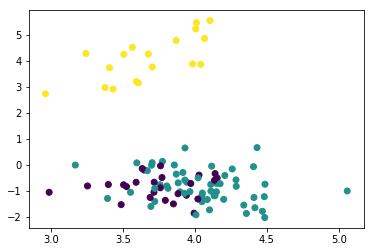

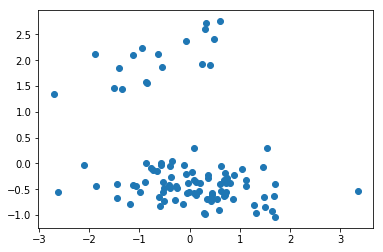

In [119]:
plt.scatter(annotators_pca[:,0],annotators_pca[:,1],c=groups_annot.argmax(axis=1))
plt.show()

std = StandardScaler()
annotators_pca2 = std.fit_transform(annotators_pca)
plt.scatter(annotators_pca2[:,0],annotators_pca2[:,1])
plt.show()

In [42]:
gMixture1 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture1.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture1.lambda_random = False #lambda=1     
logL_hists,i_r = gMixture1.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.003375 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 8.97 sec)	logL: -48511.162	
Iter 2/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -48054.513	Tol1: 0.00941	Tol2: 0.06404	Tol3: 0.01810	
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -47719.367	Tol1: 0.00697	Tol2: 0.04276	Tol3: 0.00032	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -47344.273	Tol1: 0.00786	Tol2: 0.05259	Tol3: 0.00106	
Iter 5/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -46911.728	Tol1: 0.00914	Tol2: 0.06177	Tol3: 0.00122	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -46431.422	Tol1: 0.01024	Tol2: 0.07072	Tol3: 0.00161	
Iter 7/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -45893.800	Tol1: 0.011

M step: done,  E step: done //  (in 0.13 sec)	logL: -40500.523	Tol1: 0.00336	Tol2: 0.03107	Tol3: 0.00041	
Iter 19/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -40375.309	Tol1: 0.00309	Tol2: 0.03119	Tol3: 0.00003	
Iter 20/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -40266.392	Tol1: 0.00270	Tol2: 0.03275	Tol3: 0.00064	
Iter 21/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -40161.242	Tol1: 0.00261	Tol2: 0.03302	Tol3: 0.00076	
Iter 22/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -40067.662	Tol1: 0.00233	Tol2: 0.03353	Tol3: 0.00131	
Iter 23/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -39975.181	Tol1: 0.00231	Tol2: 0.03280	Tol3: 0.00107	
Iter 24/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -39889.418	Tol1: 0.00215	Tol2: 0.03240	Tol3: 0.00166	
Iter 25/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -39812.441	Tol1: 0.00193	Tol2: 0.03166	Tol3: 0.00144	
Iter 26/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -39740.333	T

M step: done,  E step: done //  (in 8.47 sec)	logL: -49135.408	
Iter 2/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -48382.749	Tol1: 0.01532	Tol2: 0.13605	Tol3: 0.03467	
Iter 3/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -47998.183	Tol1: 0.00795	Tol2: 0.06941	Tol3: 0.00420	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47577.439	Tol1: 0.00877	Tol2: 0.06598	Tol3: 0.00077	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -47106.562	Tol1: 0.00990	Tol2: 0.06873	Tol3: 0.00060	
Iter 6/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -46584.205	Tol1: 0.01109	Tol2: 0.07345	Tol3: 0.00056	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -46019.388	Tol1: 0.01212	Tol2: 0.07792	Tol3: 0.00051	
Iter 8/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -45407.361	Tol1: 0.01330	Tol2: 0.08330	Tol3: 0.00064	
Iter 9/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -44747.044	Tol1: 0.01454	Tol2: 0.09046	Tol3: 0.00070	
Iter 10/

M step: done,  E step: done //  (in 0.16 sec)	logL: -48244.150	Tol1: 0.00553	Tol2: 0.04804	Tol3: 0.00598	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47954.478	Tol1: 0.00600	Tol2: 0.04707	Tol3: 0.00112	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47611.460	Tol1: 0.00715	Tol2: 0.04711	Tol3: 0.00064	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -47209.364	Tol1: 0.00845	Tol2: 0.04988	Tol3: 0.00063	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -46739.023	Tol1: 0.00996	Tol2: 0.05583	Tol3: 0.00058	
Iter 8/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -46193.662	Tol1: 0.01167	Tol2: 0.06258	Tol3: 0.00053	
Iter 9/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -45584.213	Tol1: 0.01319	Tol2: 0.07322	Tol3: 0.00056	
Iter 10/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -44919.751	Tol1: 0.01458	Tol2: 0.08386	Tol3: 0.00064	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -44224.556	Tol1: 0

M step: done,  E step: done //  (in 0.16 sec)	logL: -42283.403	Tol1: 0.01175	Tol2: 0.11120	Tol3: 0.00060	
Iter 9/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41824.165	Tol1: 0.01086	Tol2: 0.10770	Tol3: 0.00130	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -41413.208	Tol1: 0.00983	Tol2: 0.10170	Tol3: 0.00200	
Iter 11/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -41056.437	Tol1: 0.00861	Tol2: 0.09417	Tol3: 0.00259	
Iter 12/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -40767.489	Tol1: 0.00704	Tol2: 0.08402	Tol3: 0.00271	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40523.278	Tol1: 0.00599	Tol2: 0.07335	Tol3: 0.00323	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40321.524	Tol1: 0.00498	Tol2: 0.06457	Tol3: 0.00367	
Iter 15/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40144.798	Tol1: 0.00438	Tol2: 0.06029	Tol3: 0.00368	
Iter 16/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -39996.980	To

In [43]:
gMixture2 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture2.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture2.lambda_random = True #lambda random
logL_hists,i_r = gMixture2.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.004671 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.03 0.04 0.58]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 11.81 sec)	logL: -47893.726	
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -46795.137	Tol1: 0.02294	Tol2: 0.15603	Tol3: 0.00846	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -45904.463	Tol1: 0.01903	Tol2: 0.09954	Tol3: 0.00415	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -45109.323	Tol1: 0.01732	Tol2: 0.07261	Tol3: 0.00299	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -44392.581	Tol1: 0.01589	Tol2: 0.05718	Tol3: 0.00357	
Iter 6/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -43708.633	Tol1: 0.01541	Tol2: 0.05617	Tol3: 0.00500	
Iter 7/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -43069.263	Tol1

M step: done,  E step: done //  (in 0.15 sec)	logL: -48770.686	Tol1: 0.00974	Tol2: 0.07563	Tol3: 0.00499	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -48406.007	Tol1: 0.00748	Tol2: 0.05467	Tol3: 0.00362	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -48069.493	Tol1: 0.00695	Tol2: 0.04935	Tol3: 0.00274	
Iter 10/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47732.295	Tol1: 0.00701	Tol2: 0.05420	Tol3: 0.00252	
Iter 11/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47333.491	Tol1: 0.00836	Tol2: 0.06116	Tol3: 0.00215	
Iter 12/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -46855.429	Tol1: 0.01010	Tol2: 0.06882	Tol3: 0.00216	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -46295.906	Tol1: 0.01194	Tol2: 0.07610	Tol3: 0.00239	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -45646.641	Tol1: 0.01402	Tol2: 0.08199	Tol3: 0.00308	
Iter 15/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -44952.155	Tol

M step: done,  E step: done //  (in 0.18 sec)	logL: -40289.915	Tol1: 0.00271	Tol2: 0.05575	Tol3: 0.00840	
Iter 20/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40192.618	Tol1: 0.00241	Tol2: 0.05083	Tol3: 0.00726	
Iter 21/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -40103.468	Tol1: 0.00222	Tol2: 0.04976	Tol3: 0.00659	
Iter 22/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40029.086	Tol1: 0.00185	Tol2: 0.05052	Tol3: 0.00604	
Iter 23/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -39956.745	Tol1: 0.00181	Tol2: 0.04935	Tol3: 0.00534	
Iter 24/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -39905.880	Tol1: 0.00127	Tol2: 0.05053	Tol3: 0.00486	
Iter 25/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -39845.243	Tol1: 0.00152	Tol2: 0.05038	Tol3: 0.00447	
Iter 26/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -39808.231	Tol1: 0.00093	Tol2: 0.04456	Tol3: 0.00320	
Iter 27/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -39760.909	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -41961.675	Tol1: 0.00751	Tol2: 0.08604	Tol3: 0.00386	
Iter 15/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -41686.885	Tol1: 0.00655	Tol2: 0.07965	Tol3: 0.00240	
Iter 16/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41460.262	Tol1: 0.00544	Tol2: 0.07395	Tol3: 0.00117	
Iter 17/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41273.626	Tol1: 0.00450	Tol2: 0.06717	Tol3: 0.00071	
Iter 18/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -41125.304	Tol1: 0.00359	Tol2: 0.06025	Tol3: 0.00030	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41001.670	Tol1: 0.00301	Tol2: 0.05130	Tol3: 0.00033	
Iter 20/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40896.557	Tol1: 0.00256	Tol2: 0.04271	Tol3: 0.00021	
Iter 21/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -40806.601	Tol1: 0.00220	Tol2: 0.03370	Tol3: 0.00024	
Iter 22/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40726.650	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -42921.141	Tol1: 0.01195	Tol2: 0.08532	Tol3: 0.00436	
Iter 12/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -42443.260	Tol1: 0.01113	Tol2: 0.08519	Tol3: 0.00419	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -41984.028	Tol1: 0.01082	Tol2: 0.08290	Tol3: 0.00392	
Iter 14/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41564.574	Tol1: 0.00999	Tol2: 0.07971	Tol3: 0.00355	
Iter 15/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -41203.304	Tol1: 0.00869	Tol2: 0.07501	Tol3: 0.00312	
Iter 16/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -40899.236	Tol1: 0.00738	Tol2: 0.06956	Tol3: 0.00263	
Iter 17/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40626.465	Tol1: 0.00667	Tol2: 0.06359	Tol3: 0.00220	
Iter 18/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40401.971	Tol1: 0.00553	Tol2: 0.05685	Tol3: 0.00186	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40222.830	T

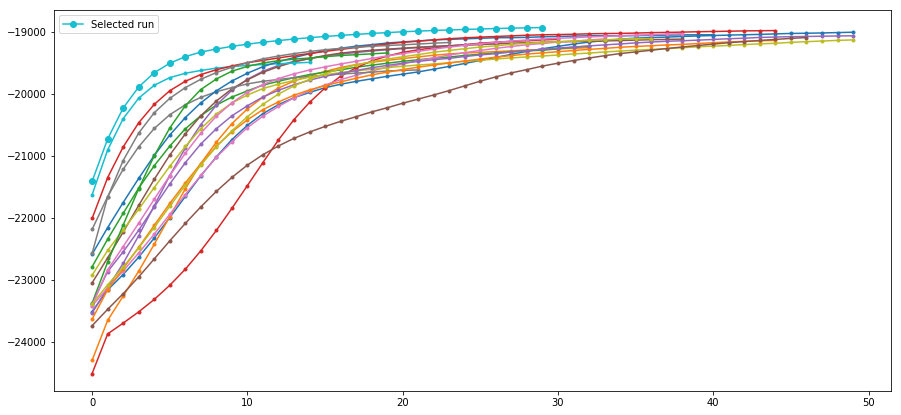

In [74]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',label="Selected run")
plt.legend()
plt.show()

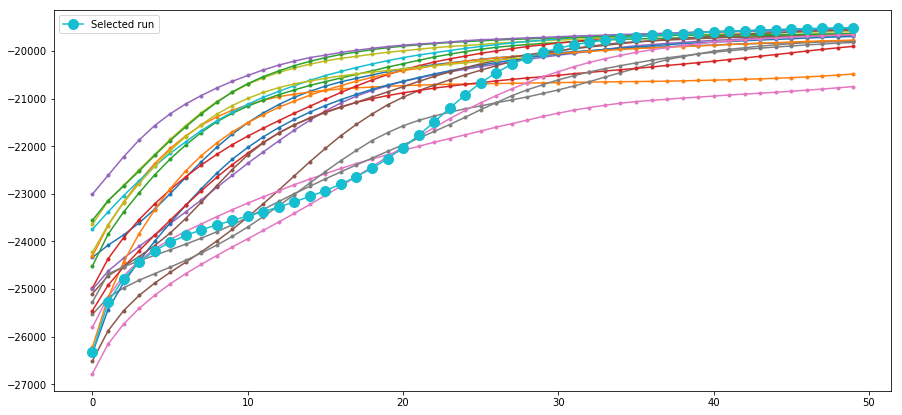

In [52]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [13]:
#Import it:
from code.evaluation import Evaluation_metrics
from sklearn.metrics import confusion_matrix

In [25]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
Z_train_pred = model_UB.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = model_UB.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.912495      0.912495
====  ======  ==========  ============
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global     0.91453       0.91453
====  ======  ==========  ============


#### 1st configuration: Normal ($T$ = 100, $T_{max}$ = 10 )

In [27]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7663817663817664


*** Soft-Majority (Train with softMV) ***
Train


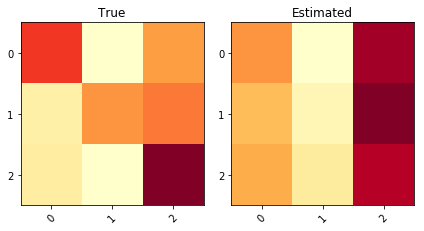

KL divergence: 0.2830	Pearson Correlation between diagonals: 0.9917


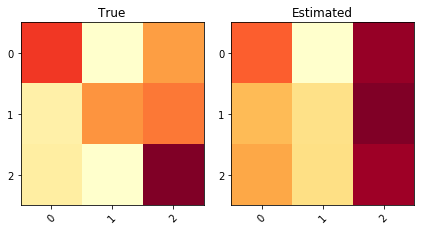

KL divergence: 0.2486	Pearson Correlation between diagonals: 0.9857


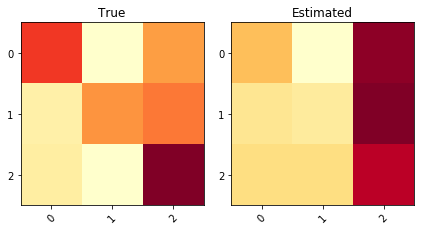

KL divergence: 0.2754	Pearson Correlation between diagonals: 0.9909


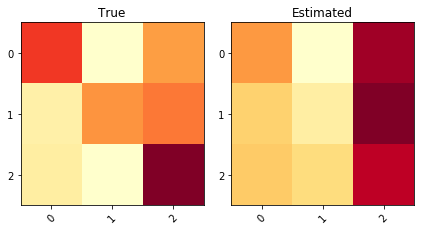

KL divergence: 0.2758	Pearson Correlation between diagonals: 0.9972


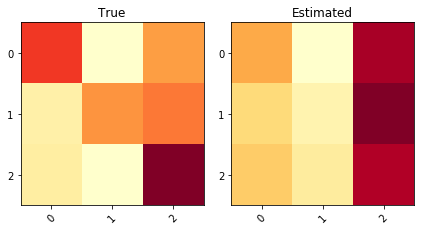

KL divergence: 0.2636	Pearson Correlation between diagonals: 1.0000


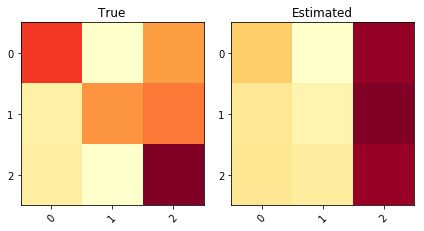

KL divergence: 0.2655	Pearson Correlation between diagonals: 0.9850


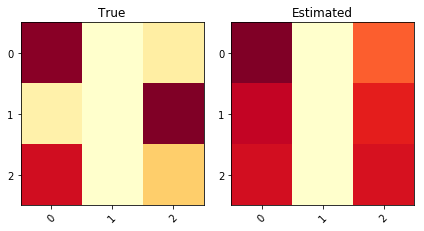

KL divergence: 0.2543	Pearson Correlation between diagonals: 0.8458


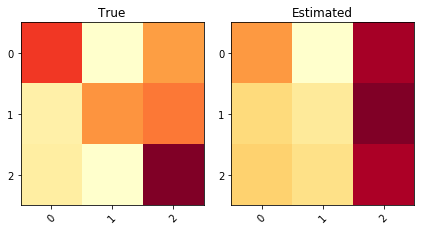

KL divergence: 0.2516	Pearson Correlation between diagonals: 0.9996


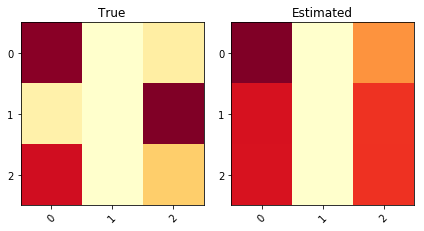

KL divergence: 0.2281	Pearson Correlation between diagonals: 0.8974


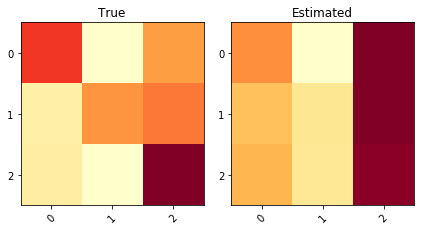

KL divergence: 0.2418	Pearson Correlation between diagonals: 0.9999


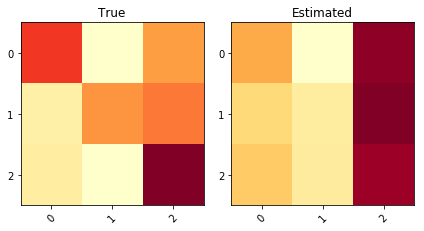

KL divergence: 0.2494	Pearson Correlation between diagonals: 0.9983


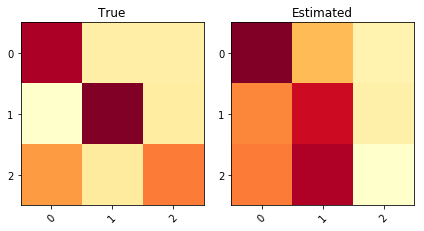

KL divergence: 0.3745	Pearson Correlation between diagonals: 0.9351


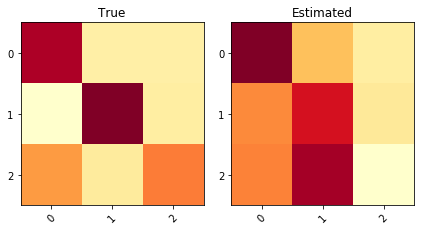

KL divergence: 0.3844	Pearson Correlation between diagonals: 0.9249


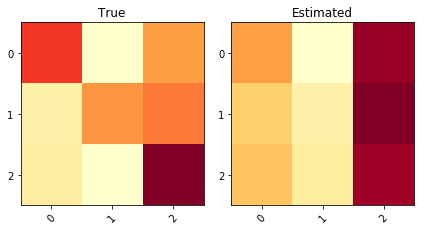

KL divergence: 0.2577	Pearson Correlation between diagonals: 0.9999


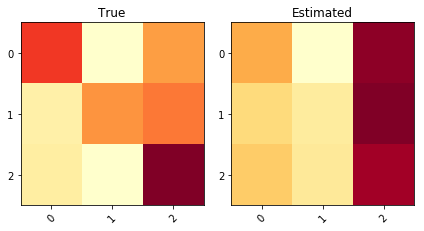

KL divergence: 0.2522	Pearson Correlation between diagonals: 0.9977
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.457061      0.457061   0.287433  0.0794692            0.930672
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global     0.47619       0.47619
====  ======  ==========  ============


In [28]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


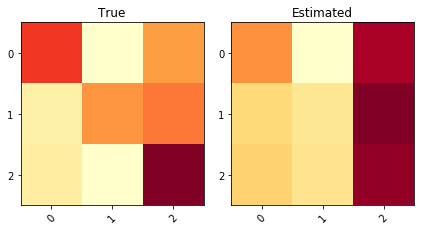

KL divergence: 0.2252	Pearson Correlation between diagonals: 0.9997


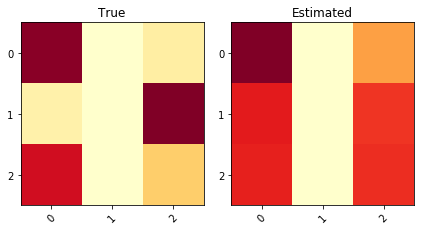

KL divergence: 0.2202	Pearson Correlation between diagonals: 0.8928


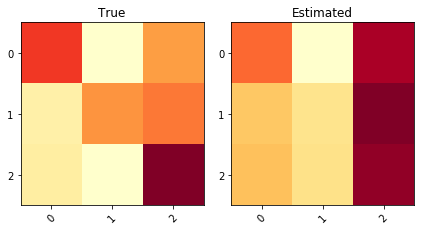

KL divergence: 0.2230	Pearson Correlation between diagonals: 0.9922


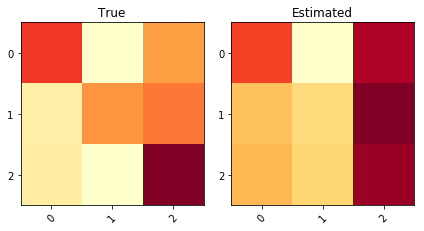

KL divergence: 0.2293	Pearson Correlation between diagonals: 0.9731


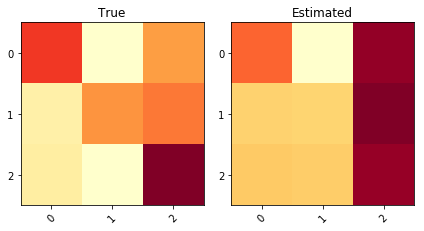

KL divergence: 0.2288	Pearson Correlation between diagonals: 0.9970


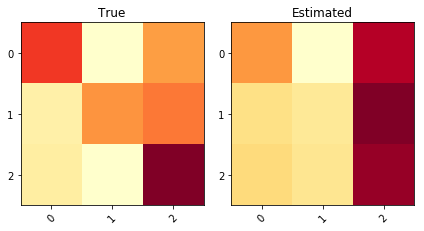

KL divergence: 0.2163	Pearson Correlation between diagonals: 1.0000


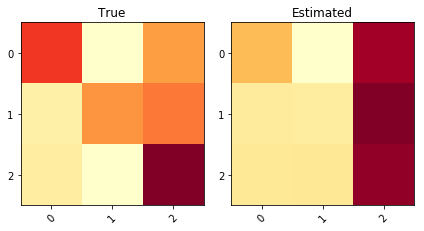

KL divergence: 0.2352	Pearson Correlation between diagonals: 0.9889


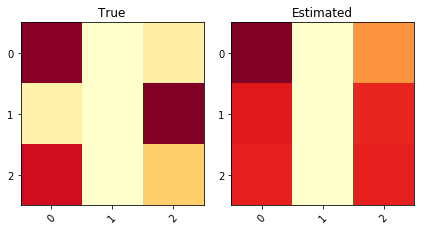

KL divergence: 0.2243	Pearson Correlation between diagonals: 0.8742


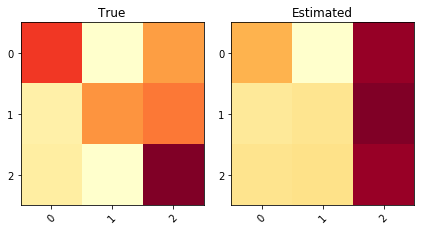

KL divergence: 0.2340	Pearson Correlation between diagonals: 0.9886


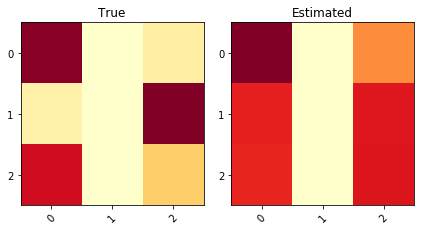

KL divergence: 0.2206	Pearson Correlation between diagonals: 0.8565


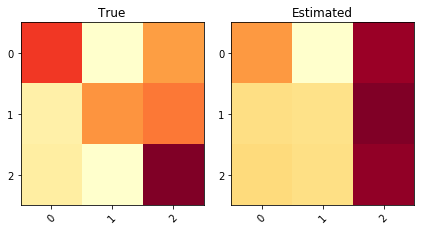

KL divergence: 0.2267	Pearson Correlation between diagonals: 0.9988


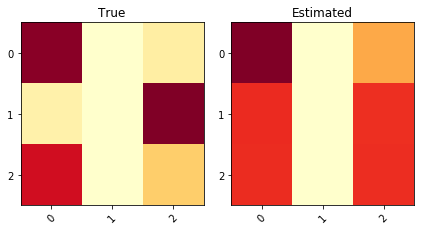

KL divergence: 0.2090	Pearson Correlation between diagonals: 0.8924


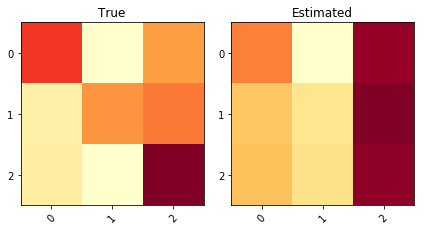

KL divergence: 0.2287	Pearson Correlation between diagonals: 0.9979


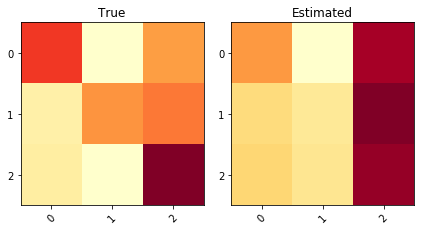

KL divergence: 0.2278	Pearson Correlation between diagonals: 1.0000


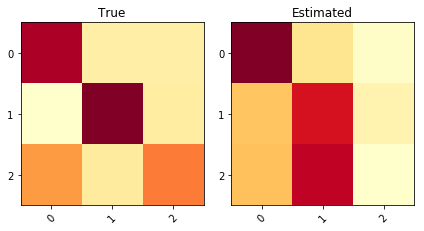

KL divergence: 0.3506	Pearson Correlation between diagonals: 0.9233
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.496133      0.496133   0.259383  0.0725451            0.932226
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.500611      0.500611
====  ======  ==========  ============


In [30]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


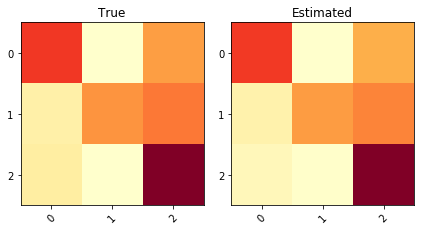

KL divergence: 0.0104	Pearson Correlation between diagonals: 0.9997


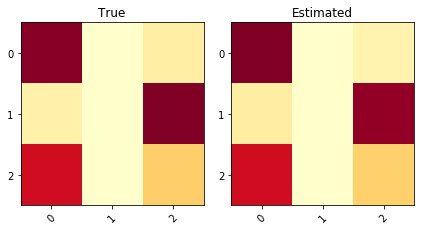

KL divergence: 0.0030	Pearson Correlation between diagonals: 0.9999


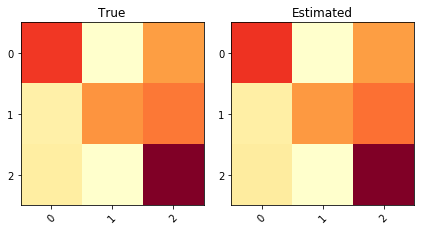

KL divergence: 0.0004	Pearson Correlation between diagonals: 0.9991


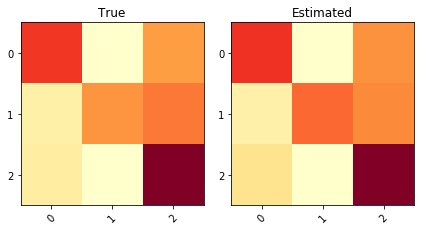

KL divergence: 0.0057	Pearson Correlation between diagonals: 0.9933


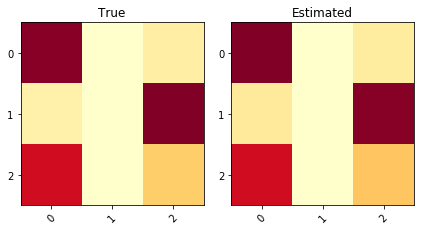

KL divergence: 0.0031	Pearson Correlation between diagonals: 0.9996


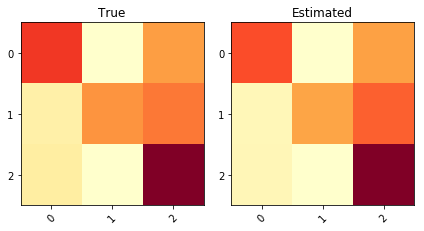

KL divergence: 0.0120	Pearson Correlation between diagonals: 0.9996


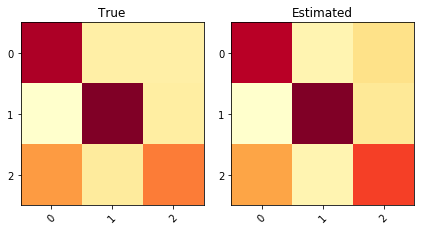

KL divergence: 0.0192	Pearson Correlation between diagonals: 0.9884


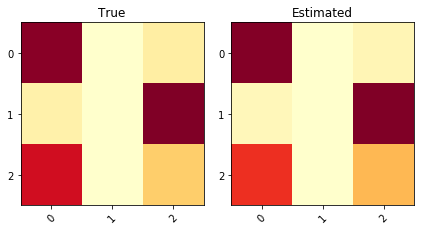

KL divergence: 0.0132	Pearson Correlation between diagonals: 0.9971


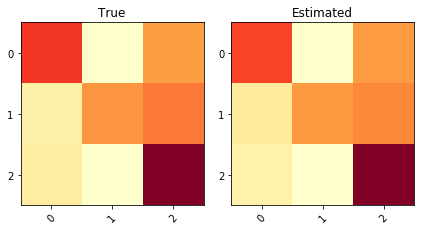

KL divergence: 0.0024	Pearson Correlation between diagonals: 0.9992


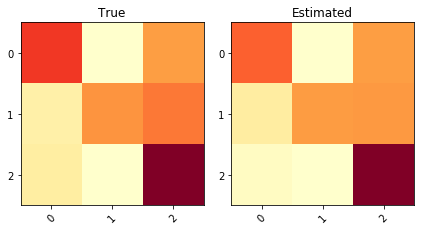

KL divergence: 0.0255	Pearson Correlation between diagonals: 0.9887


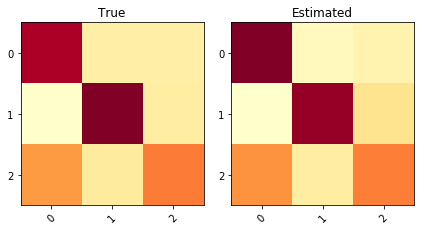

KL divergence: 0.0174	Pearson Correlation between diagonals: 0.9578


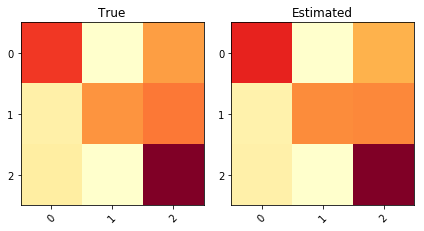

KL divergence: 0.0031	Pearson Correlation between diagonals: 0.9971


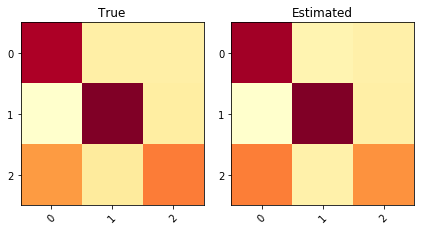

KL divergence: 0.0062	Pearson Correlation between diagonals: 0.9977


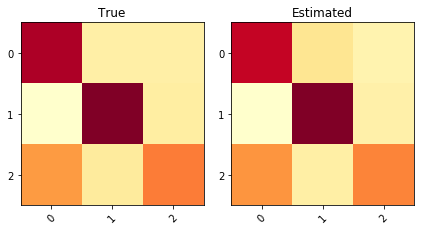

KL divergence: 0.0064	Pearson Correlation between diagonals: 0.9938


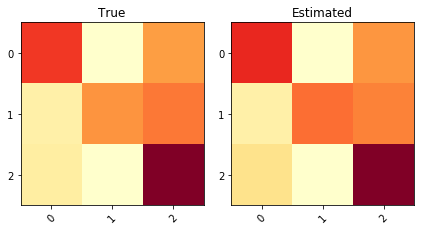

KL divergence: 0.0052	Pearson Correlation between diagonals: 0.9993
A result
 ====  ======  ==========  ============  ==========  ==========  ==================
  ..            Accuracy    F1 (micro)     Mean KL     Mean JS    Mean PearsonCorr
====  ======  ==========  ============  ==========  ==========  ==================
   0  Global    0.619455      0.619455  0.00992152  0.00239135            0.988719
====  ======  ==========  ============  ==========  ==========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.595849      0.595849
====  ======  ==========  ============


In [32]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


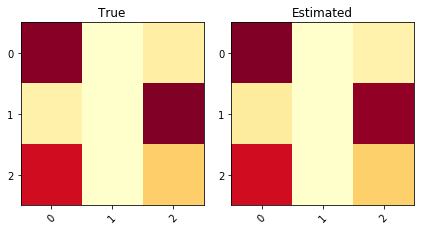

KL divergence: 0.0162	Pearson Correlation between diagonals: 0.9999


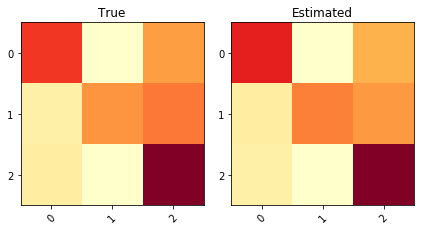

KL divergence: 0.0145	Pearson Correlation between diagonals: 0.9980


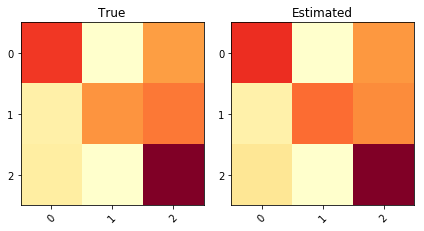

KL divergence: 0.0130	Pearson Correlation between diagonals: 0.9959


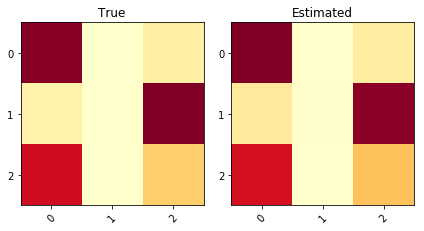

KL divergence: 0.0183	Pearson Correlation between diagonals: 0.9994


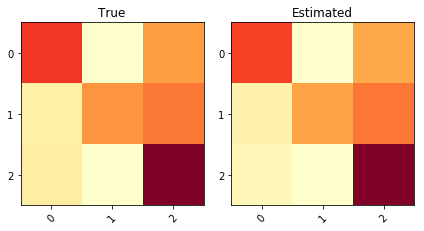

KL divergence: 0.0118	Pearson Correlation between diagonals: 1.0000


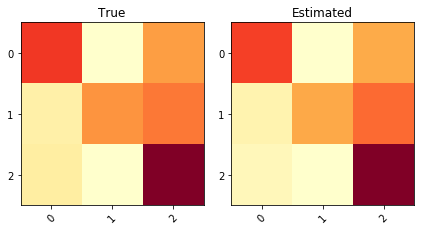

KL divergence: 0.0140	Pearson Correlation between diagonals: 0.9991


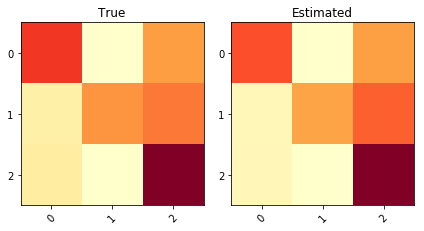

KL divergence: 0.0155	Pearson Correlation between diagonals: 0.9993


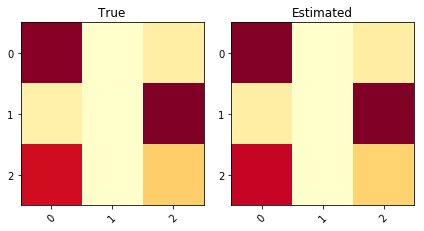

KL divergence: 0.0135	Pearson Correlation between diagonals: 0.9998


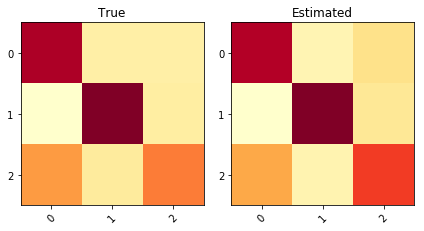

KL divergence: 0.0221	Pearson Correlation between diagonals: 0.9917


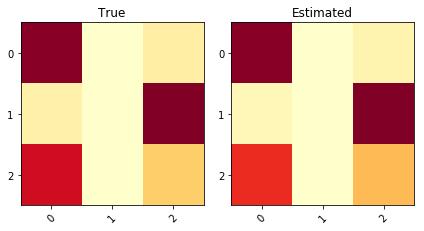

KL divergence: 0.0185	Pearson Correlation between diagonals: 0.9973


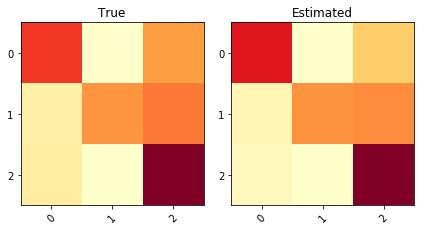

KL divergence: 0.0270	Pearson Correlation between diagonals: 0.9844


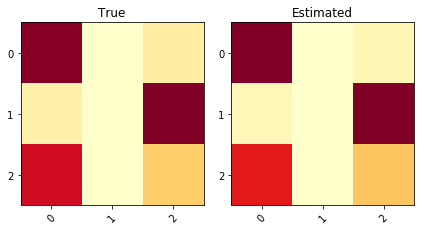

KL divergence: 0.0173	Pearson Correlation between diagonals: 0.9997


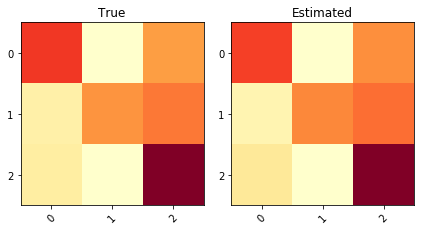

KL divergence: 0.0114	Pearson Correlation between diagonals: 0.9956


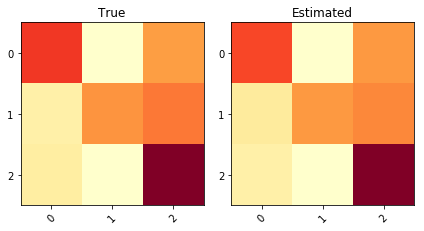

KL divergence: 0.0107	Pearson Correlation between diagonals: 0.9982


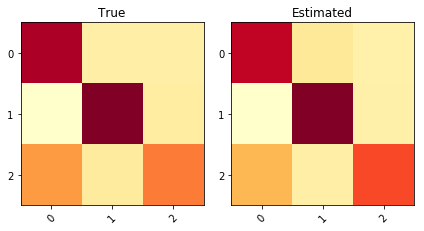

KL divergence: 0.0131	Pearson Correlation between diagonals: 0.9795
A result
 ====  ======  ==========  ============  =========  ==========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  ==========  ==================  ==============
   0  Global    0.908425      0.908425  0.0164586  0.00487151            0.988983        0.143644
====  ======  ==========  ============  =========  ==========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.663532                0.734662
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.91

In [33]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (3) multiples runs***
Train


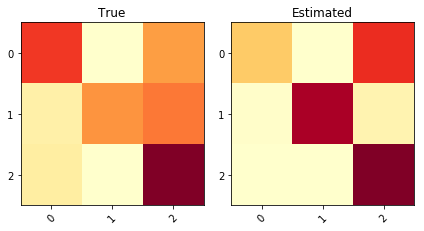

KL divergence: 0.3884	Pearson Correlation between diagonals: 0.2418


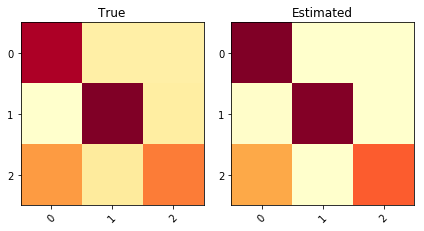

KL divergence: 0.2972	Pearson Correlation between diagonals: 0.9771


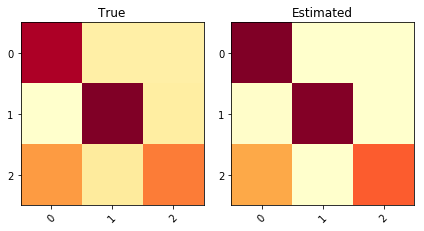

KL divergence: 0.2972	Pearson Correlation between diagonals: 0.9771


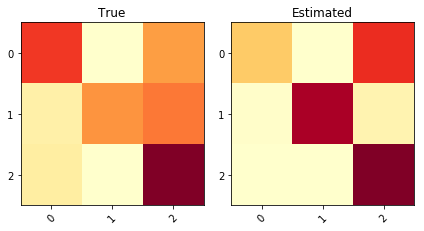

KL divergence: 0.3884	Pearson Correlation between diagonals: 0.2418


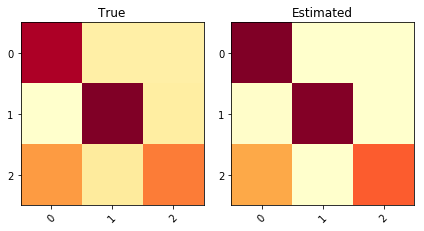

KL divergence: 0.2972	Pearson Correlation between diagonals: 0.9771


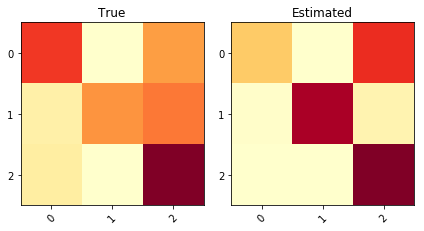

KL divergence: 0.3884	Pearson Correlation between diagonals: 0.2418


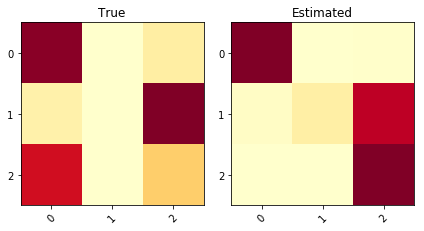

KL divergence: 1.3780	Pearson Correlation between diagonals: 0.7206


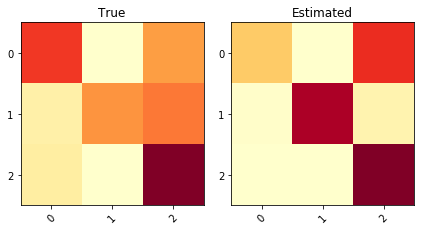

KL divergence: 0.3872	Pearson Correlation between diagonals: 0.2427


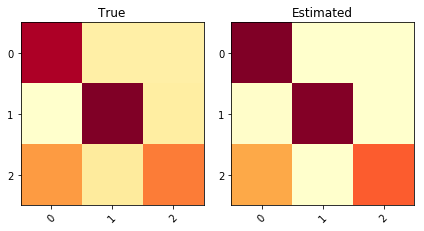

KL divergence: 0.2972	Pearson Correlation between diagonals: 0.9771


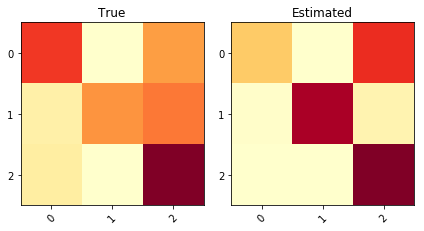

KL divergence: 0.3884	Pearson Correlation between diagonals: 0.2418


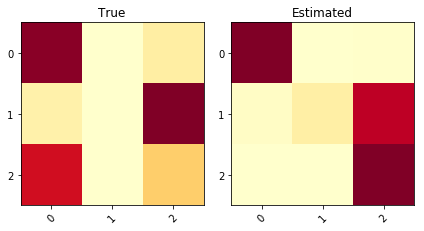

KL divergence: 1.3780	Pearson Correlation between diagonals: 0.7206


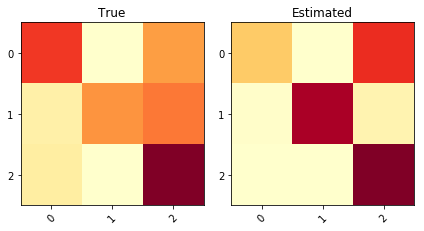

KL divergence: 0.3884	Pearson Correlation between diagonals: 0.2418


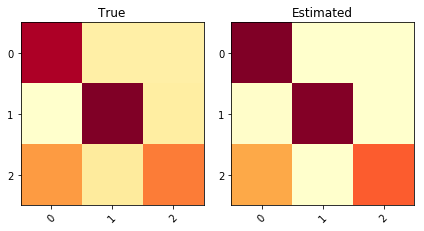

KL divergence: 0.2972	Pearson Correlation between diagonals: 0.9771


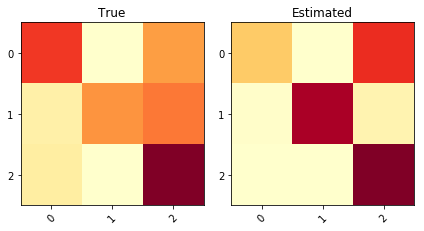

KL divergence: 0.3884	Pearson Correlation between diagonals: 0.2418


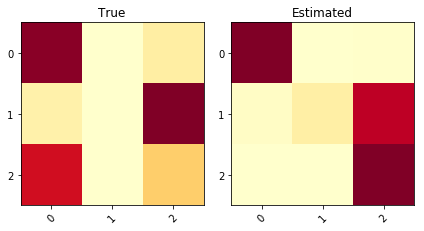

KL divergence: 1.3780	Pearson Correlation between diagonals: 0.7206
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.923891      0.923891    0.57712   0.081307            0.541391       0.0803617
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                  0.62676                0.787907
====  =======================  ======================
Test


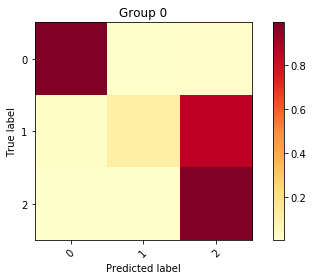

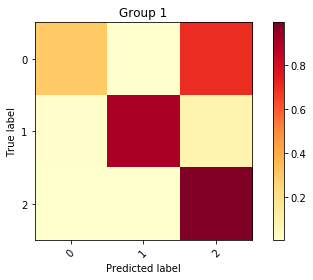

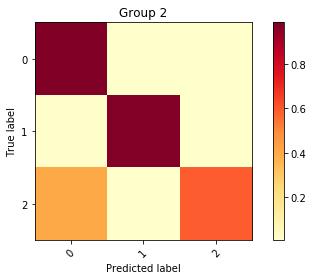

Inertia: 0.2033955380320549
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.444607      44   0.182219     0.699368   0.736557       0.751375   0.549052    0.64591       0.64591
   1         1  0.28917       28   0.345951     0.730698   0.442753       0.816051   0.596047    0.606838      0.606838
   2         2  0.266223      26   0.292072     0.854036   0.184655       0.91432    0.781054    0.655678      0.655678
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =========

In [18]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture_Global.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (1) multiples runs***
Train


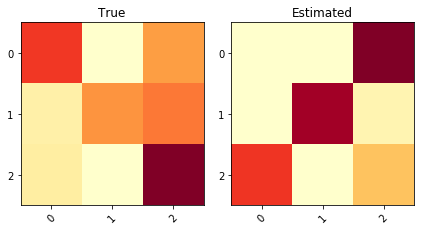

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


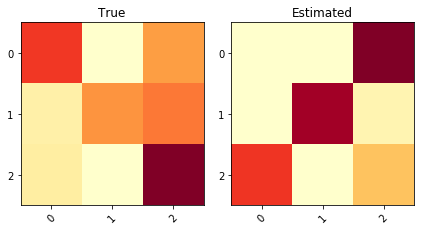

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


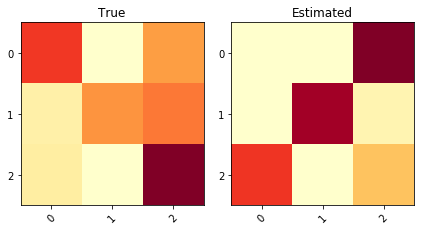

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


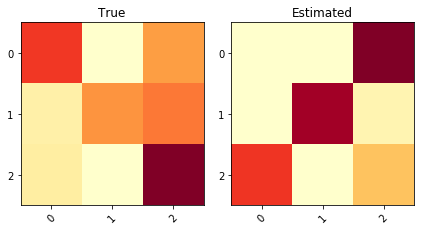

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


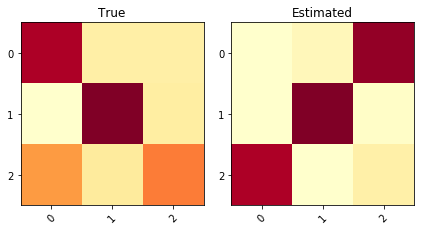

KL divergence: 1.5012	Pearson Correlation between diagonals: 0.5843


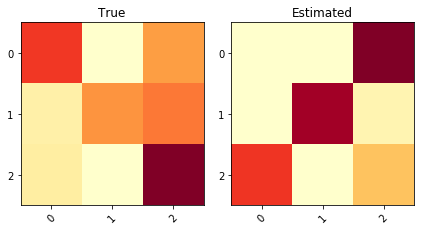

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


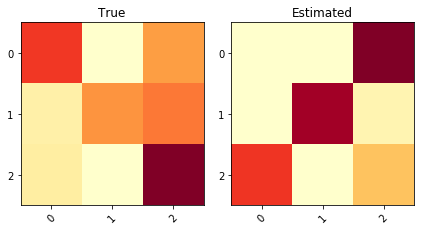

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


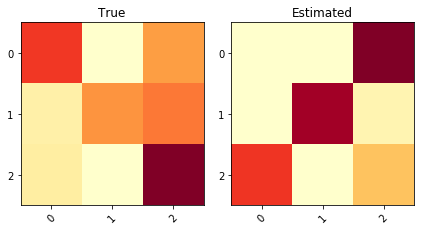

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


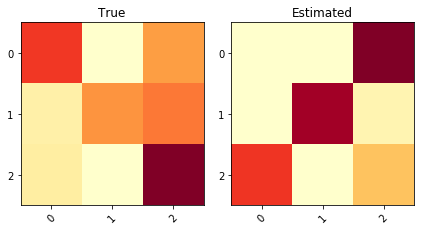

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


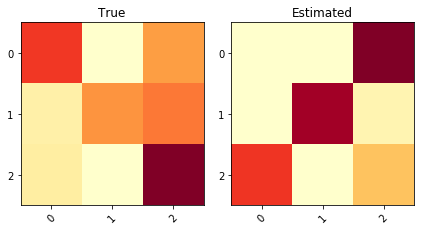

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


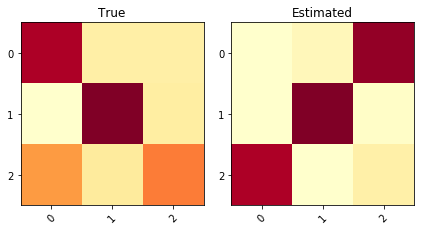

KL divergence: 1.5012	Pearson Correlation between diagonals: 0.5843


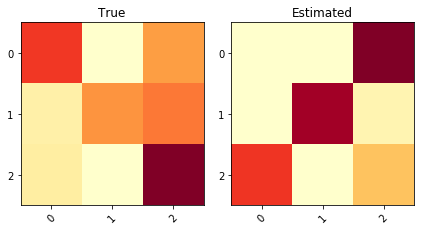

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


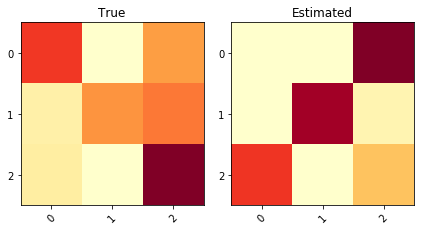

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


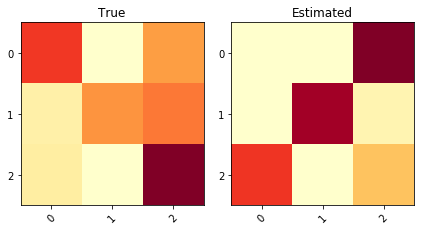

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


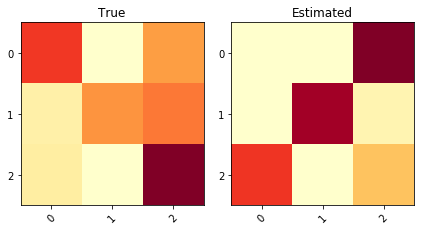

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.387464      0.387464    1.46138   0.203843           -0.344831       0.0975104
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.661312                0.727459
====  =======================  ======================
Test


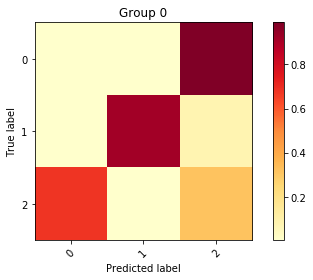

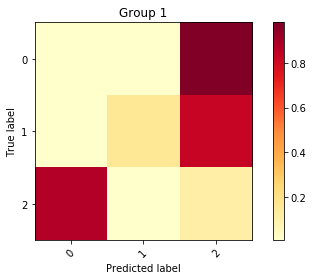

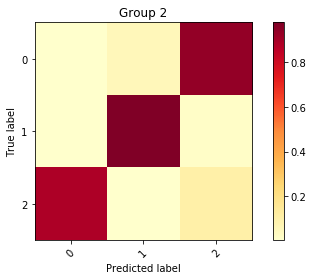

Inertia: 0.09433624582986037
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)     Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
   0         0  0.548259      54   0.332222    0.413273     2.34267       0.499222   0.0799397    0.802198      0.802198
   1         1  0.16093       16   0.34057     0.0939899    2.8462        0.213318  -0.239343     0.630037      0.630037
   2         2  0.290811      29   0.252397    0.363872     2.39851       0.424208   0.0305391    0.882784      0.882784
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  

In [34]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


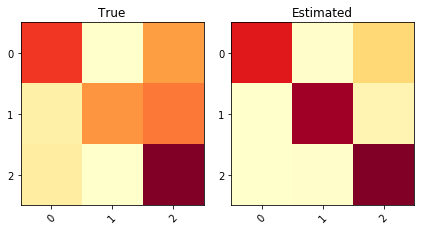

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


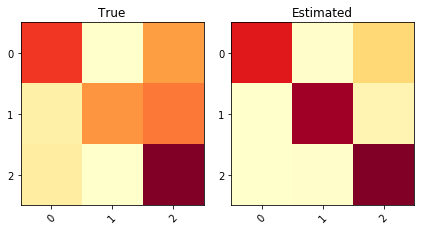

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


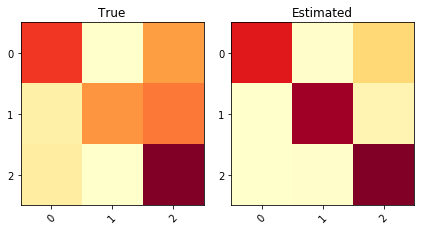

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


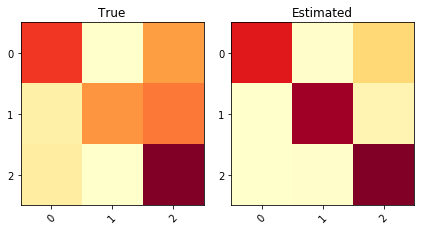

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


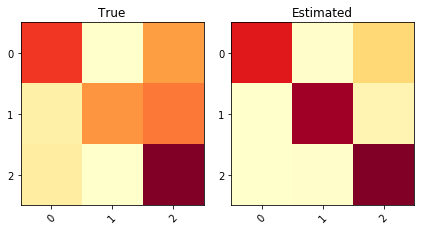

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


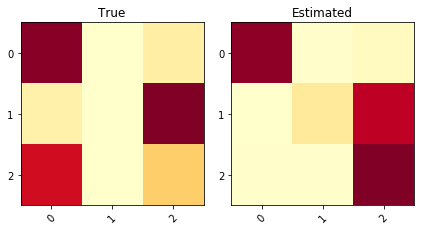

KL divergence: 1.1035	Pearson Correlation between diagonals: 0.6998


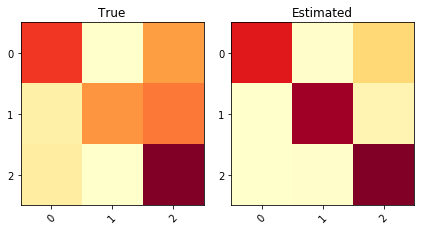

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


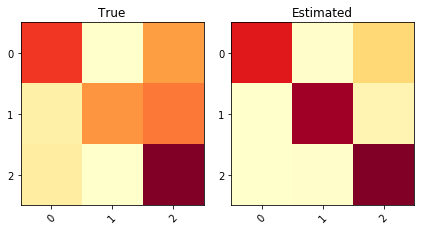

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


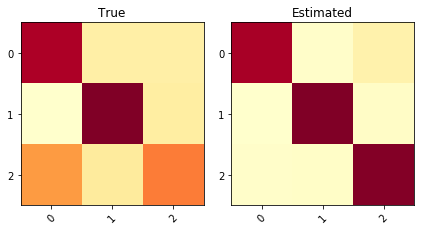

KL divergence: 0.5067	Pearson Correlation between diagonals: -0.2431


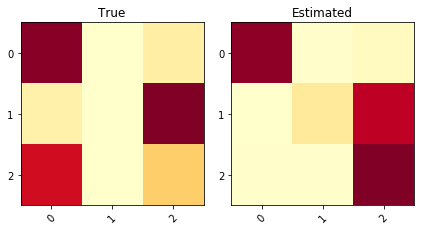

KL divergence: 1.1035	Pearson Correlation between diagonals: 0.6998


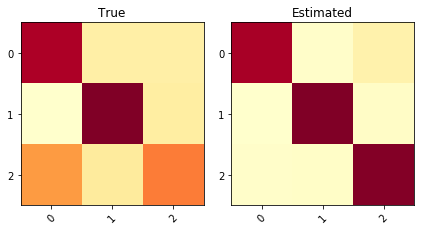

KL divergence: 0.5067	Pearson Correlation between diagonals: -0.2431


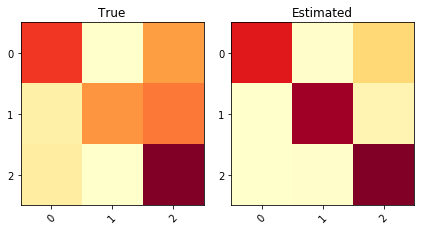

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


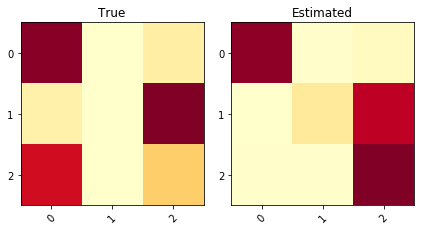

KL divergence: 1.1035	Pearson Correlation between diagonals: 0.6998


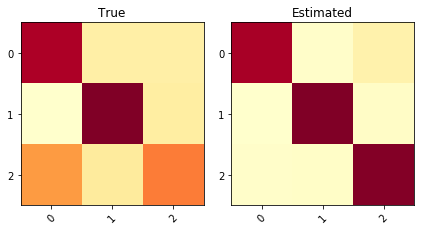

KL divergence: 0.5067	Pearson Correlation between diagonals: -0.2431


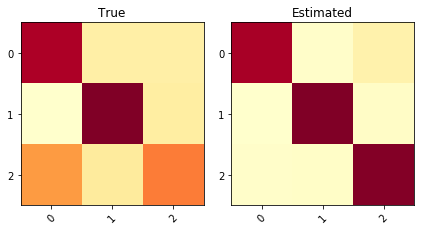

KL divergence: 0.5067	Pearson Correlation between diagonals: -0.2431
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.892552      0.892552   0.600229  0.0875265            0.289699       0.0963832
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.658511                 0.73373
====  =======================  ======================
Test


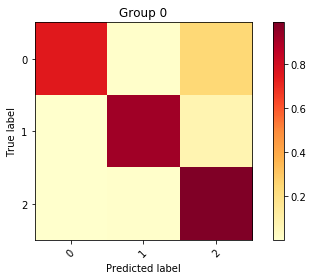

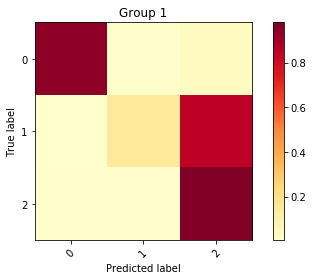

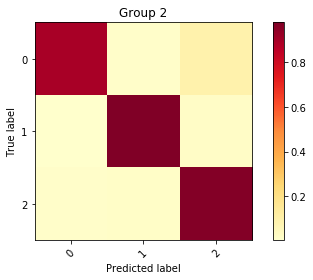

Inertia: 0.0972544342900316
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.544033      54   0.310449     0.8868    0.12712         0.938615   0.553466    0.84127       0.84127
   1         1  0.181161      18   0.261901     0.689919  0.675244        0.757545   0.356585    0.634921      0.634921
   2         2  0.274806      27   0.211517     0.948153  0.0540261       0.973305   0.614819    0.910867      0.910867
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =========

In [35]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 2) configuration: very bad MV ($T$ = 100, $T_{max}$ = 10 )

In [52]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.6581196581196581


*** Soft-Majority (Train with softMV) ***
Train


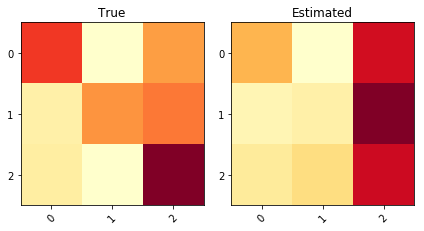

KL divergence: 0.2514	Pearson Correlation between diagonals: 0.9996


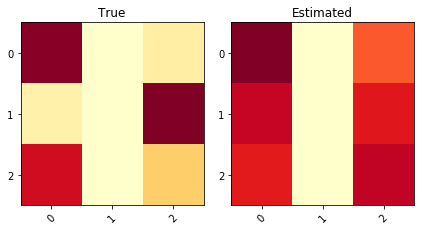

KL divergence: 0.2643	Pearson Correlation between diagonals: 0.8072


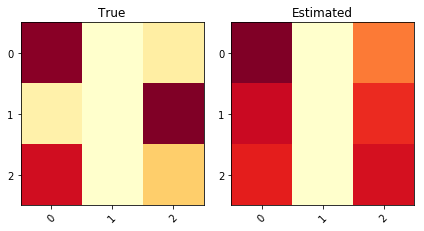

KL divergence: 0.2560	Pearson Correlation between diagonals: 0.8426


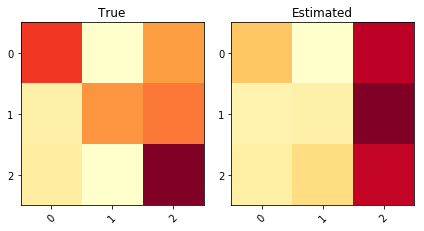

KL divergence: 0.2651	Pearson Correlation between diagonals: 0.9924


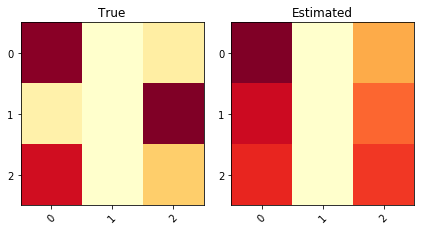

KL divergence: 0.2546	Pearson Correlation between diagonals: 0.9044


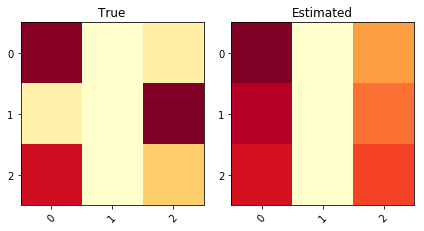

KL divergence: 0.2712	Pearson Correlation between diagonals: 0.9170


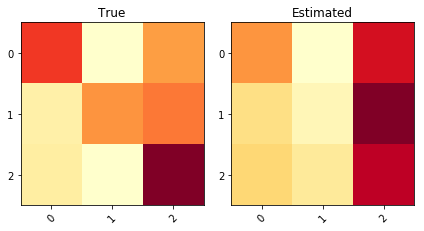

KL divergence: 0.2525	Pearson Correlation between diagonals: 0.9912


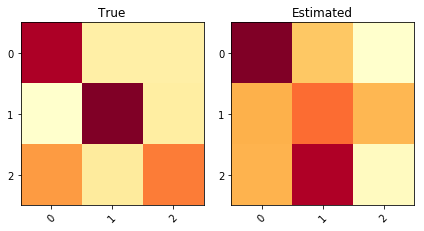

KL divergence: 0.3978	Pearson Correlation between diagonals: 0.7899


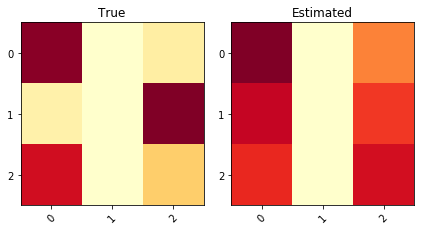

KL divergence: 0.2663	Pearson Correlation between diagonals: 0.8391


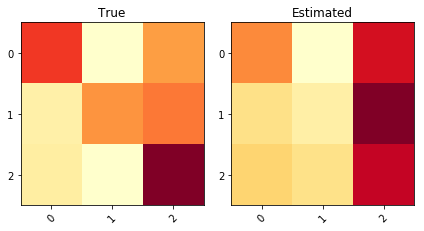

KL divergence: 0.2458	Pearson Correlation between diagonals: 0.9852


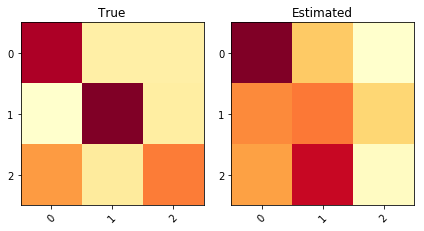

KL divergence: 0.4023	Pearson Correlation between diagonals: 0.7746


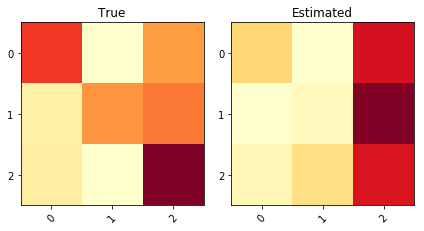

KL divergence: 0.2859	Pearson Correlation between diagonals: 0.9935


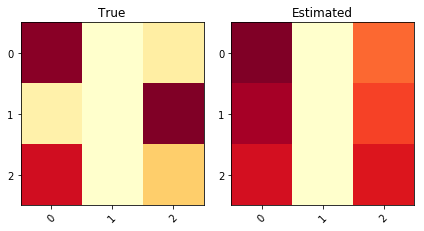

KL divergence: 0.2814	Pearson Correlation between diagonals: 0.8554


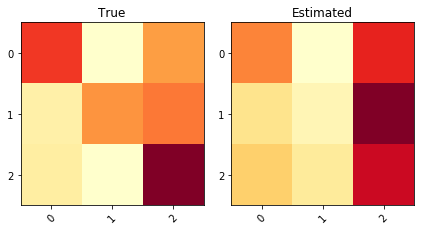

KL divergence: 0.2463	Pearson Correlation between diagonals: 0.9718


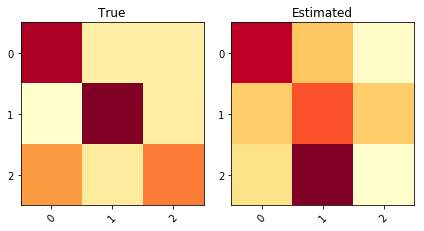

KL divergence: 0.4060	Pearson Correlation between diagonals: 0.8878
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.46398       0.46398   0.304018  0.0837234            0.890157
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.498168      0.498168
====  ======  ==========  ============


In [53]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical) #no more,,,
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


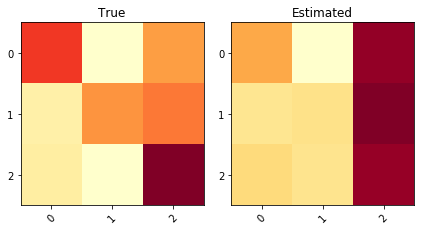

KL divergence: 0.2332	Pearson Correlation between diagonals: 0.9920


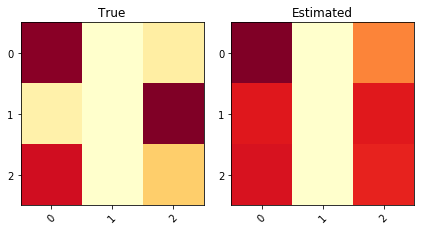

KL divergence: 0.2176	Pearson Correlation between diagonals: 0.8796


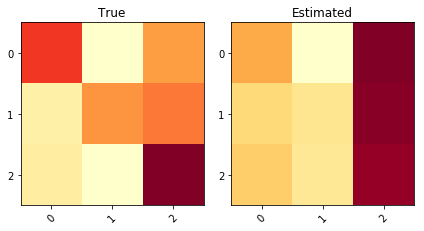

KL divergence: 0.2465	Pearson Correlation between diagonals: 0.9935


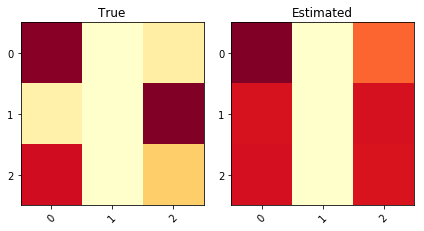

KL divergence: 0.2300	Pearson Correlation between diagonals: 0.8524


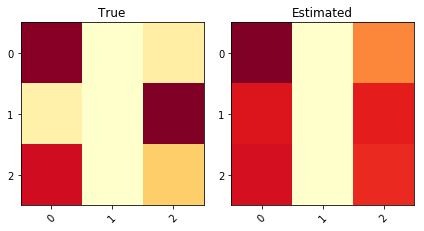

KL divergence: 0.2207	Pearson Correlation between diagonals: 0.8864


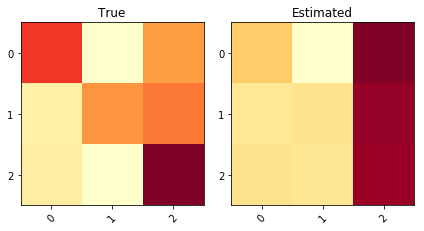

KL divergence: 0.2514	Pearson Correlation between diagonals: 0.9676


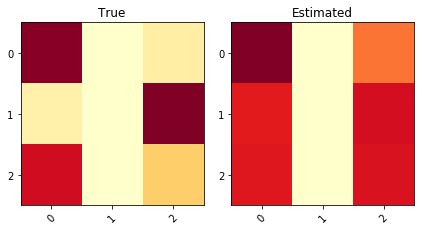

KL divergence: 0.2211	Pearson Correlation between diagonals: 0.8492


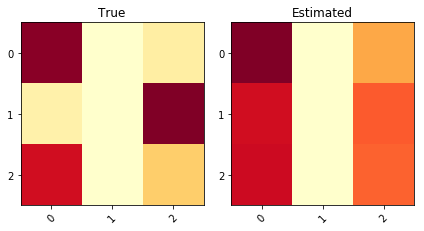

KL divergence: 0.2296	Pearson Correlation between diagonals: 0.9439


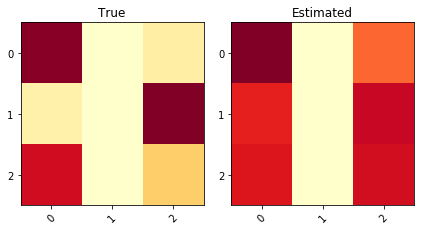

KL divergence: 0.2190	Pearson Correlation between diagonals: 0.8379


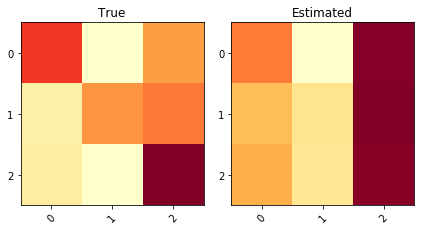

KL divergence: 0.2427	Pearson Correlation between diagonals: 0.9982


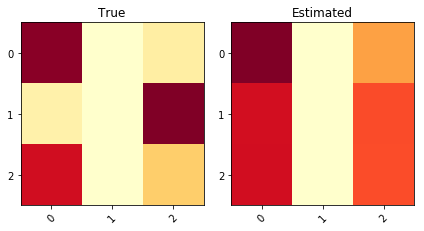

KL divergence: 0.2286	Pearson Correlation between diagonals: 0.9269


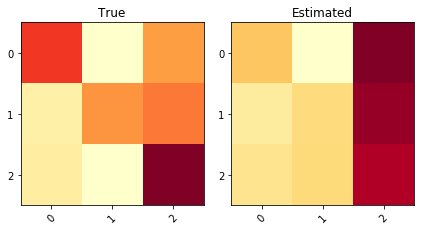

KL divergence: 0.2557	Pearson Correlation between diagonals: 0.9597


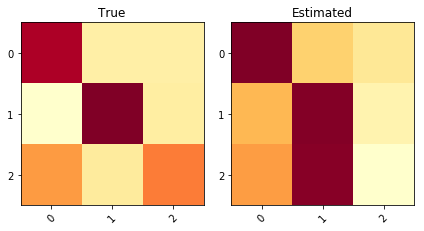

KL divergence: 0.3574	Pearson Correlation between diagonals: 0.9798


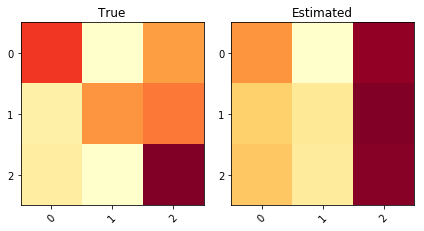

KL divergence: 0.2312	Pearson Correlation between diagonals: 1.0000


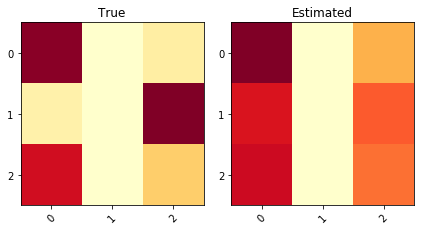

KL divergence: 0.2175	Pearson Correlation between diagonals: 0.9540
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.460317      0.460317   0.270593  0.0754019            0.938948
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.471306      0.471306
====  ======  ==========  ============


In [55]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


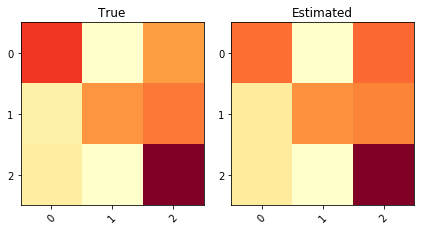

KL divergence: 0.0100	Pearson Correlation between diagonals: 0.9680


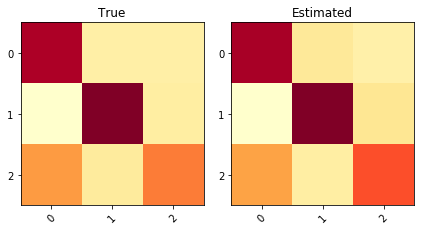

KL divergence: 0.0057	Pearson Correlation between diagonals: 0.9998


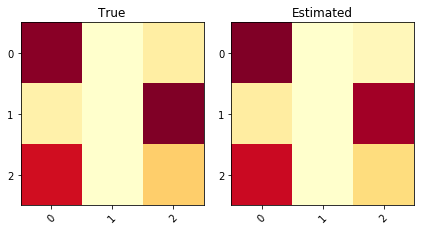

KL divergence: 0.0116	Pearson Correlation between diagonals: 0.9976


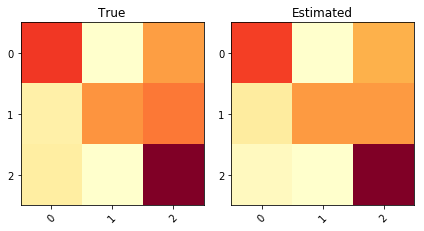

KL divergence: 0.0175	Pearson Correlation between diagonals: 0.9999


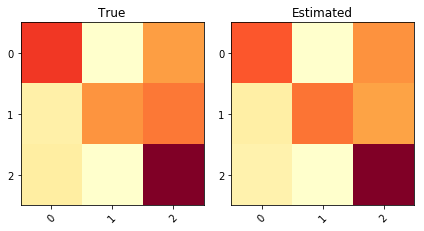

KL divergence: 0.0089	Pearson Correlation between diagonals: 0.9618


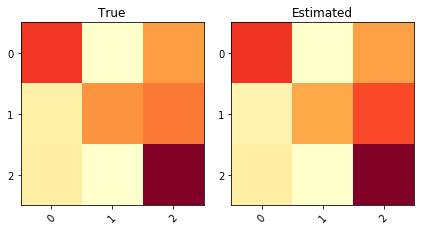

KL divergence: 0.0044	Pearson Correlation between diagonals: 0.9956


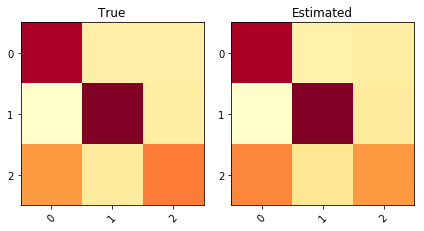

KL divergence: 0.0044	Pearson Correlation between diagonals: 0.9991


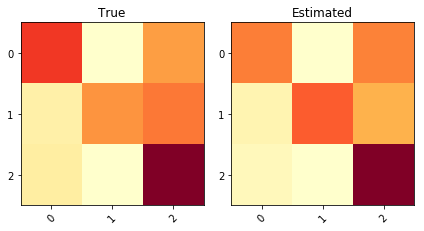

KL divergence: 0.0313	Pearson Correlation between diagonals: 0.8633


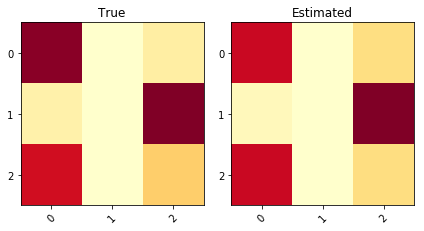

KL divergence: 0.0186	Pearson Correlation between diagonals: 0.9995


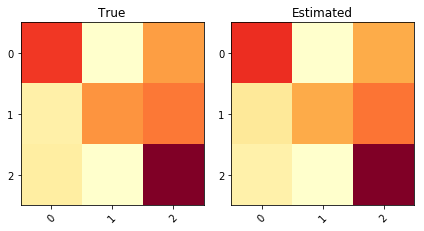

KL divergence: 0.0058	Pearson Correlation between diagonals: 0.9912


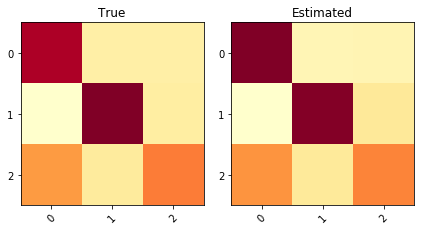

KL divergence: 0.0080	Pearson Correlation between diagonals: 0.9782


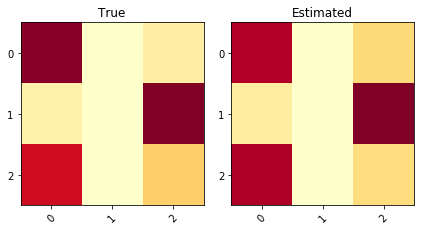

KL divergence: 0.0171	Pearson Correlation between diagonals: 0.9993


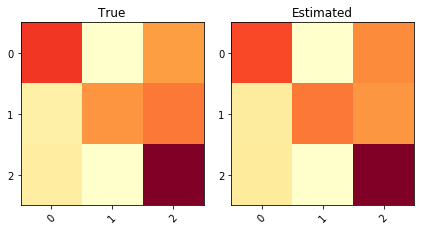

KL divergence: 0.0060	Pearson Correlation between diagonals: 0.9810


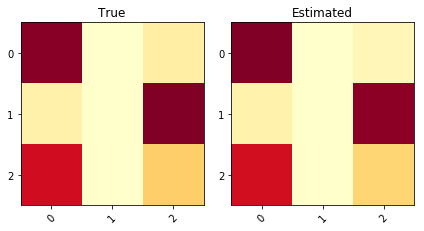

KL divergence: 0.0058	Pearson Correlation between diagonals: 0.9993


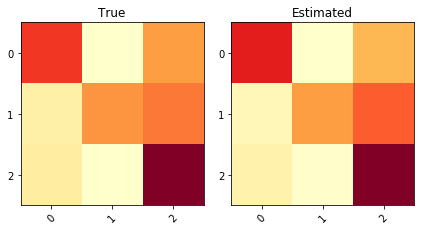

KL divergence: 0.0127	Pearson Correlation between diagonals: 0.9848
A result
 ====  ======  ==========  ============  =========  ==========  ==================
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  ==========  ==================
   0  Global    0.563696      0.563696  0.0132856  0.00254635             0.99066
====  ======  ==========  ============  =========  ==========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.556777      0.556777
====  ======  ==========  ============


In [57]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


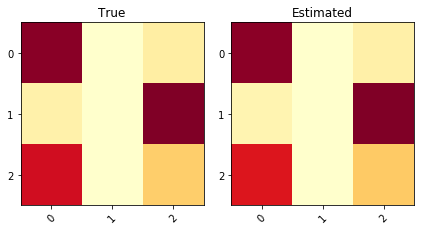

KL divergence: 0.0131	Pearson Correlation between diagonals: 0.9998


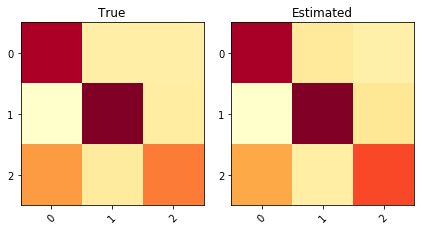

KL divergence: 0.0122	Pearson Correlation between diagonals: 0.9995


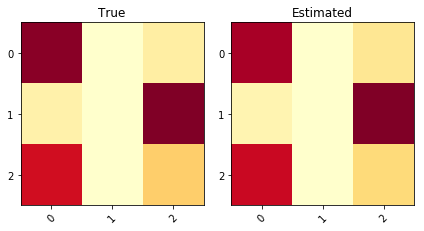

KL divergence: 0.0175	Pearson Correlation between diagonals: 0.9995


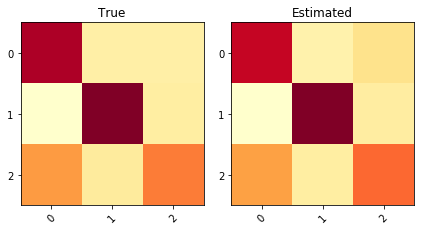

KL divergence: 0.0124	Pearson Correlation between diagonals: 0.9858


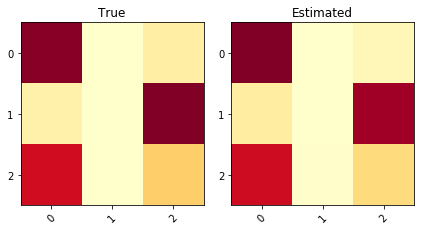

KL divergence: 0.0207	Pearson Correlation between diagonals: 0.9982


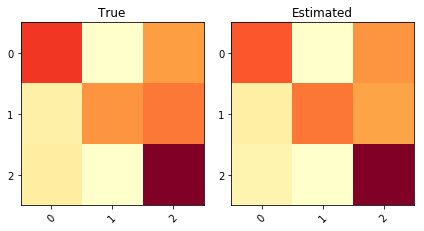

KL divergence: 0.0168	Pearson Correlation between diagonals: 0.9628


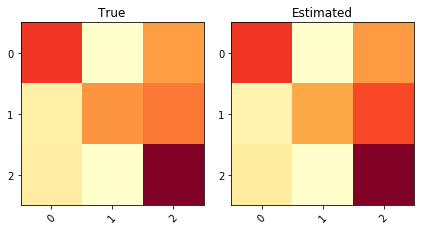

KL divergence: 0.0121	Pearson Correlation between diagonals: 0.9967


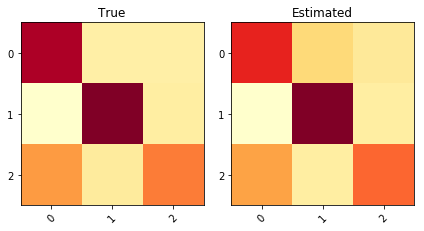

KL divergence: 0.0279	Pearson Correlation between diagonals: 0.8841


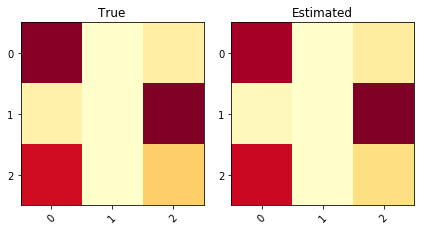

KL divergence: 0.0170	Pearson Correlation between diagonals: 0.9980


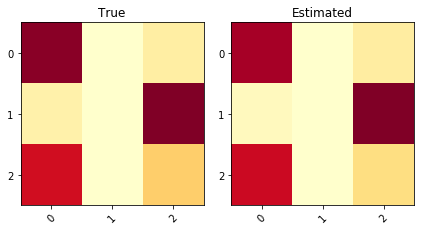

KL divergence: 0.0194	Pearson Correlation between diagonals: 0.9980


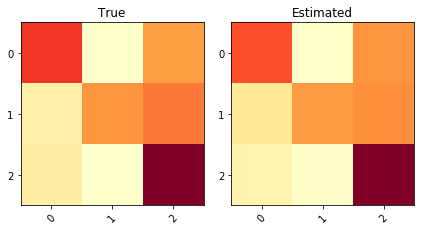

KL divergence: 0.0150	Pearson Correlation between diagonals: 0.9962


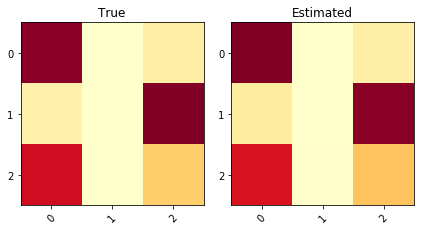

KL divergence: 0.0145	Pearson Correlation between diagonals: 0.9995


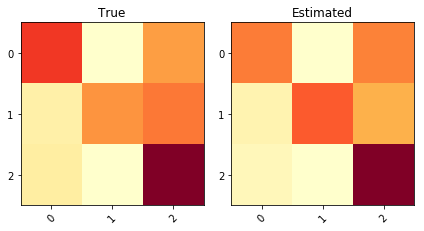

KL divergence: 0.0337	Pearson Correlation between diagonals: 0.8622


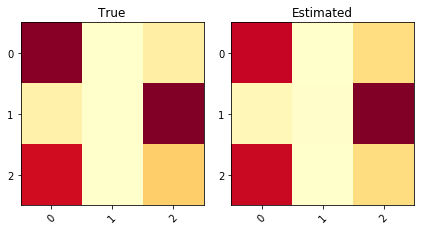

KL divergence: 0.0302	Pearson Correlation between diagonals: 0.9995


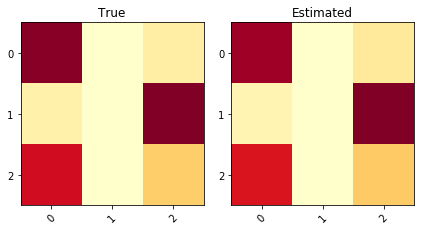

KL divergence: 0.0137	Pearson Correlation between diagonals: 0.9994
A result
 ====  ======  ==========  ============  =========  ==========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  ==========  ==================  ==============
   0  Global    0.869353      0.869353  0.0171091  0.00504889            0.989911         0.17495
====  ======  ==========  ============  =========  ==========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.705212                0.712247
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.

In [58]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture_Global.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (1) multiples runs***
Train


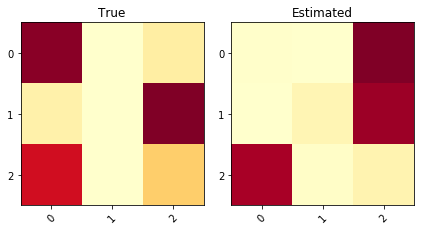

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


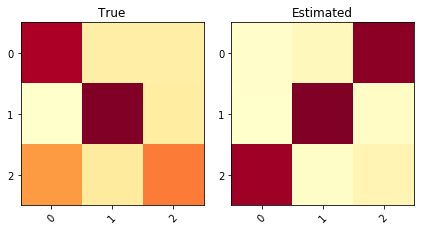

KL divergence: 1.5499	Pearson Correlation between diagonals: 0.6093


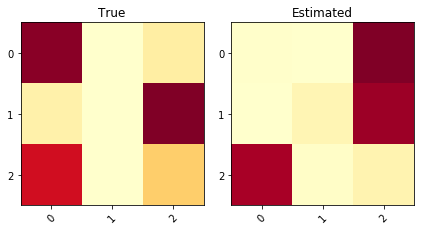

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


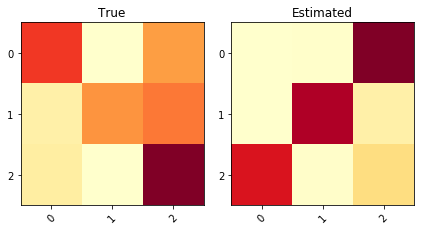

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


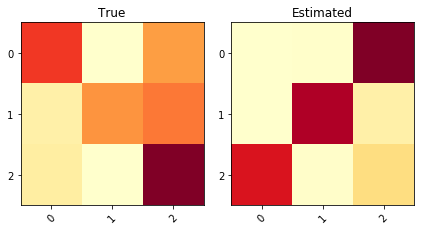

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


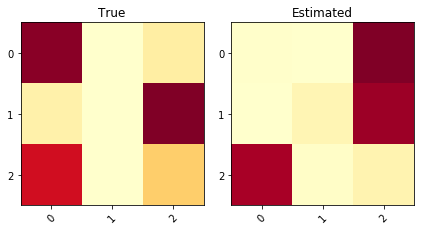

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


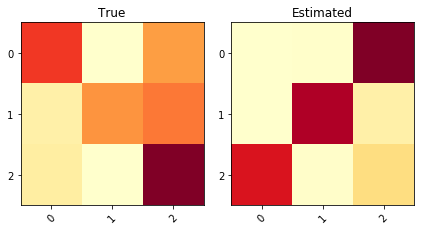

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


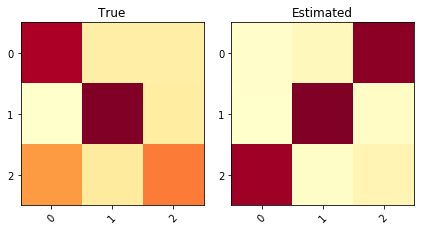

KL divergence: 1.5499	Pearson Correlation between diagonals: 0.6093


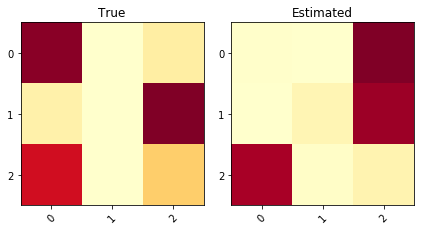

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


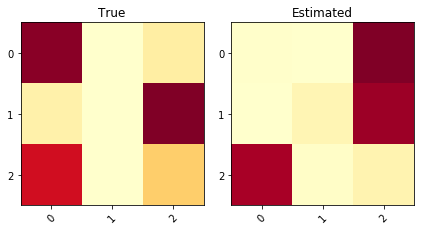

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


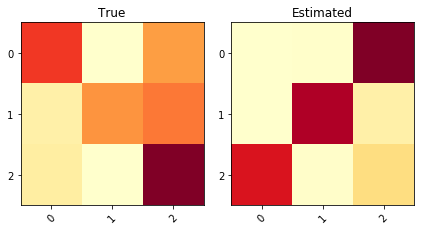

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


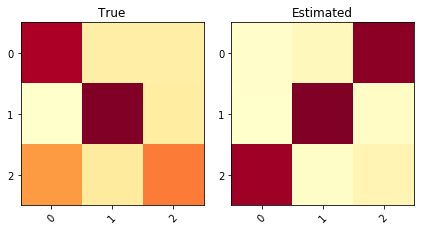

KL divergence: 1.5499	Pearson Correlation between diagonals: 0.6093


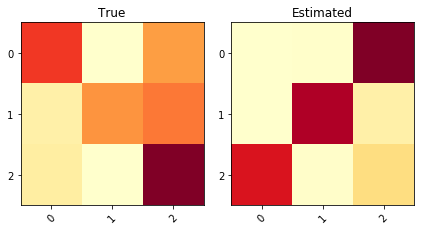

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


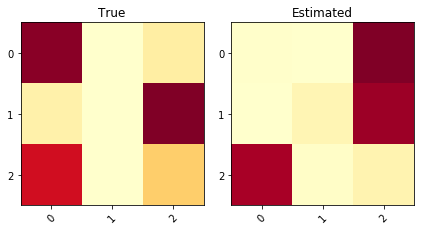

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


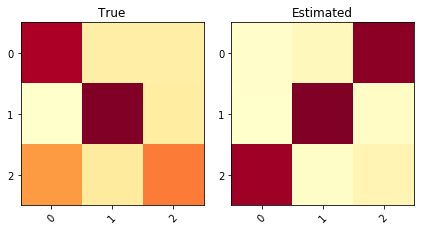

KL divergence: 1.5499	Pearson Correlation between diagonals: 0.6093
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.597884      0.597884     1.5097   0.208986           -0.348053        0.148848
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.680813                0.703747
====  =======================  ======================
Test


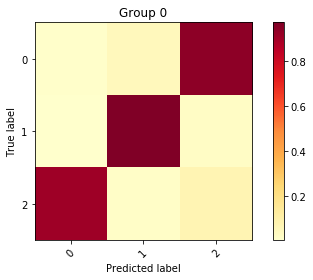

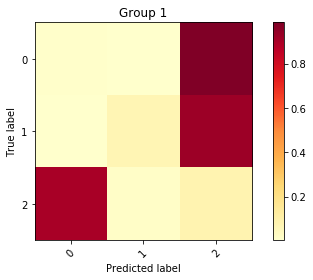

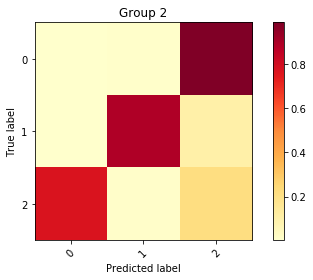

Inertia: 0.10848995065316558
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)     Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
   0         0  0.326825      32   0.232576    0.351229     2.55813       0.402764   0.0178953    0.711844      0.711844
   1         1  0.286561      28   0.236939    0.0529269    3.31976       0.14267   -0.280406     0.565324      0.565324
   2         2  0.386613      38   0.336965    0.371128     2.42394       0.457802   0.0377947    0.896215      0.896215
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  

In [59]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


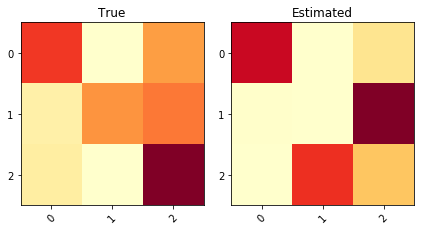

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


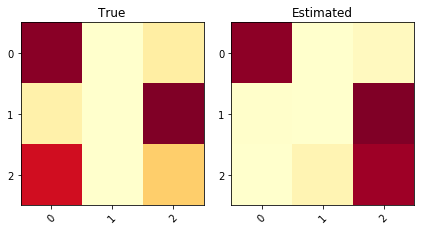

KL divergence: 1.3390	Pearson Correlation between diagonals: 0.7449


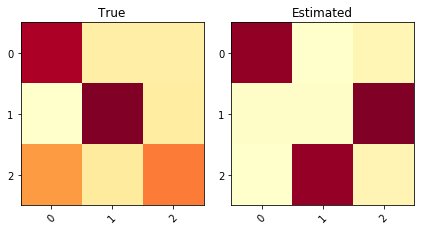

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


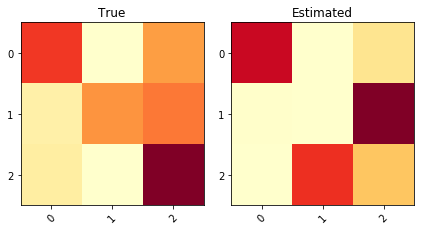

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


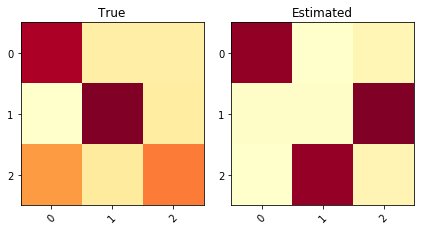

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


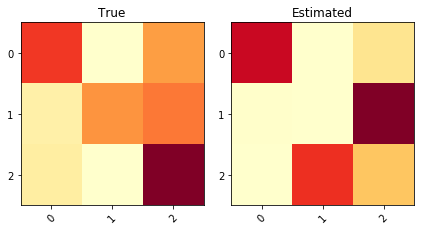

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


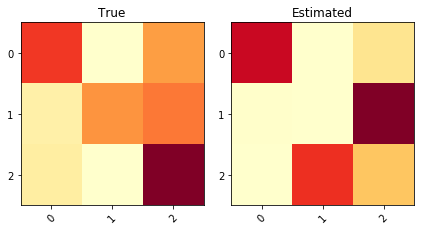

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


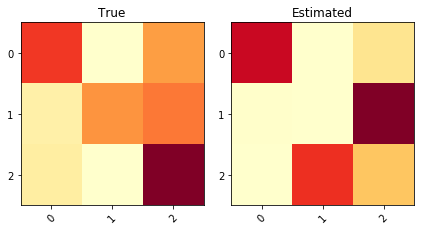

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


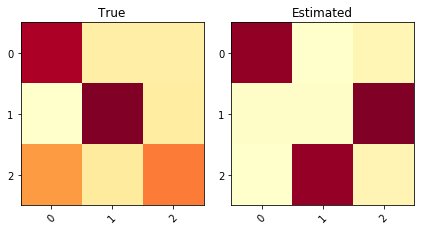

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


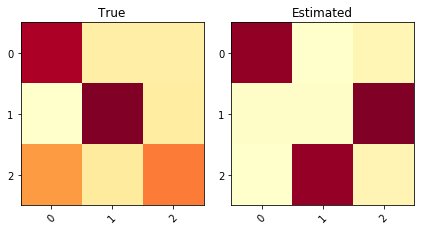

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


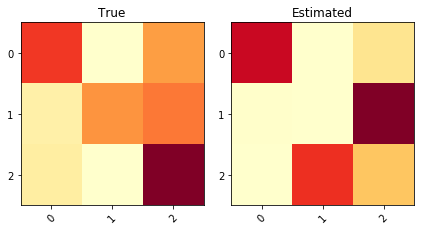

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


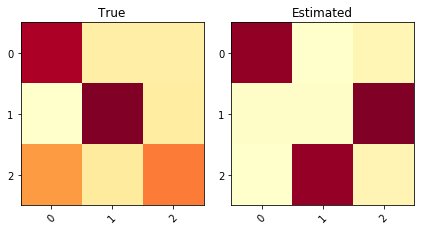

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


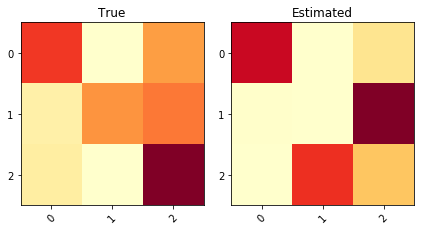

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


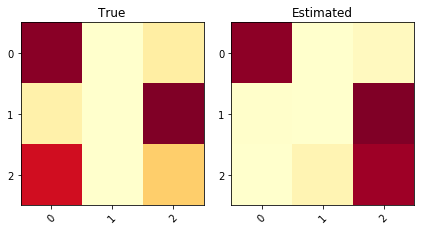

KL divergence: 1.3390	Pearson Correlation between diagonals: 0.7449


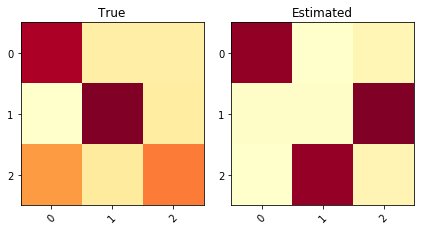

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.350834      0.350834     1.4957   0.205557            0.428808        0.150335
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.677046                0.699032
====  =======================  ======================
Test


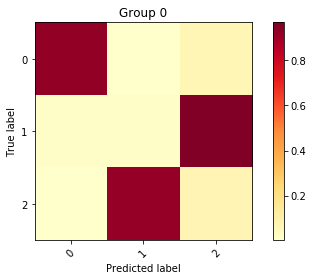

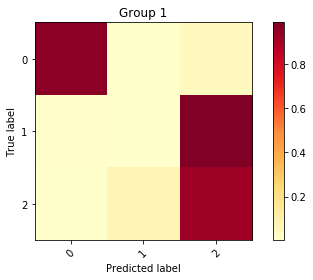

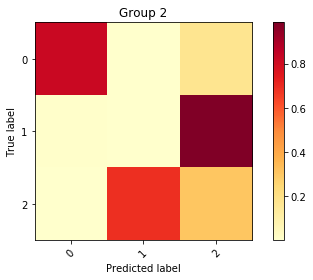

Inertia: 0.08358287128309409
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.300226      30   0.236477     0.338454    2.29225       0.403617  0.0051209    0.808303      0.808303
   1         1  0.337198      33   0.176395     0.628844    1.98815       0.651583  0.29551      0.579976      0.579976
   2         2  0.362576      36   0.398023     0.378613    2.25763       0.48055   0.0452801    0.796093      0.796093
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [60]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 3) configuration: normal soft ($T$ = 100, $T_{max}$ = 10, soft clustering )

In [77]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7806267806267806


*** Soft-Majority (Train with softMV) ***
Train


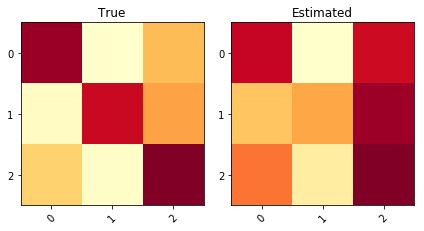

KL divergence: 0.2169	Pearson Correlation between diagonals: 0.9963


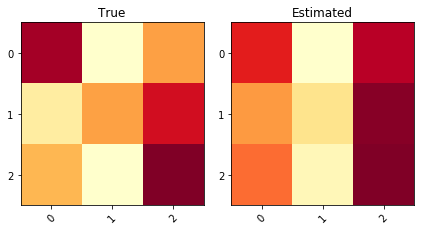

KL divergence: 0.1727	Pearson Correlation between diagonals: 0.9825


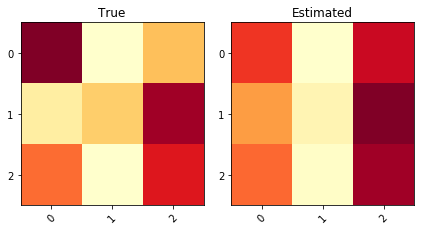

KL divergence: 0.1565	Pearson Correlation between diagonals: 0.8226


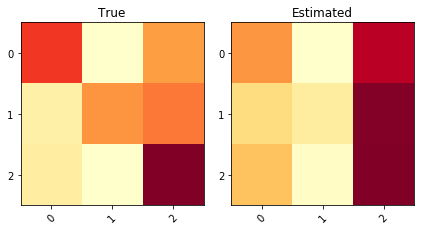

KL divergence: 0.2177	Pearson Correlation between diagonals: 1.0000


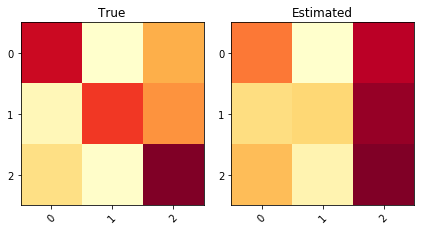

KL divergence: 0.2077	Pearson Correlation between diagonals: 0.9957


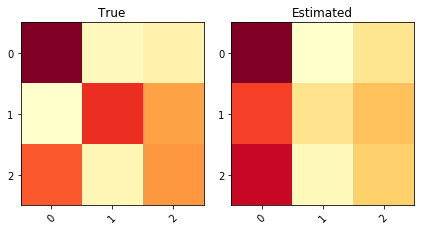

KL divergence: 0.2400	Pearson Correlation between diagonals: 0.8442


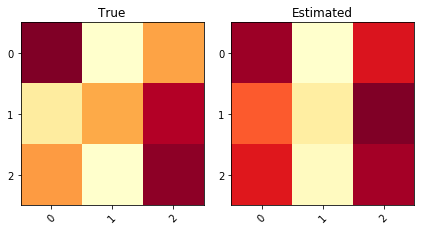

KL divergence: 0.1730	Pearson Correlation between diagonals: 0.9997


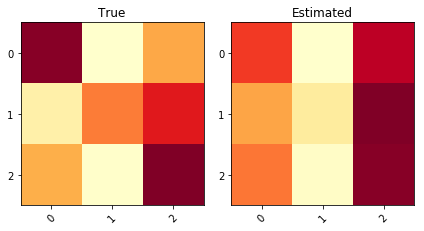

KL divergence: 0.1757	Pearson Correlation between diagonals: 0.9462


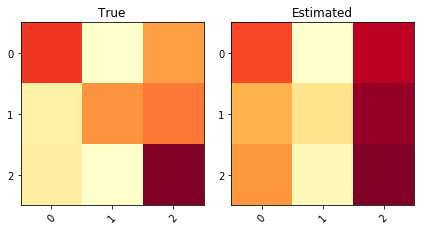

KL divergence: 0.2220	Pearson Correlation between diagonals: 0.9810


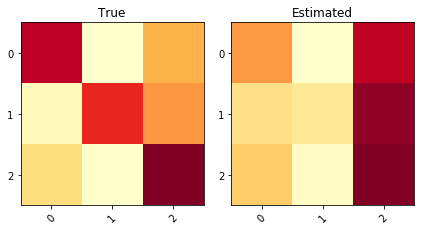

KL divergence: 0.2332	Pearson Correlation between diagonals: 0.9857


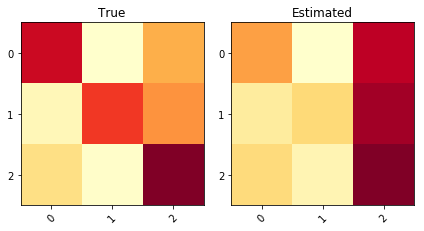

KL divergence: 0.2075	Pearson Correlation between diagonals: 0.9716


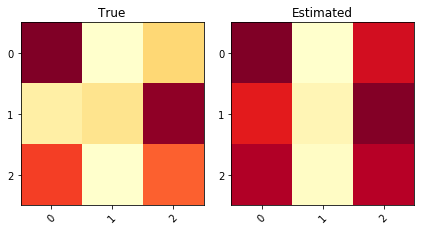

KL divergence: 0.1659	Pearson Correlation between diagonals: 0.9169


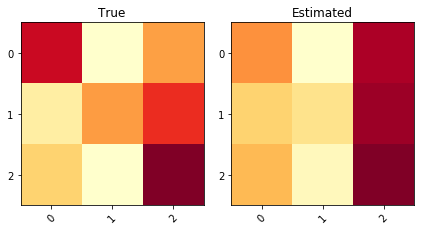

KL divergence: 0.1805	Pearson Correlation between diagonals: 0.9334


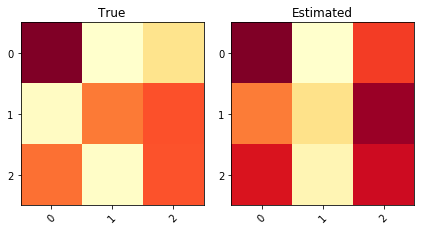

KL divergence: 0.1860	Pearson Correlation between diagonals: 0.7803


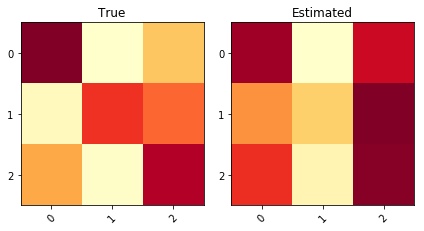

KL divergence: 0.1897	Pearson Correlation between diagonals: 0.9182
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.796907      0.796907   0.208223  0.0572833            0.896771
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.802198      0.802198
====  ======  ==========  ============


In [78]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


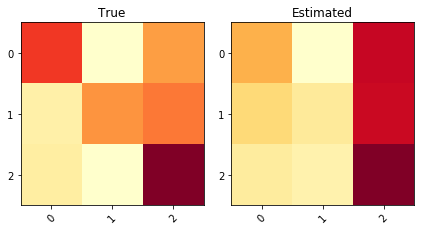

KL divergence: 0.2078	Pearson Correlation between diagonals: 0.9916


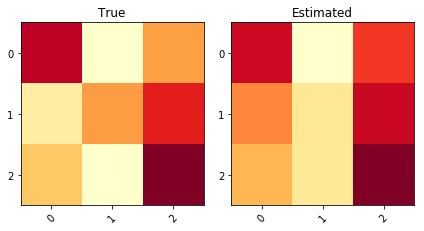

KL divergence: 0.1659	Pearson Correlation between diagonals: 0.9993


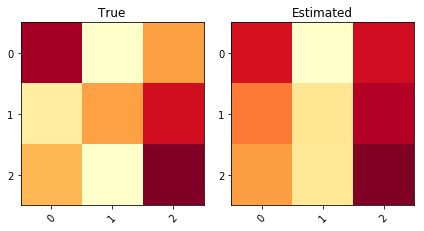

KL divergence: 0.1786	Pearson Correlation between diagonals: 0.9923


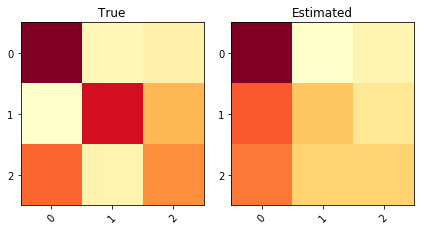

KL divergence: 0.2548	Pearson Correlation between diagonals: 0.8283


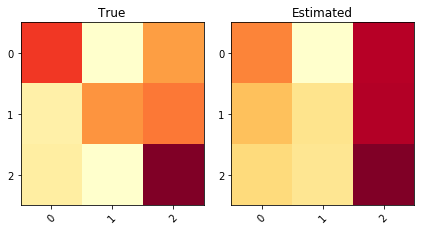

KL divergence: 0.2166	Pearson Correlation between diagonals: 0.9997


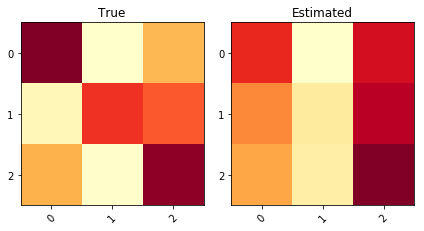

KL divergence: 0.2113	Pearson Correlation between diagonals: 0.9114


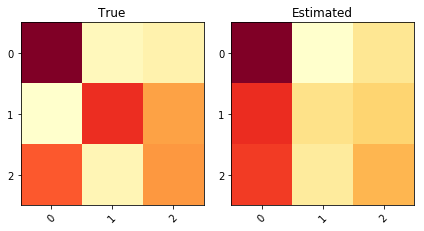

KL divergence: 0.2495	Pearson Correlation between diagonals: 0.7919


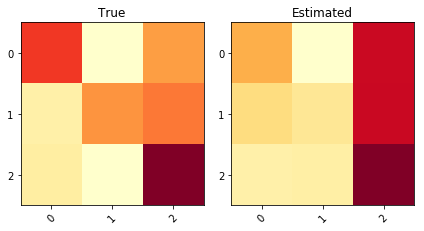

KL divergence: 0.2025	Pearson Correlation between diagonals: 0.9908


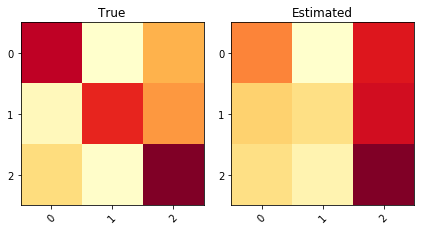

KL divergence: 0.2089	Pearson Correlation between diagonals: 0.9917


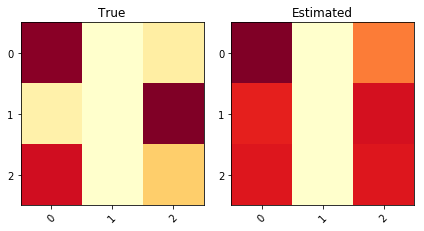

KL divergence: 0.2160	Pearson Correlation between diagonals: 0.8586


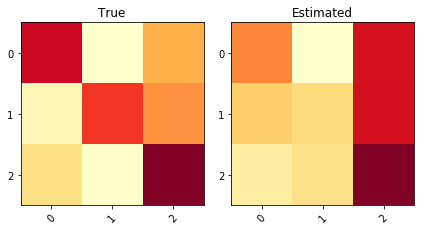

KL divergence: 0.2065	Pearson Correlation between diagonals: 0.9936


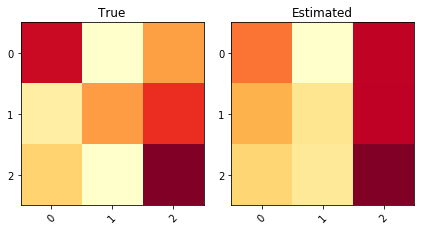

KL divergence: 0.1864	Pearson Correlation between diagonals: 0.9637


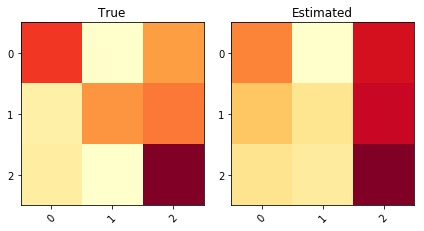

KL divergence: 0.2014	Pearson Correlation between diagonals: 0.9993


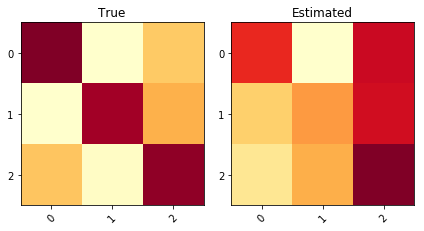

KL divergence: 0.2408	Pearson Correlation between diagonals: 0.5087


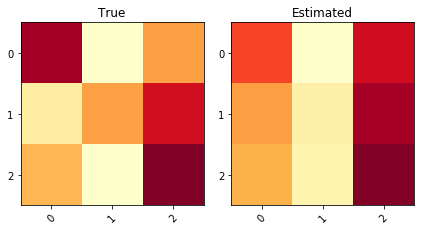

KL divergence: 0.1714	Pearson Correlation between diagonals: 0.9624
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.717135      0.717135   0.207053  0.0576954            0.893502
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.726496      0.726496
====  ======  ==========  ============


In [80]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


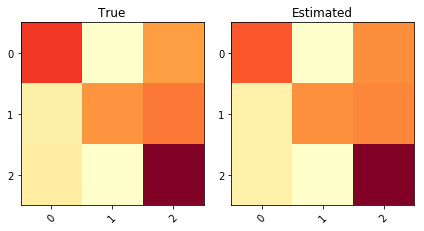

KL divergence: 0.0031	Pearson Correlation between diagonals: 0.9838


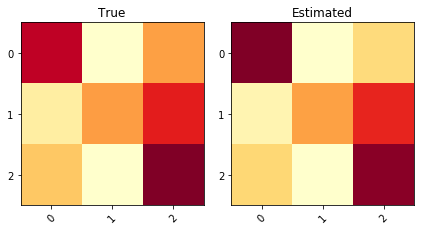

KL divergence: 0.0233	Pearson Correlation between diagonals: 0.9652


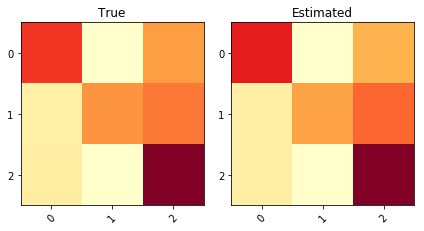

KL divergence: 0.0037	Pearson Correlation between diagonals: 0.9836


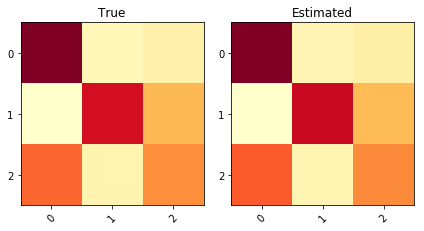

KL divergence: 0.0833	Pearson Correlation between diagonals: 0.9979


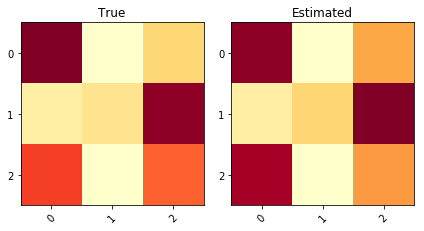

KL divergence: 0.0242	Pearson Correlation between diagonals: 0.9688


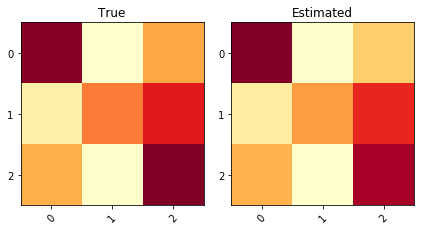

KL divergence: 0.0076	Pearson Correlation between diagonals: 0.9857


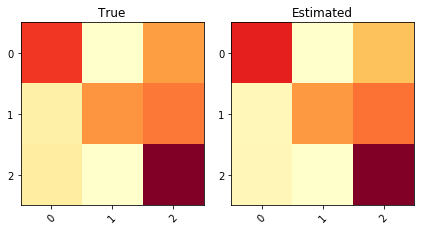

KL divergence: 0.0168	Pearson Correlation between diagonals: 0.9897


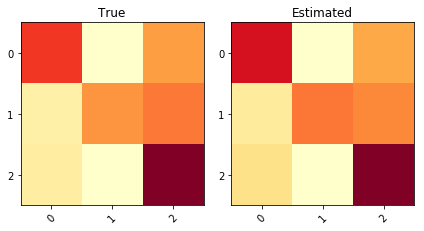

KL divergence: 0.0093	Pearson Correlation between diagonals: 0.9846


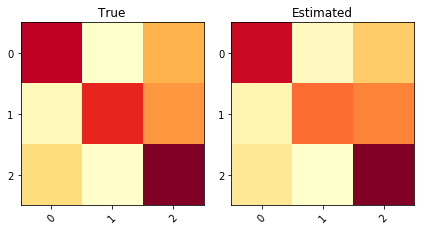

KL divergence: 0.0134	Pearson Correlation between diagonals: 0.9921


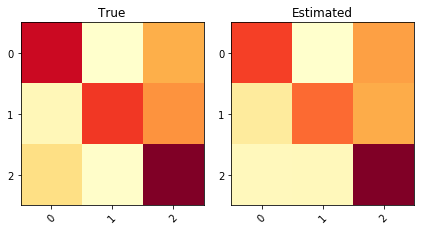

KL divergence: 0.0484	Pearson Correlation between diagonals: 0.9598


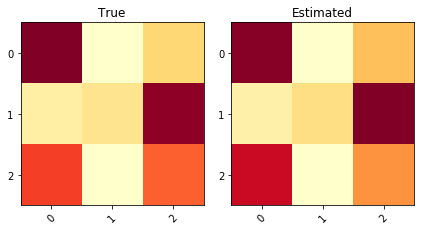

KL divergence: 0.0106	Pearson Correlation between diagonals: 0.9851


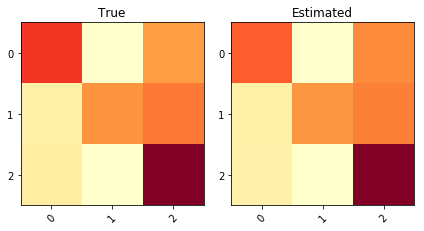

KL divergence: 0.0034	Pearson Correlation between diagonals: 0.9867


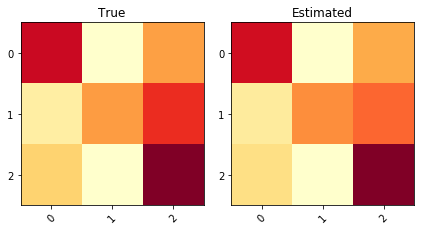

KL divergence: 0.0060	Pearson Correlation between diagonals: 0.9970


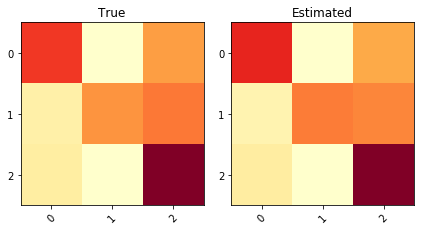

KL divergence: 0.0033	Pearson Correlation between diagonals: 0.9997


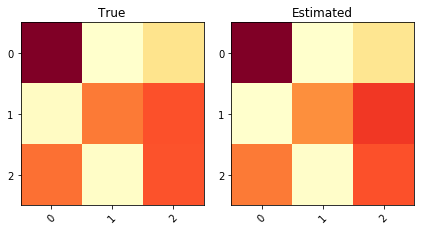

KL divergence: 0.0022	Pearson Correlation between diagonals: 0.9960
A result
 ====  ======  ==========  ============  =========  ==========  ==================
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  ==========  ==================
   0  Global    0.885226      0.885226  0.0184842  0.00325279            0.943187
====  ======  ==========  ============  =========  ==========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.881563      0.881563
====  ======  ==========  ============


In [82]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


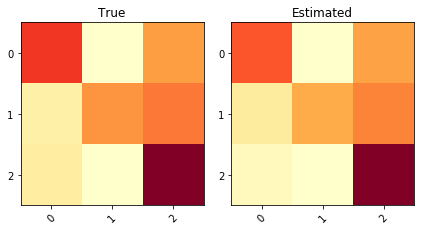

KL divergence: 0.0199	Pearson Correlation between diagonals: 0.9996


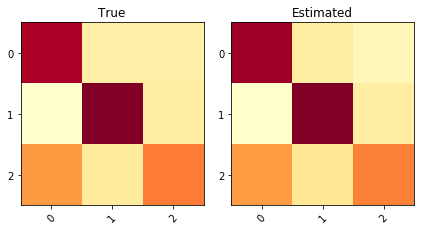

KL divergence: 0.0083	Pearson Correlation between diagonals: 0.9972


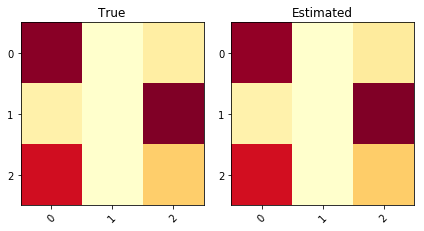

KL divergence: 0.0138	Pearson Correlation between diagonals: 0.9999


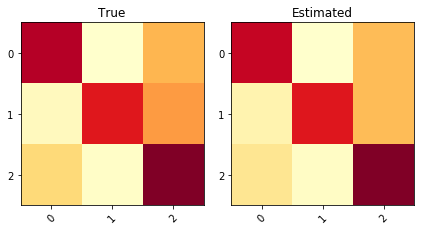

KL divergence: 0.0075	Pearson Correlation between diagonals: 0.9769


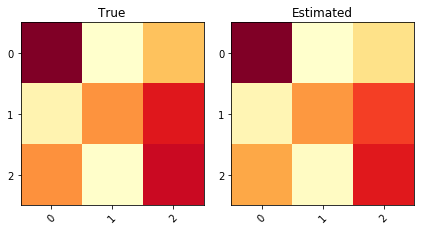

KL divergence: 0.0088	Pearson Correlation between diagonals: 0.9907


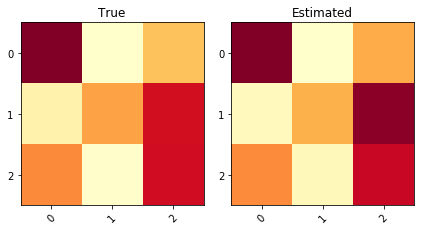

KL divergence: 0.0146	Pearson Correlation between diagonals: 0.9971


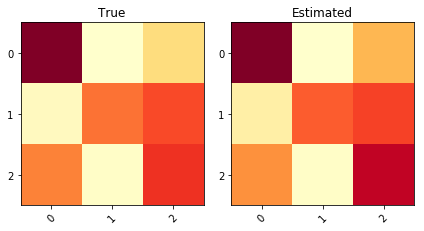

KL divergence: 0.0121	Pearson Correlation between diagonals: 0.9281


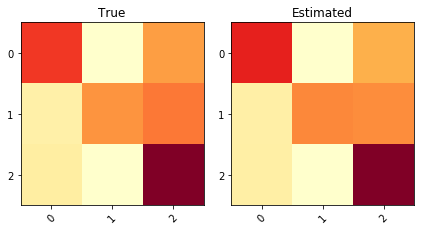

KL divergence: 0.0112	Pearson Correlation between diagonals: 0.9973


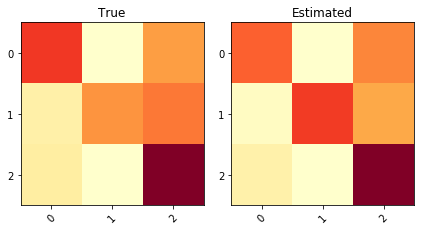

KL divergence: 0.0379	Pearson Correlation between diagonals: 0.8348


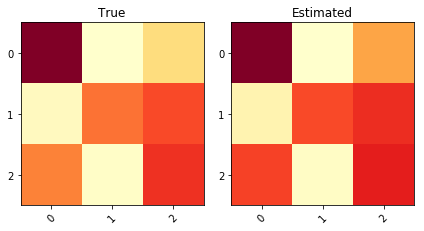

KL divergence: 0.0104	Pearson Correlation between diagonals: 0.9998


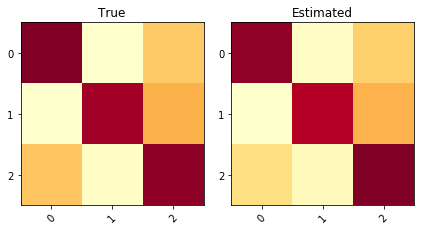

KL divergence: 0.0055	Pearson Correlation between diagonals: 0.6911


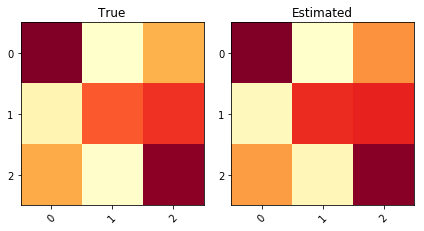

KL divergence: 0.0098	Pearson Correlation between diagonals: 1.0000


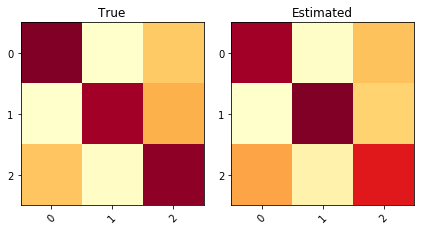

KL divergence: 0.0159	Pearson Correlation between diagonals: -0.3234


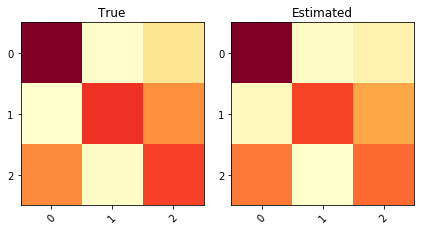

KL divergence: 0.0127	Pearson Correlation between diagonals: 0.9972


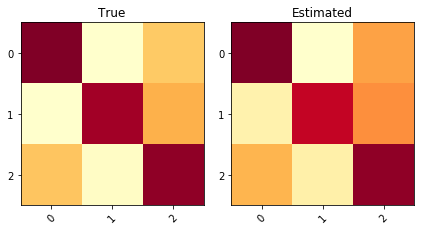

KL divergence: 0.0138	Pearson Correlation between diagonals: 0.9607
A result
 ====  ======  ==========  ============  =========  ==========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  ==========  ==================  ==============
   0  Global    0.858364      0.858364  0.0156616  0.00416836            0.883169       0.0800129
====  ======  ==========  ============  =========  ==========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.618361                0.850753
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.85

In [12]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture_Global.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (1) multiples runs***
Train


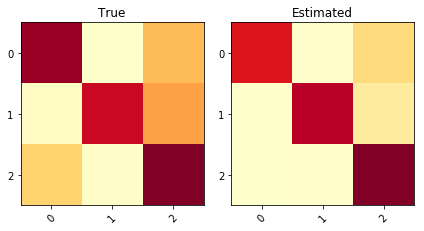

KL divergence: 0.3232	Pearson Correlation between diagonals: 0.3613


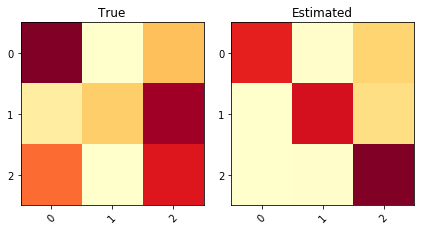

KL divergence: 0.8276	Pearson Correlation between diagonals: -0.0154


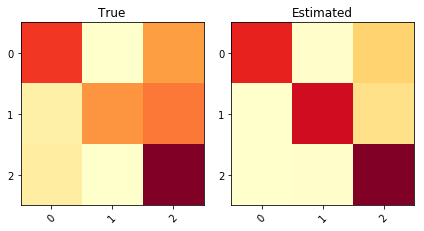

KL divergence: 0.2438	Pearson Correlation between diagonals: 0.7721


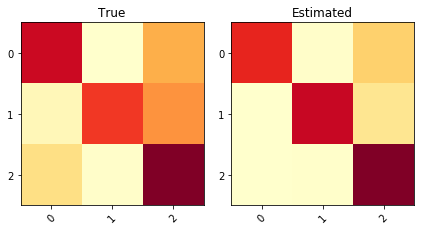

KL divergence: 0.2599	Pearson Correlation between diagonals: 0.6147


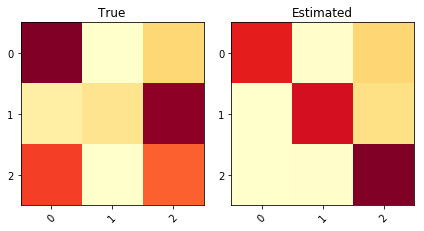

KL divergence: 1.0898	Pearson Correlation between diagonals: -0.2214


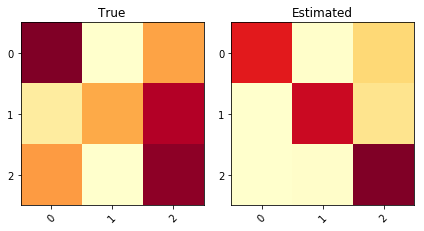

KL divergence: 0.6288	Pearson Correlation between diagonals: 0.1700


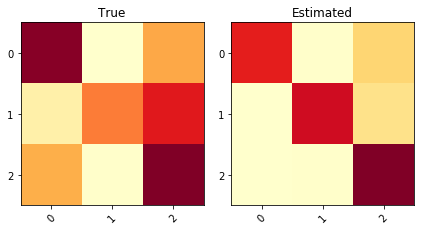

KL divergence: 0.4777	Pearson Correlation between diagonals: 0.2675


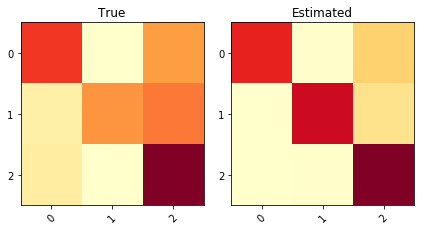

KL divergence: 0.2488	Pearson Correlation between diagonals: 0.7393


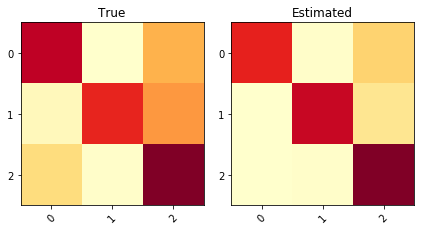

KL divergence: 0.2724	Pearson Correlation between diagonals: 0.6012


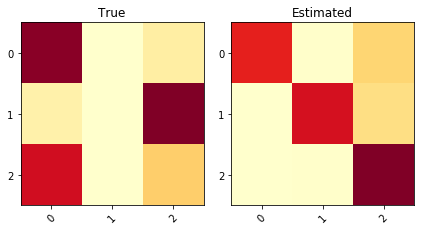

KL divergence: 1.7259	Pearson Correlation between diagonals: -0.4344


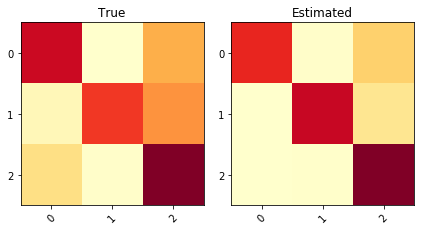

KL divergence: 0.2591	Pearson Correlation between diagonals: 0.6131


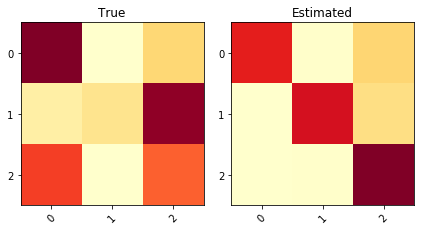

KL divergence: 1.0866	Pearson Correlation between diagonals: -0.2120


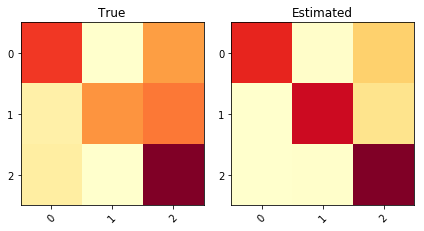

KL divergence: 0.2478	Pearson Correlation between diagonals: 0.7236


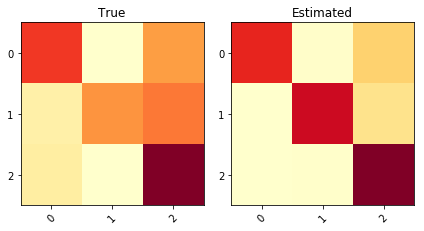

KL divergence: 0.2480	Pearson Correlation between diagonals: 0.7300


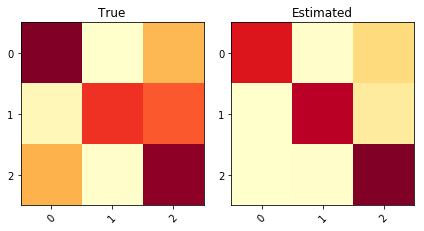

KL divergence: 0.4554	Pearson Correlation between diagonals: -0.0444
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.820513      0.820513   0.520173  0.0737737           0.0394929       0.0691972
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.620714                0.792509
====  =======================  ======================
Test


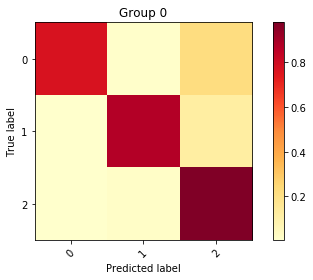

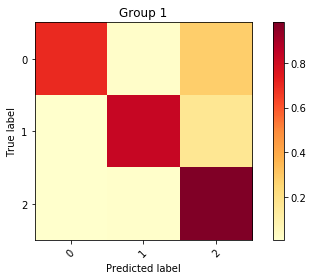

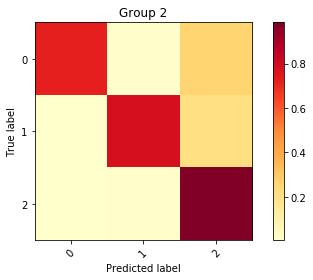

Inertia: 0.001852757598195846
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.367625      36   0.364847     0.874186   0.139261       0.932436   0.540853    0.769231      0.769231
   1         1  0.268373      26   0.415645     0.838624   0.185258       0.911159   0.50529     0.688645      0.688645
   2         2  0.364003      36   0.42033      0.831836   0.192676       0.907515   0.498502    0.661783      0.661783
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ======

In [84]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


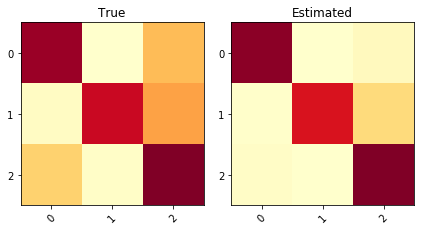

KL divergence: 0.3171	Pearson Correlation between diagonals: 0.9744


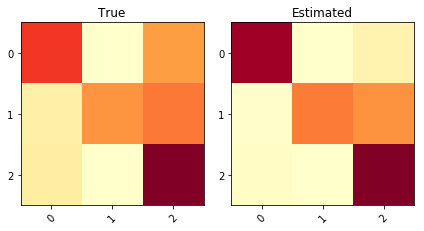

KL divergence: 0.1976	Pearson Correlation between diagonals: 0.8653


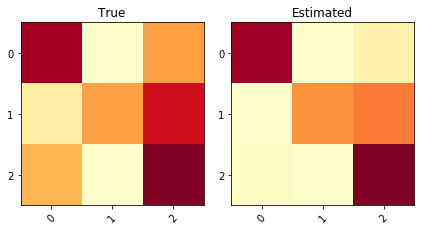

KL divergence: 0.2630	Pearson Correlation between diagonals: 1.0000


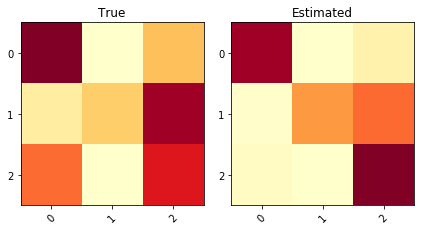

KL divergence: 0.3929	Pearson Correlation between diagonals: 0.9058


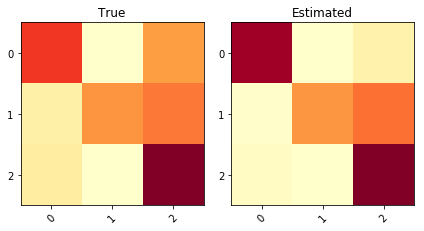

KL divergence: 0.1846	Pearson Correlation between diagonals: 0.8607


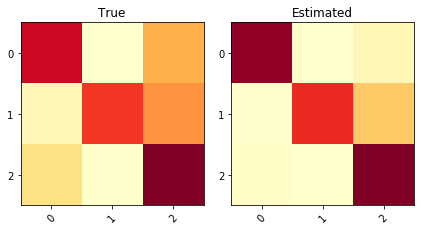

KL divergence: 0.2575	Pearson Correlation between diagonals: 0.9122


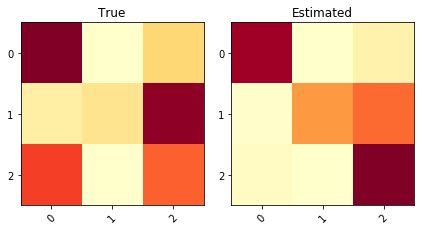

KL divergence: 0.5243	Pearson Correlation between diagonals: 0.8034


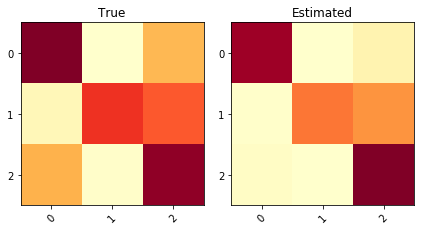

KL divergence: 0.2616	Pearson Correlation between diagonals: 0.9753


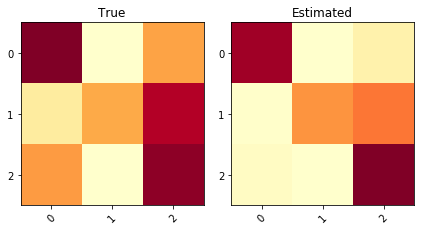

KL divergence: 0.3003	Pearson Correlation between diagonals: 0.9871


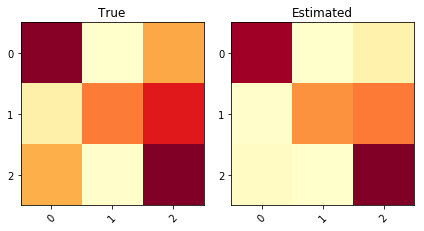

KL divergence: 0.2502	Pearson Correlation between diagonals: 0.9966


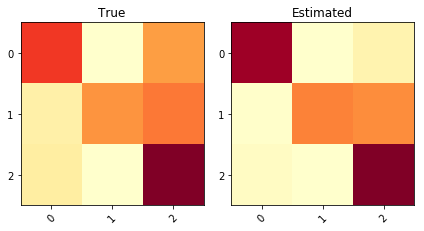

KL divergence: 0.1947	Pearson Correlation between diagonals: 0.8643


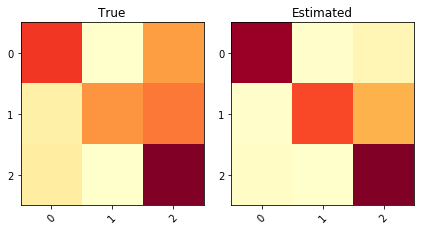

KL divergence: 0.2346	Pearson Correlation between diagonals: 0.8737


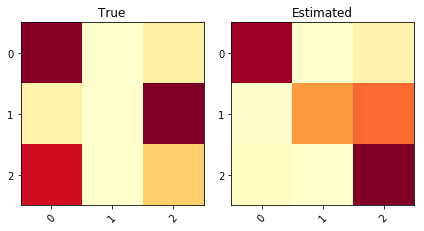

KL divergence: 0.9132	Pearson Correlation between diagonals: 0.6389


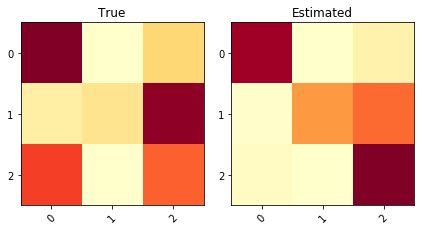

KL divergence: 0.5243	Pearson Correlation between diagonals: 0.8034


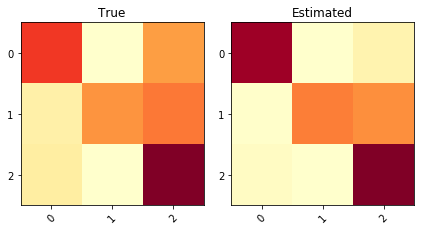

KL divergence: 0.1963	Pearson Correlation between diagonals: 0.8649
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.922263      0.922263   0.353131  0.0592165            0.703907       0.0559583
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.634365                0.789554
====  =======================  ======================
Test


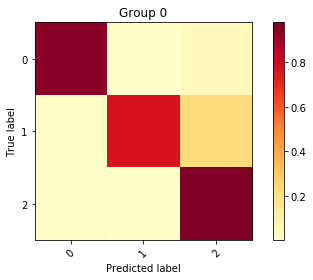

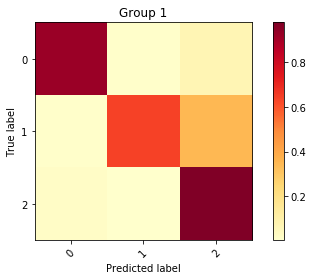

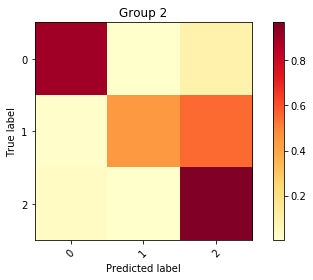

Inertia: 0.010852160902383426
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.389124      38   0.295749     0.899965   0.111069       0.946175   0.566631    0.879121      0.879121
   1         1  0.270756      27   0.367987     0.847832   0.18157        0.914092   0.514498    0.726496      0.726496
   2         2  0.34012       34   0.405299     0.770491   0.31794        0.857818   0.437158    0.649573      0.649573
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ======

In [85]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 4) configuration: Manny annot v1 ($T$ = 2000, $T_{max}$ = 20 )

In [99]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7806267806267806


*** Soft-Majority (Train with softMV) ***
Train


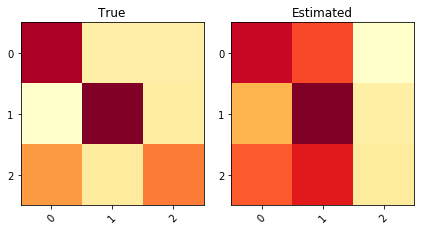

KL divergence: 0.3287	Pearson Correlation between diagonals: 0.9998


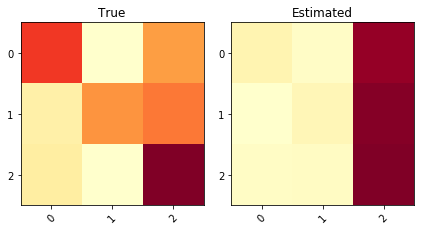

KL divergence: 0.3117	Pearson Correlation between diagonals: 0.9271


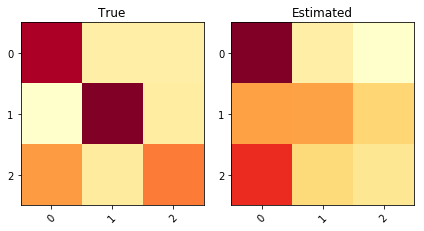

KL divergence: 0.3246	Pearson Correlation between diagonals: 0.5972


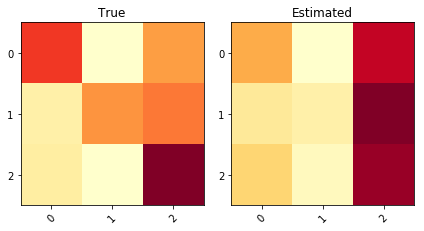

KL divergence: 0.2315	Pearson Correlation between diagonals: 0.9988


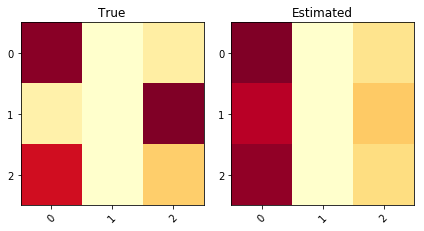

KL divergence: 0.3371	Pearson Correlation between diagonals: 0.9969


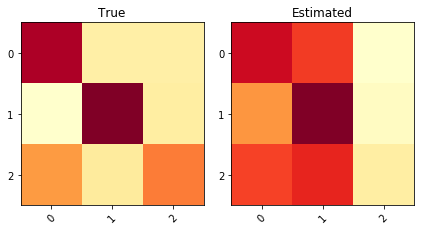

KL divergence: 0.3481	Pearson Correlation between diagonals: 1.0000


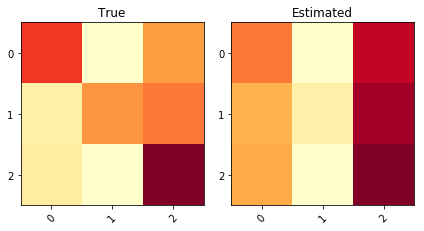

KL divergence: 0.2244	Pearson Correlation between diagonals: 0.9931


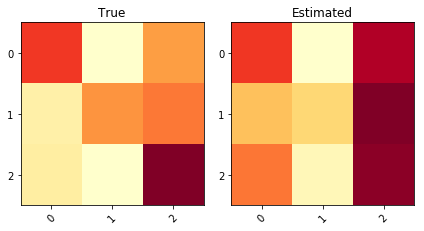

KL divergence: 0.2361	Pearson Correlation between diagonals: 0.9726


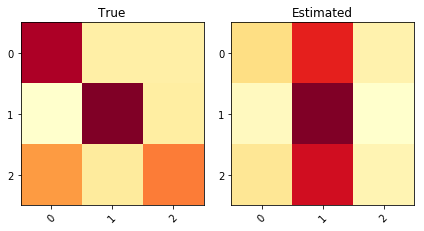

KL divergence: 0.4834	Pearson Correlation between diagonals: 0.7558


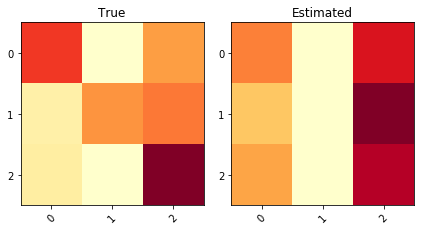

KL divergence: 2.1248	Pearson Correlation between diagonals: 0.9728


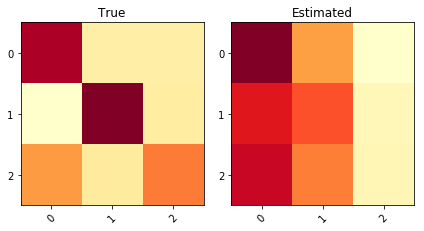

KL divergence: 0.3907	Pearson Correlation between diagonals: 0.8198


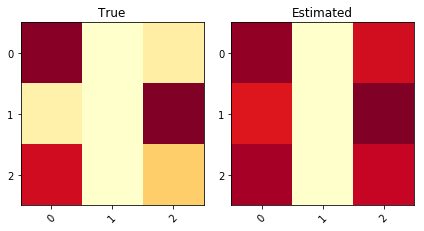

KL divergence: 0.2311	Pearson Correlation between diagonals: 0.7933


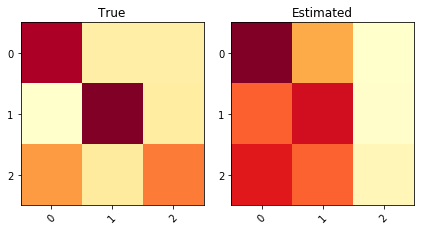

KL divergence: 0.3807	Pearson Correlation between diagonals: 0.9245


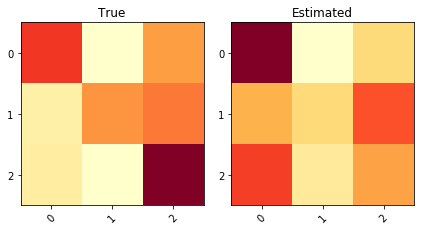

KL divergence: 0.3544	Pearson Correlation between diagonals: 0.1098


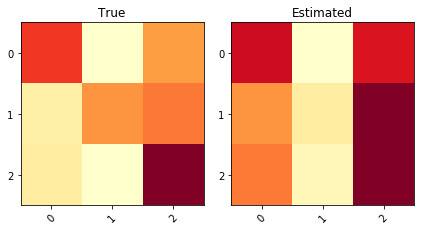

KL divergence: 0.2527	Pearson Correlation between diagonals: 0.8976
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.796907      0.796907   0.322981   0.077249            0.844747
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.802198      0.802198
====  ======  ==========  ============


In [100]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


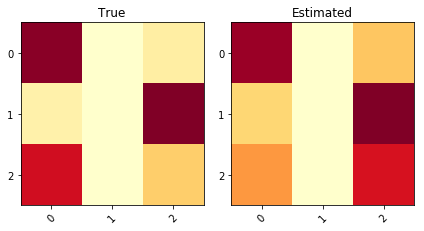

KL divergence: 0.1346	Pearson Correlation between diagonals: 0.8187


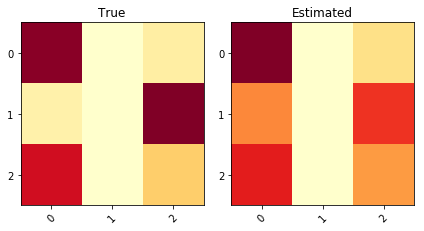

KL divergence: 0.1104	Pearson Correlation between diagonals: 0.9837


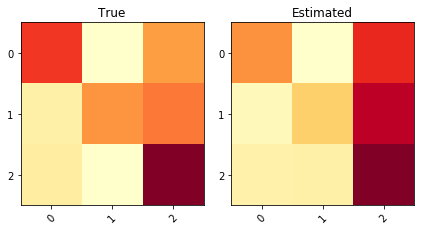

KL divergence: 0.1163	Pearson Correlation between diagonals: 0.9933


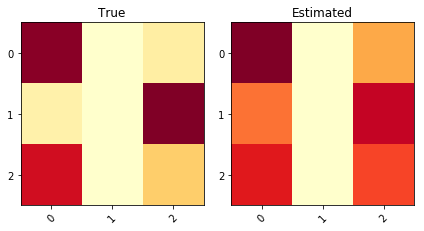

KL divergence: 0.1428	Pearson Correlation between diagonals: 0.9187


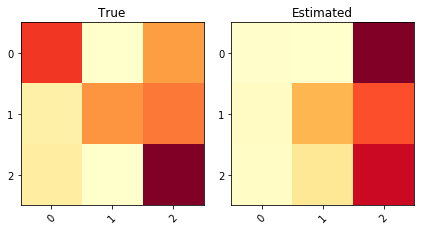

KL divergence: 0.3511	Pearson Correlation between diagonals: 0.6671


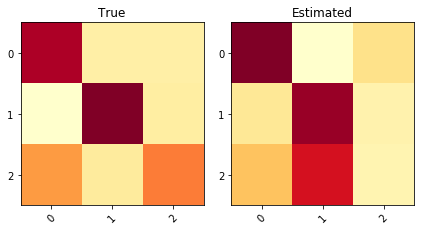

KL divergence: 0.2662	Pearson Correlation between diagonals: 0.9703


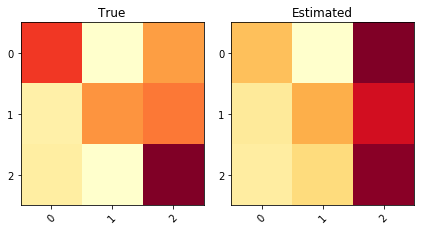

KL divergence: 0.1885	Pearson Correlation between diagonals: 0.8902


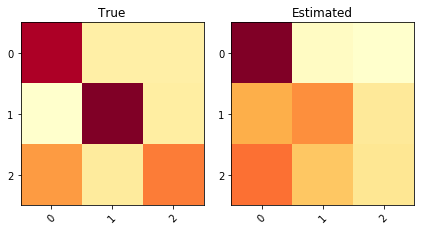

KL divergence: 0.2864	Pearson Correlation between diagonals: 0.6677


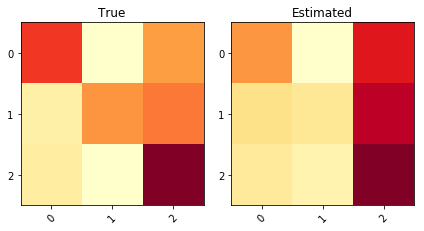

KL divergence: 0.1477	Pearson Correlation between diagonals: 0.9996


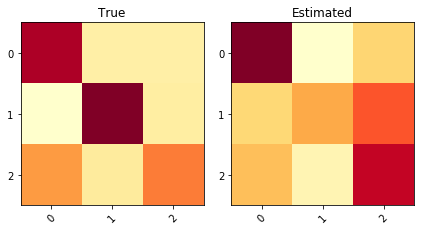

KL divergence: 0.2979	Pearson Correlation between diagonals: -0.4608


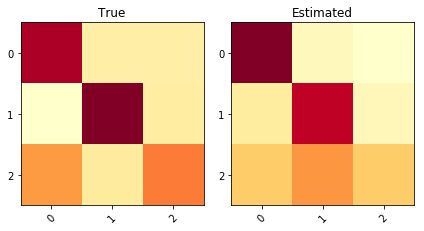

KL divergence: 0.1763	Pearson Correlation between diagonals: 0.9318


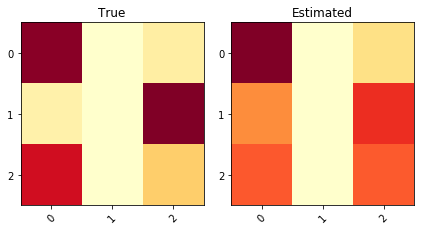

KL divergence: 0.1358	Pearson Correlation between diagonals: 0.9388


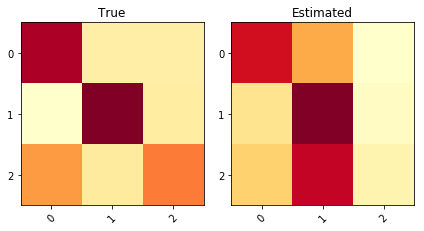

KL divergence: 0.4241	Pearson Correlation between diagonals: 1.0000


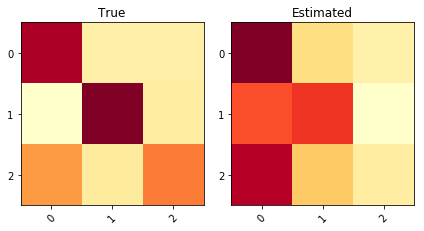

KL divergence: 0.3089	Pearson Correlation between diagonals: 0.8490


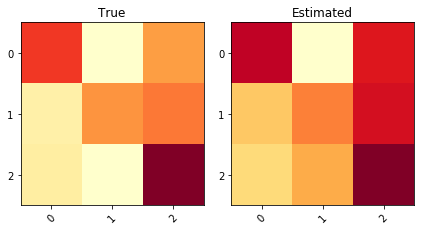

KL divergence: 0.1528	Pearson Correlation between diagonals: 0.9358
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.62963       0.62963   0.217562  0.0520236            0.833282
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.654457      0.654457
====  ======  ==========  ============


In [104]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


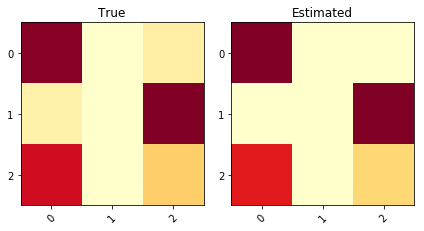

KL divergence: 0.8179	Pearson Correlation between diagonals: 0.9991


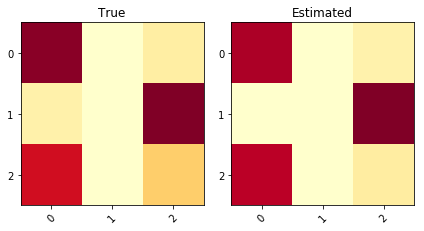

KL divergence: 0.3867	Pearson Correlation between diagonals: 0.9876


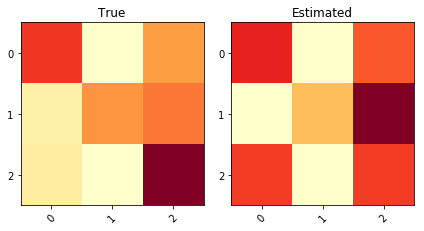

KL divergence: 0.5430	Pearson Correlation between diagonals: 0.7008


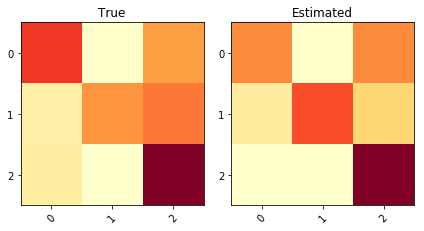

KL divergence: 0.5037	Pearson Correlation between diagonals: 0.8028


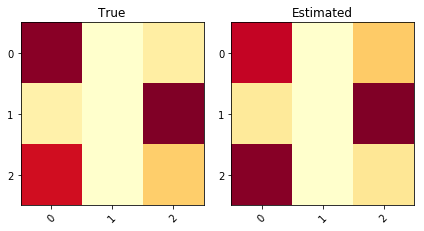

KL divergence: 0.0432	Pearson Correlation between diagonals: 0.9941


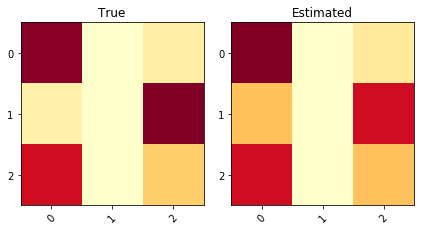

KL divergence: 0.0419	Pearson Correlation between diagonals: 0.9992


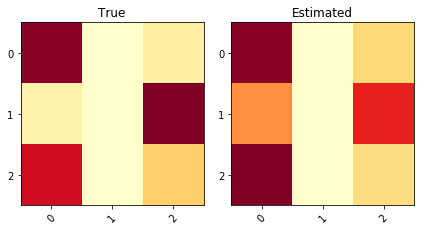

KL divergence: 0.1010	Pearson Correlation between diagonals: 0.9978


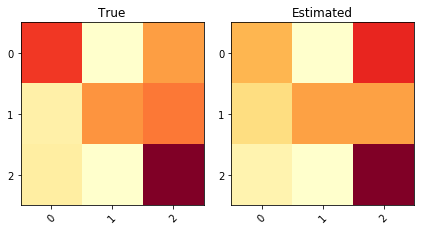

KL divergence: 0.0692	Pearson Correlation between diagonals: 0.8778


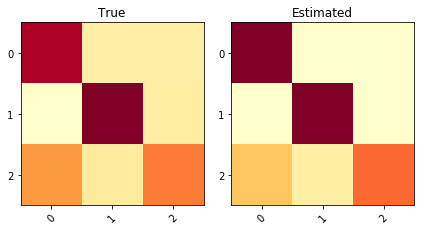

KL divergence: 1.2776	Pearson Correlation between diagonals: 0.9813


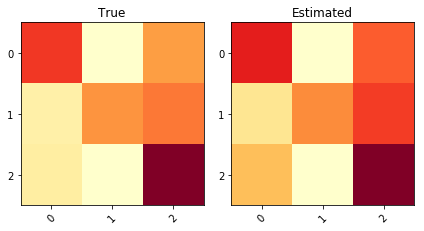

KL divergence: 0.0272	Pearson Correlation between diagonals: 0.9943


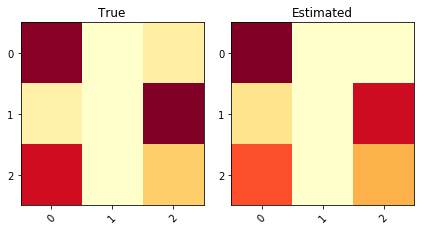

KL divergence: 0.4402	Pearson Correlation between diagonals: 0.9954


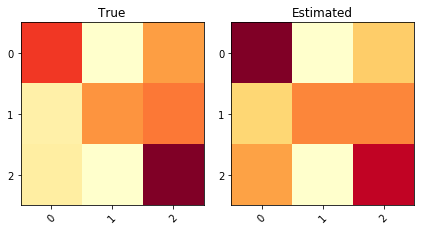

KL divergence: 0.0872	Pearson Correlation between diagonals: 0.5889


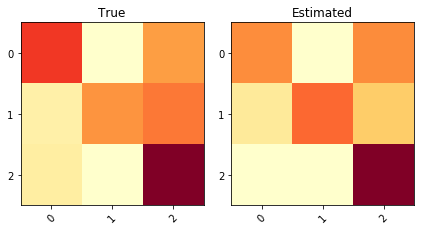

KL divergence: 0.4909	Pearson Correlation between diagonals: 0.8625


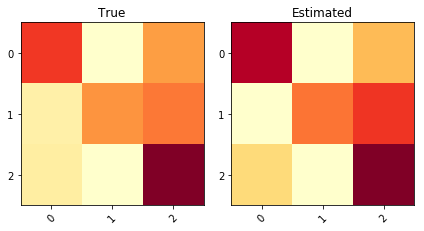

KL divergence: 0.4077	Pearson Correlation between diagonals: 0.9155


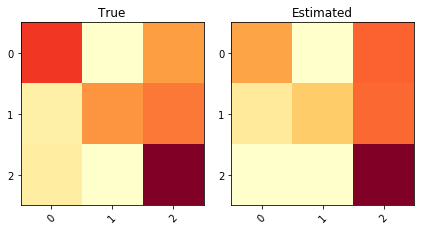

KL divergence: 0.4934	Pearson Correlation between diagonals: 0.9752
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.934473      0.934473   0.701537  0.0317218            0.854718
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.942613      0.942613
====  ======  ==========  ============


In [106]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


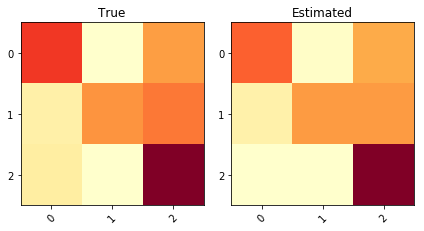

KL divergence: 0.0573	Pearson Correlation between diagonals: 0.9882


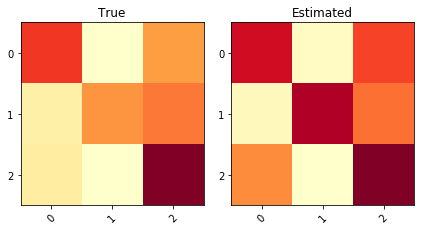

KL divergence: 0.1206	Pearson Correlation between diagonals: 0.6597


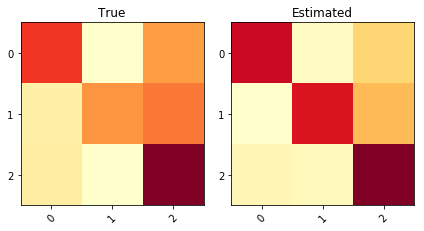

KL divergence: 0.1029	Pearson Correlation between diagonals: 0.9853


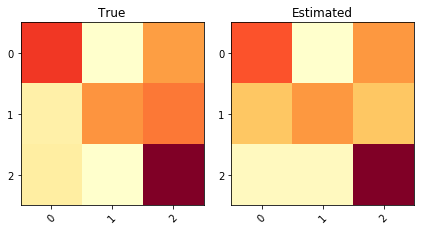

KL divergence: 0.1331	Pearson Correlation between diagonals: 0.9934


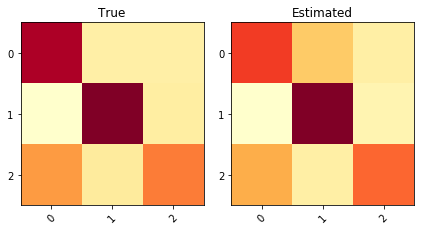

KL divergence: 0.0685	Pearson Correlation between diagonals: 0.8025


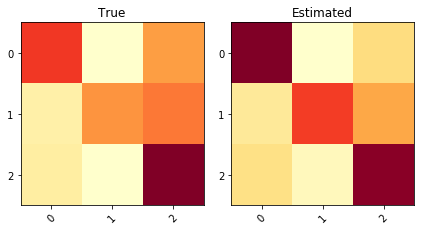

KL divergence: 0.1162	Pearson Correlation between diagonals: 0.7569


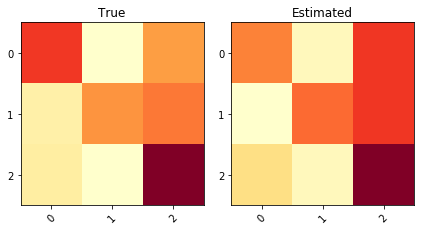

KL divergence: 0.1045	Pearson Correlation between diagonals: 0.8859


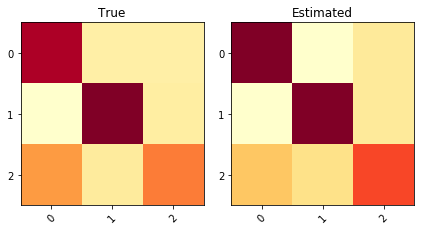

KL divergence: 0.0679	Pearson Correlation between diagonals: 0.9813


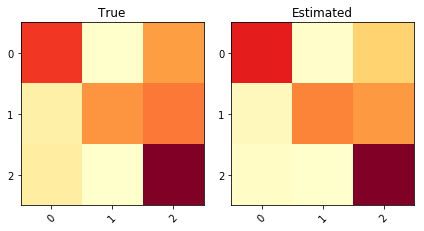

KL divergence: 0.0699	Pearson Correlation between diagonals: 0.9964


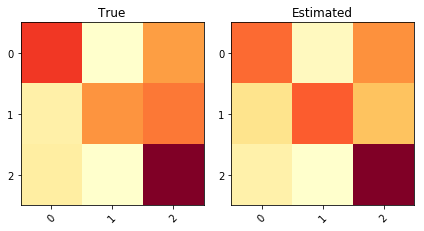

KL divergence: 0.0939	Pearson Correlation between diagonals: 0.9022


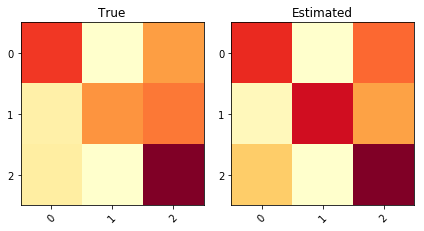

KL divergence: 0.1053	Pearson Correlation between diagonals: 0.7452


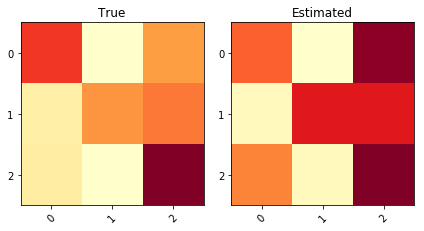

KL divergence: 0.1626	Pearson Correlation between diagonals: 0.6828


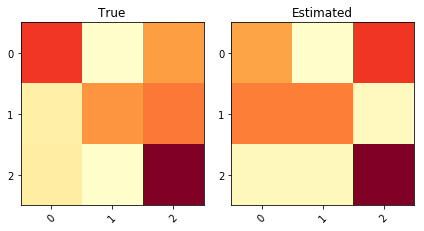

KL divergence: 0.2778	Pearson Correlation between diagonals: 0.8348


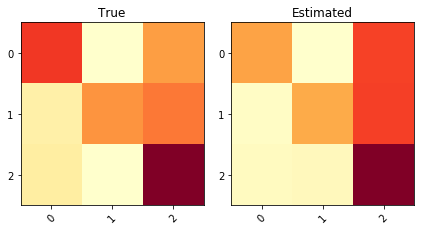

KL divergence: 0.0931	Pearson Correlation between diagonals: 0.9376


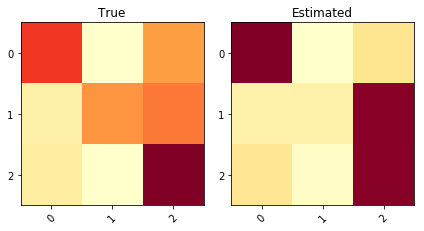

KL divergence: 0.1806	Pearson Correlation between diagonals: 0.7858
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.825397      0.825397   0.124283  0.0370282            0.877729        0.175853
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                  0.65289                0.826554
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.818071 

In [17]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture_Global.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (1) multiples runs***
Train


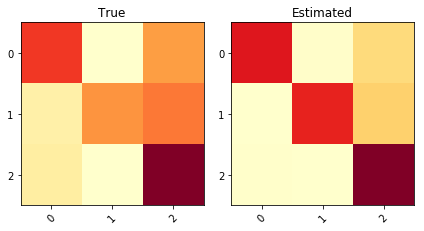

KL divergence: 0.2348	Pearson Correlation between diagonals: 0.9614


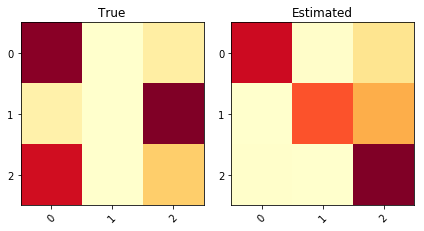

KL divergence: 1.3918	Pearson Correlation between diagonals: 0.3209


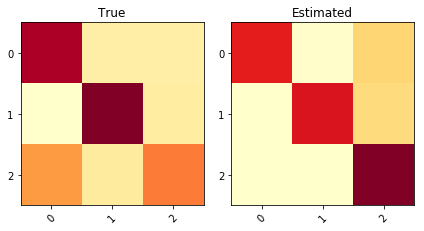

KL divergence: 0.7059	Pearson Correlation between diagonals: -0.9483


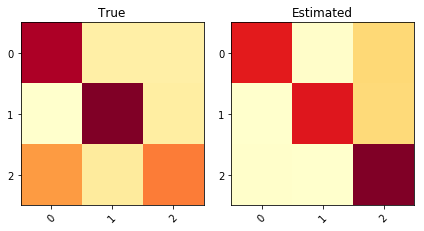

KL divergence: 0.7015	Pearson Correlation between diagonals: -0.9683


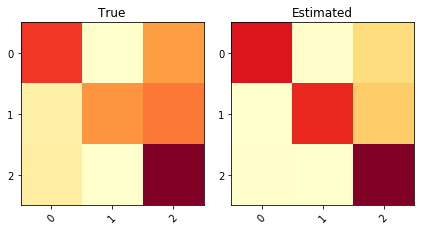

KL divergence: 0.2301	Pearson Correlation between diagonals: 0.9772


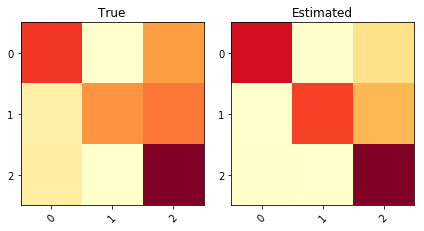

KL divergence: 0.2154	Pearson Correlation between diagonals: 0.9987


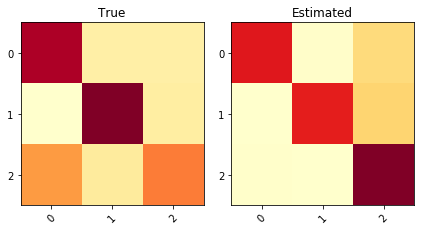

KL divergence: 0.6946	Pearson Correlation between diagonals: -0.9927


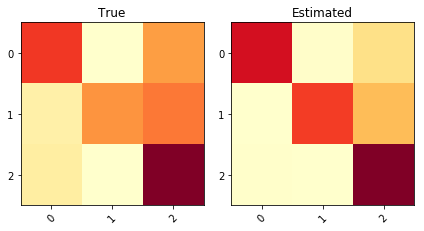

KL divergence: 0.2175	Pearson Correlation between diagonals: 1.0000


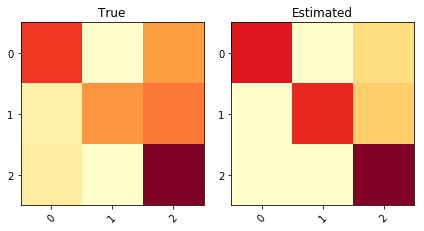

KL divergence: 0.2318	Pearson Correlation between diagonals: 0.9719


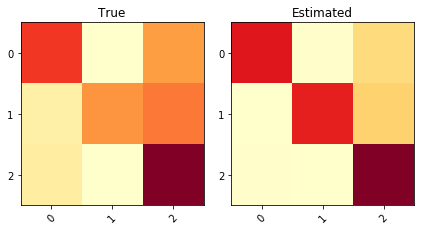

KL divergence: 0.2370	Pearson Correlation between diagonals: 0.9526


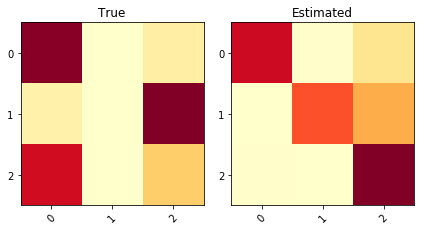

KL divergence: 1.3941	Pearson Correlation between diagonals: 0.3164


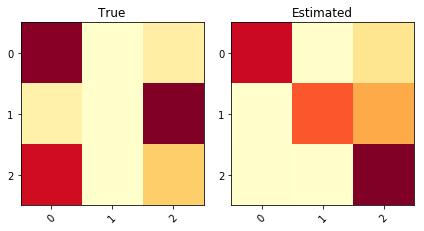

KL divergence: 1.3802	Pearson Correlation between diagonals: 0.3438


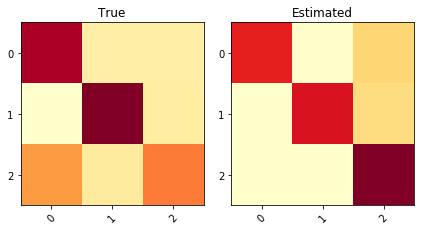

KL divergence: 0.7092	Pearson Correlation between diagonals: -0.9320


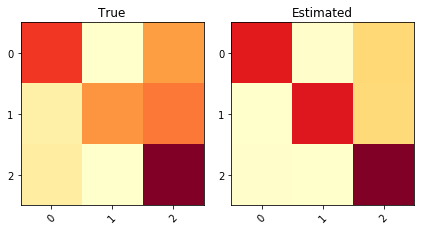

KL divergence: 0.2494	Pearson Correlation between diagonals: 0.8984


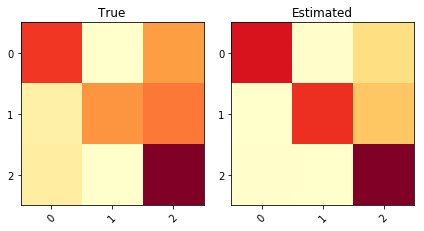

KL divergence: 0.2242	Pearson Correlation between diagonals: 0.9924
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.89825       0.89825   0.577248   0.084947            0.328995        0.151221
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.630185                0.786908
====  =======================  ======================
Test


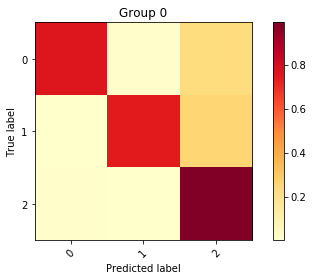

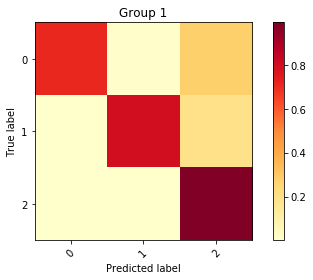

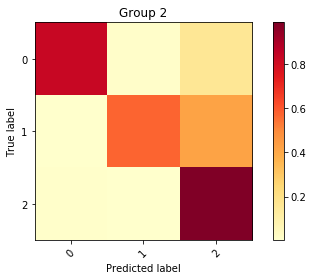

Inertia: 0.007227727444842458
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.29693      593   0.411571     0.831426   0.193448       0.907181   0.498093    0.715507      0.715507
   1         1  0.419679     839   0.398301     0.836052   0.18867        0.909572   0.502719    0.805861      0.805861
   2         2  0.283392     566   0.418249     0.798585   0.249393       0.883511   0.465252    0.648352      0.648352
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ======

In [103]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


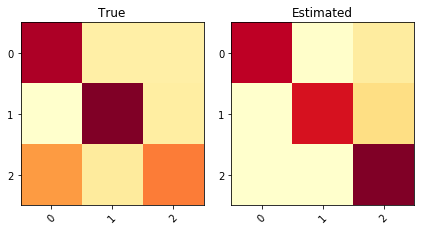

KL divergence: 0.8500	Pearson Correlation between diagonals: -0.9831


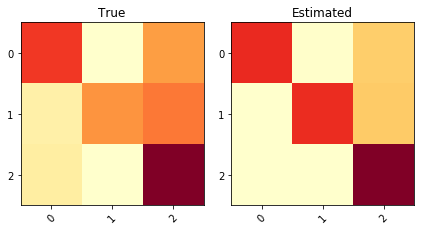

KL divergence: 0.2617	Pearson Correlation between diagonals: 0.9333


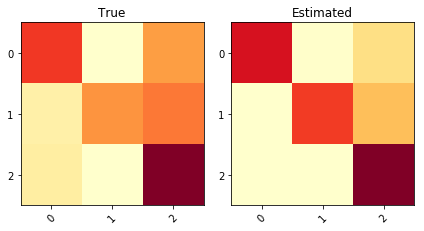

KL divergence: 0.2636	Pearson Correlation between diagonals: 0.9996


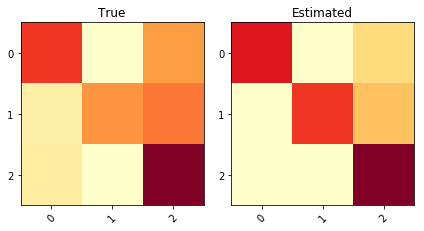

KL divergence: 0.2616	Pearson Correlation between diagonals: 0.9898


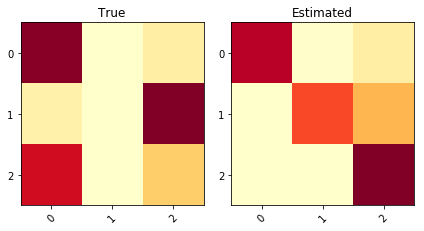

KL divergence: 1.7264	Pearson Correlation between diagonals: 0.4592


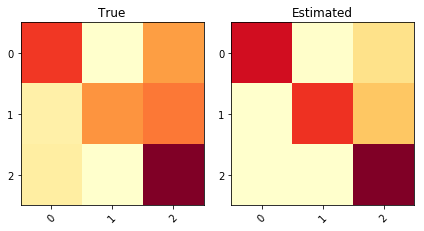

KL divergence: 0.2774	Pearson Correlation between diagonals: 0.9998


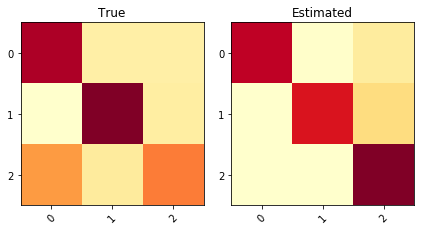

KL divergence: 0.8532	Pearson Correlation between diagonals: -0.9805


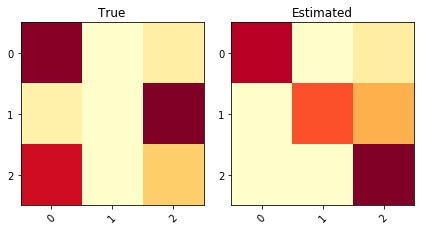

KL divergence: 1.7082	Pearson Correlation between diagonals: 0.4647


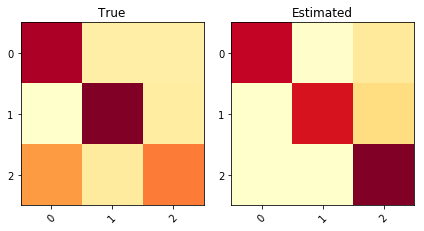

KL divergence: 0.8563	Pearson Correlation between diagonals: -0.9934


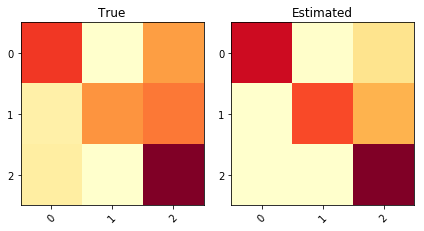

KL divergence: 0.2637	Pearson Correlation between diagonals: 0.9915


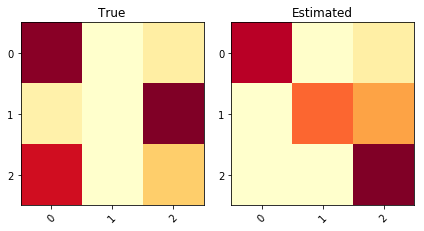

KL divergence: 1.6701	Pearson Correlation between diagonals: 0.5103


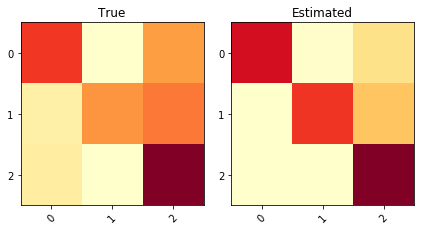

KL divergence: 0.2729	Pearson Correlation between diagonals: 0.9997


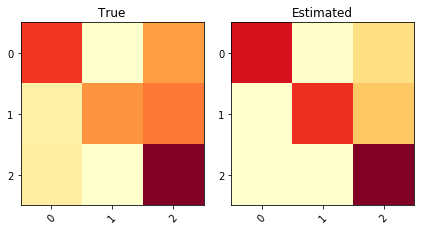

KL divergence: 0.2725	Pearson Correlation between diagonals: 0.9956


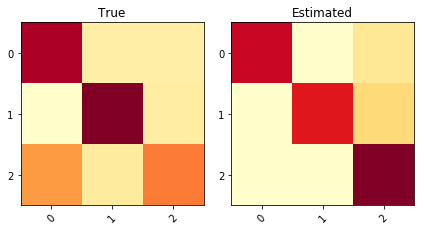

KL divergence: 0.8648	Pearson Correlation between diagonals: -0.9929


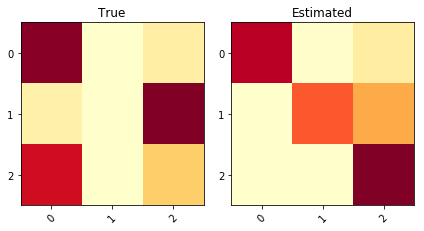

KL divergence: 1.6948	Pearson Correlation between diagonals: 0.4763
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.904762      0.904762   0.690459  0.0839284            0.382153        0.135871
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.647914                0.774467
====  =======================  ======================
Test


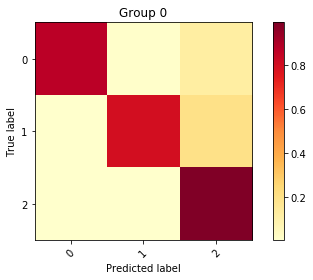

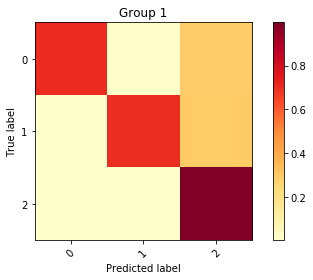

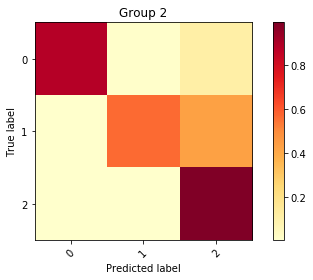

Inertia: 0.010683130628118912
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.308806     617   0.312619     0.890473   0.120068       0.941563   0.55714     0.837607      0.837607
   1         1  0.394164     788   0.422838     0.802826   0.233353       0.889142   0.469493    0.705739      0.705739
   2         2  0.29703      594   0.36901      0.815786   0.231375       0.892482   0.482453    0.648352      0.648352
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ======

In [104]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 5) configuration: Manny annot v2 ($T$ = 10000, $T_{data}$ = 40 )

In [23]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.8298738298738298


*** Soft-Majority (Train with softMV) ***
Train


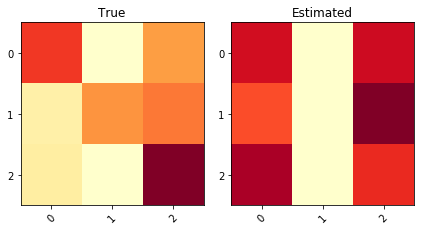

KL divergence: 2.2361	Pearson Correlation between diagonals: 0.7285


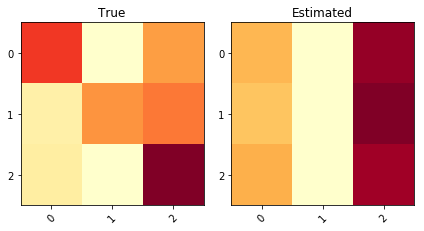

KL divergence: 2.1694	Pearson Correlation between diagonals: 1.0000


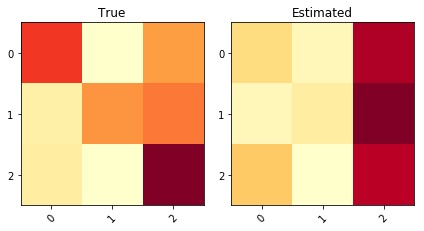

KL divergence: 0.2724	Pearson Correlation between diagonals: 0.9622


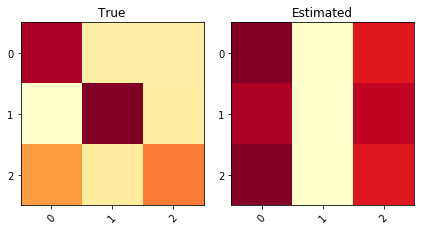

KL divergence: 5.7389	Pearson Correlation between diagonals: -0.4712


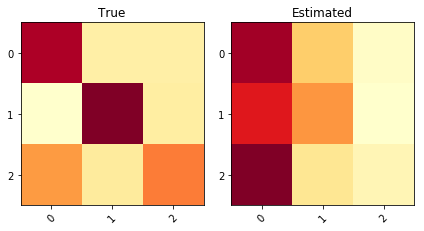

KL divergence: 0.3808	Pearson Correlation between diagonals: 0.7282


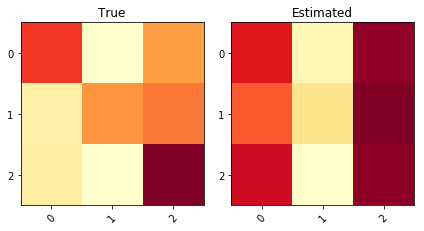

KL divergence: 0.2970	Pearson Correlation between diagonals: 0.9242


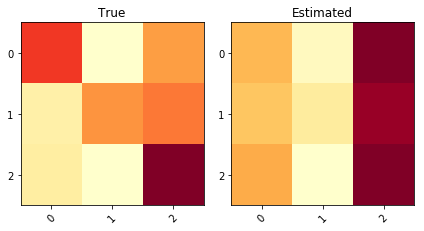

KL divergence: 0.2640	Pearson Correlation between diagonals: 0.9893


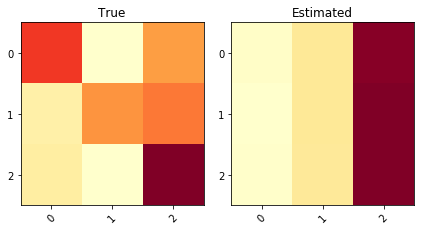

KL divergence: 0.4164	Pearson Correlation between diagonals: 0.8665


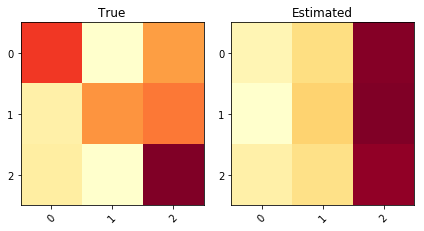

KL divergence: 0.3989	Pearson Correlation between diagonals: 0.8189


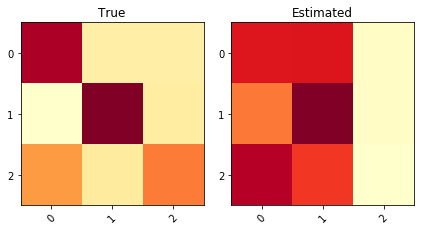

KL divergence: 0.3860	Pearson Correlation between diagonals: 0.9996


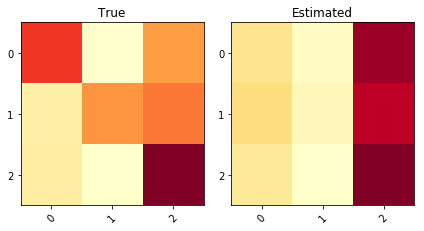

KL divergence: 0.2929	Pearson Correlation between diagonals: 0.9627


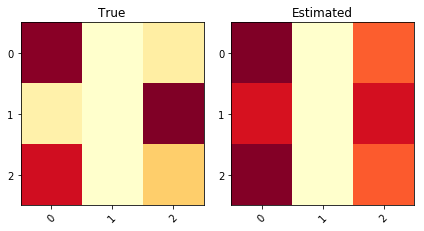

KL divergence: 0.2039	Pearson Correlation between diagonals: 0.9376


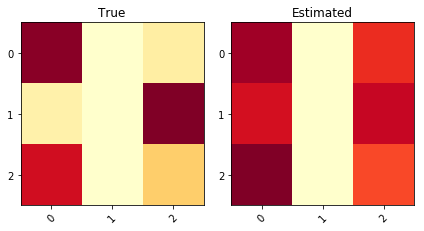

KL divergence: 0.2242	Pearson Correlation between diagonals: 0.9013


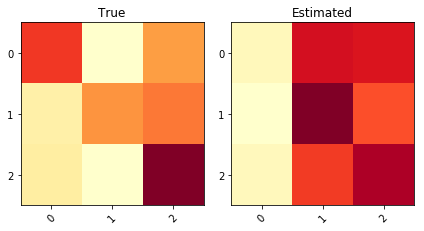

KL divergence: 0.4346	Pearson Correlation between diagonals: 0.0369


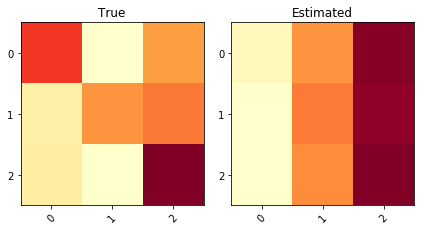

KL divergence: 0.3832	Pearson Correlation between diagonals: 0.5900
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.344729      0.344729   0.943795   0.106243            0.695869
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.343101      0.343101
====  ======  ==========  ============


In [24]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


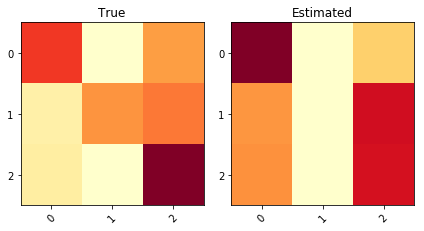

KL divergence: 2.1604	Pearson Correlation between diagonals: 0.6627


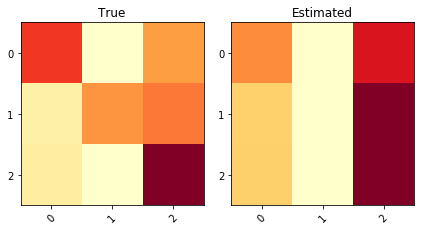

KL divergence: 2.0992	Pearson Correlation between diagonals: 0.9916


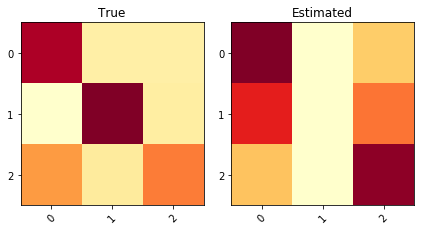

KL divergence: 5.7052	Pearson Correlation between diagonals: -0.6367


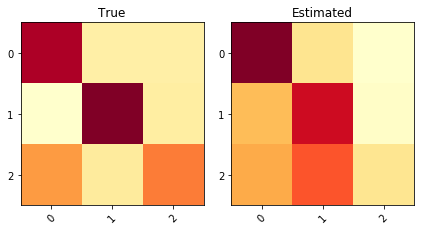

KL divergence: 0.2590	Pearson Correlation between diagonals: 0.9199


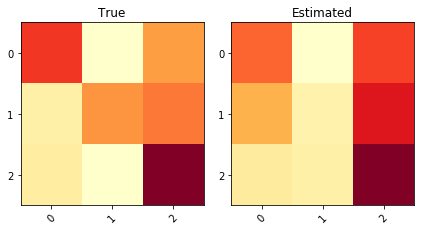

KL divergence: 0.2086	Pearson Correlation between diagonals: 0.9852


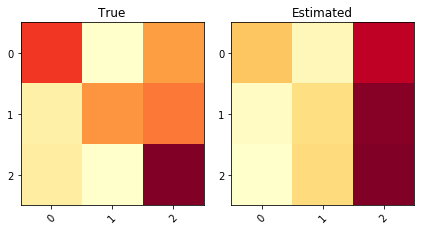

KL divergence: 0.2347	Pearson Correlation between diagonals: 0.9604


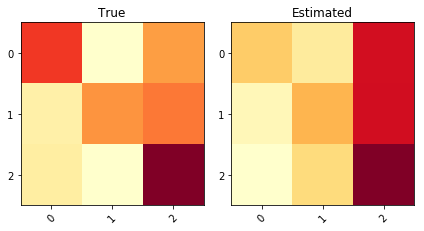

KL divergence: 0.2390	Pearson Correlation between diagonals: 0.8819


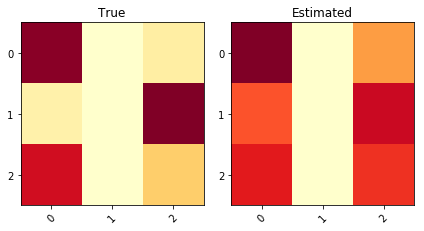

KL divergence: 0.1683	Pearson Correlation between diagonals: 0.8974


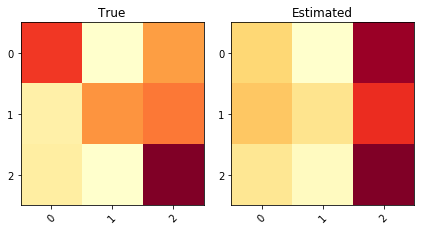

KL divergence: 0.2206	Pearson Correlation between diagonals: 0.9498


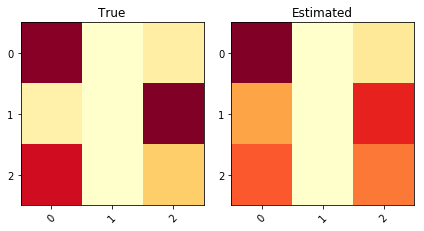

KL divergence: 0.1021	Pearson Correlation between diagonals: 0.9592


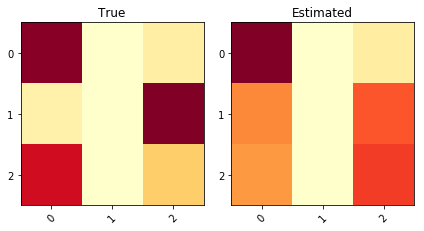

KL divergence: 0.1862	Pearson Correlation between diagonals: 0.9099


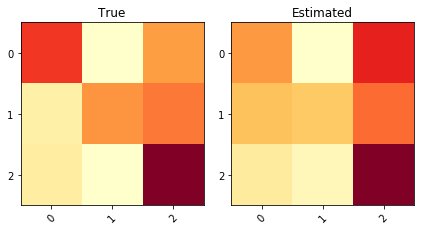

KL divergence: 0.1249	Pearson Correlation between diagonals: 0.9830


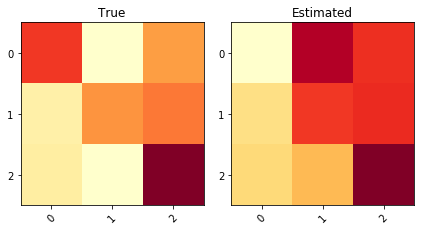

KL divergence: 0.5596	Pearson Correlation between diagonals: 0.4337


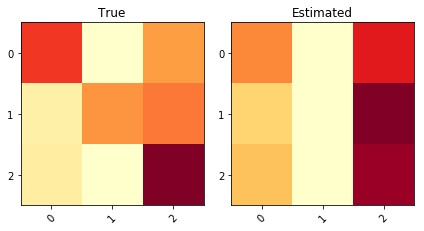

KL divergence: 2.1037	Pearson Correlation between diagonals: 0.9845


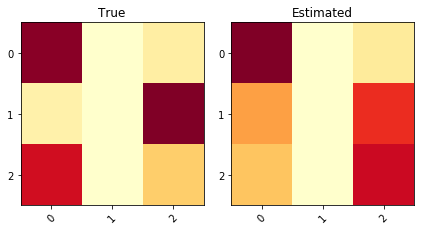

KL divergence: 0.2330	Pearson Correlation between diagonals: 0.8261
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.684575      0.684575   0.875637  0.0878307            0.692878
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.691087      0.691087
====  ======  ==========  ============


In [25]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


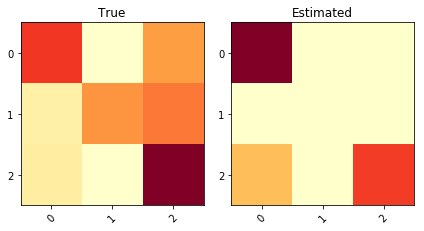

KL divergence: 1.9898	Pearson Correlation between diagonals: 0.5533


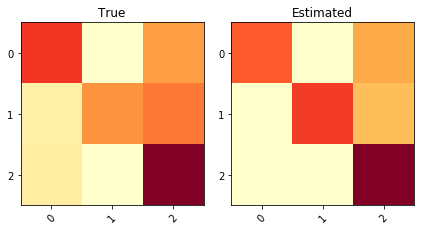

KL divergence: 0.8674	Pearson Correlation between diagonals: 0.8513


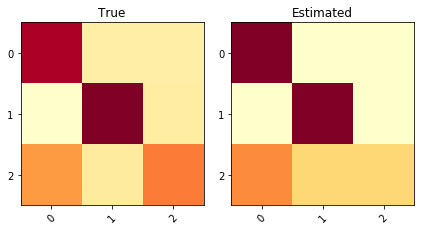

KL divergence: 1.3143	Pearson Correlation between diagonals: 0.9813


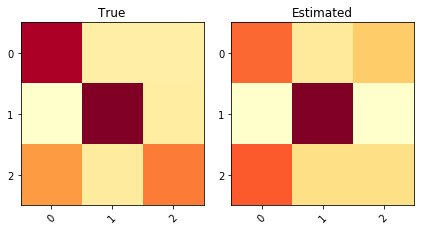

KL divergence: 0.5633	Pearson Correlation between diagonals: 0.9319


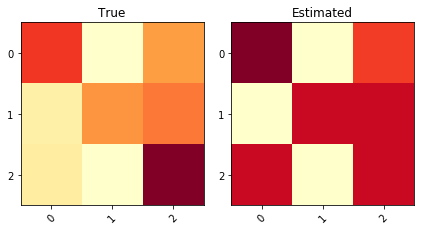

KL divergence: 0.5081	Pearson Correlation between diagonals: -0.1270


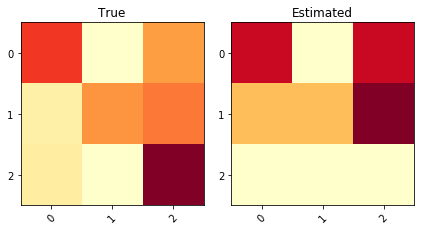

KL divergence: 0.3096	Pearson Correlation between diagonals: -0.5107


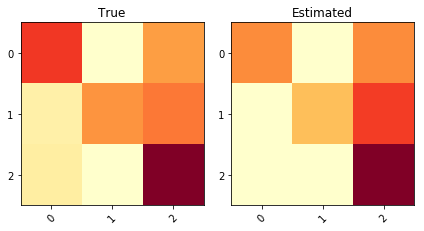

KL divergence: 0.8610	Pearson Correlation between diagonals: 0.9882


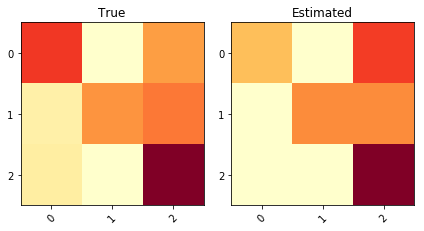

KL divergence: 0.8946	Pearson Correlation between diagonals: 0.8028


/users/fmena/.local/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


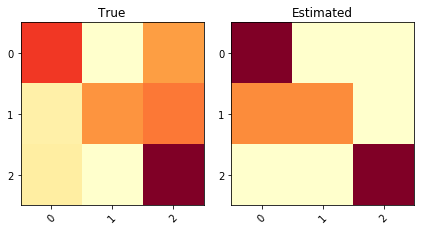

KL divergence: 4.7533	Pearson Correlation between diagonals: 0.7955


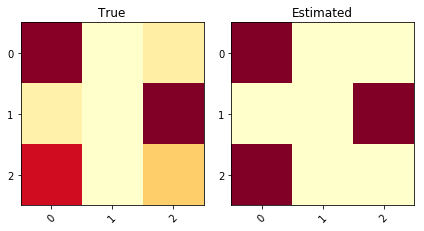

KL divergence: 2.0172	Pearson Correlation between diagonals: 0.9597


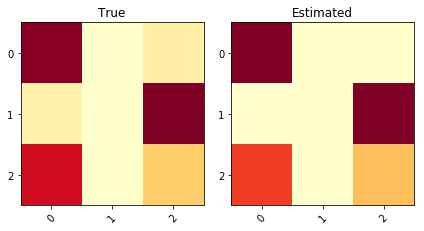

KL divergence: 0.8221	Pearson Correlation between diagonals: 0.9988


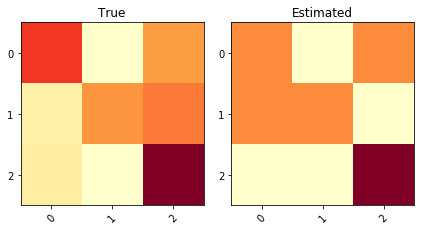

KL divergence: 2.8737	Pearson Correlation between diagonals: 0.9225


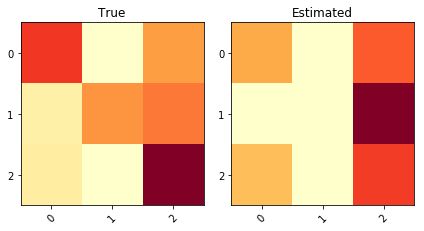

KL divergence: 2.5333	Pearson Correlation between diagonals: 0.9708


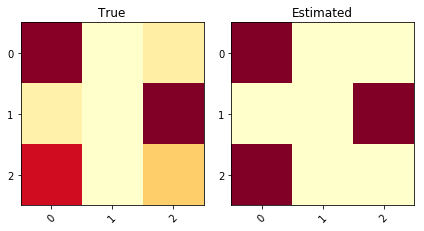

KL divergence: 2.0172	Pearson Correlation between diagonals: 0.9597


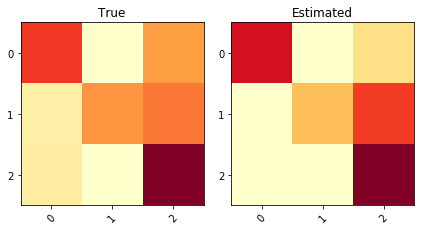

KL divergence: 0.8859	Pearson Correlation between diagonals: 0.9379
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.919007      0.919007    2.16296   0.126014                 nan
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.923077      0.923077
====  ======  ==========  ============


/users/fmena/.local/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: divide by zero encountered in double_scalars
  r = r_num / r_den


In [26]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


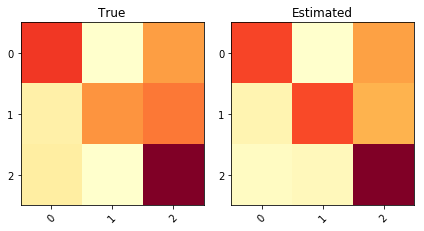

KL divergence: 0.1244	Pearson Correlation between diagonals: 0.9348


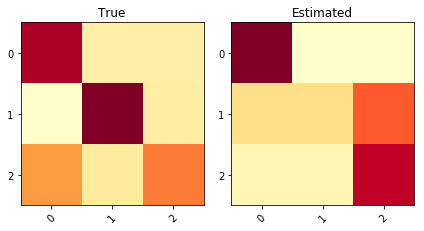

KL divergence: 0.3812	Pearson Correlation between diagonals: -0.5321


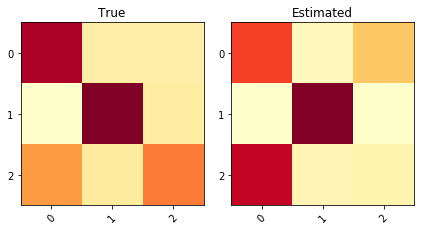

KL divergence: 0.2321	Pearson Correlation between diagonals: 0.9832


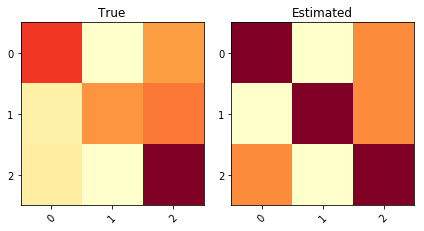

KL divergence: 0.2128	Pearson Correlation between diagonals: -0.7955


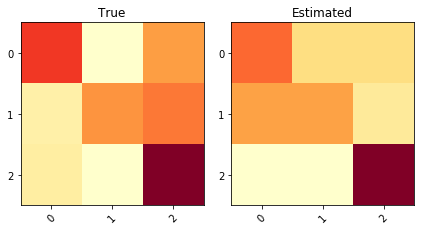

KL divergence: 0.2400	Pearson Correlation between diagonals: 0.9882


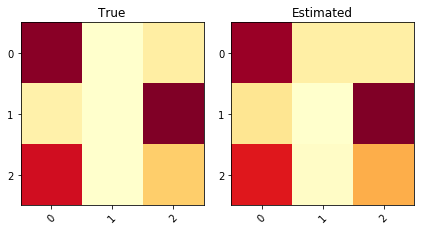

KL divergence: 0.1781	Pearson Correlation between diagonals: 0.9906


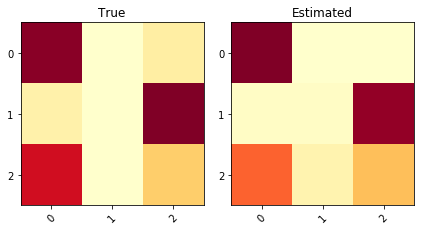

KL divergence: 0.1649	Pearson Correlation between diagonals: 0.9995


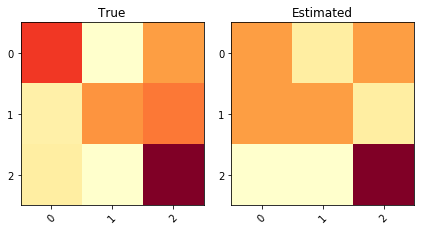

KL divergence: 0.2350	Pearson Correlation between diagonals: 0.9225


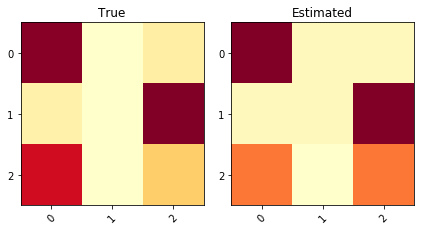

KL divergence: 0.2407	Pearson Correlation between diagonals: 0.9648


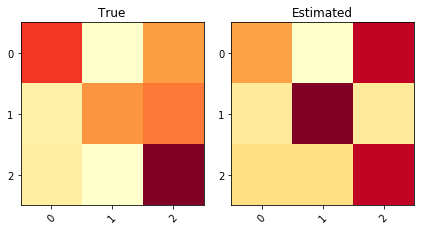

KL divergence: 0.2937	Pearson Correlation between diagonals: -0.1149


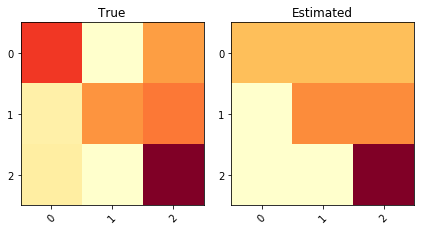

KL divergence: 0.3143	Pearson Correlation between diagonals: 0.8028


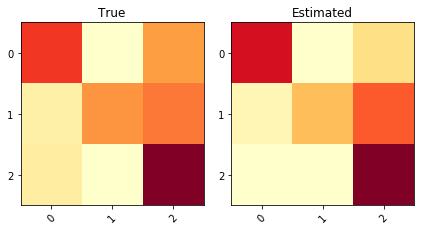

KL divergence: 0.1106	Pearson Correlation between diagonals: 0.9379


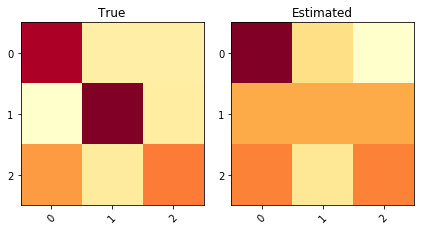

KL divergence: 0.2829	Pearson Correlation between diagonals: 0.1394


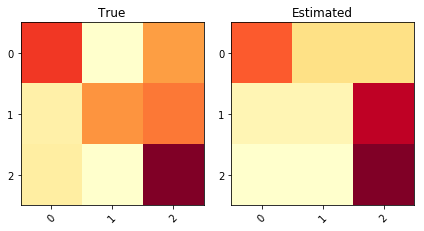

KL divergence: 0.2072	Pearson Correlation between diagonals: 0.9781


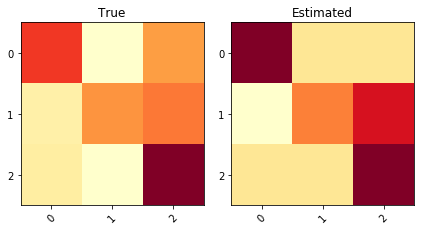

KL divergence: 0.1902	Pearson Correlation between diagonals: 0.7955


/users/fmena/.local/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.664225      0.664225   0.236415  0.0692318                 nan        0.192318
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.671692                0.854101
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.680098      0.680098
====  ======  ==========  ============


In [27]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture_Global.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (1) multiples runs***
Train


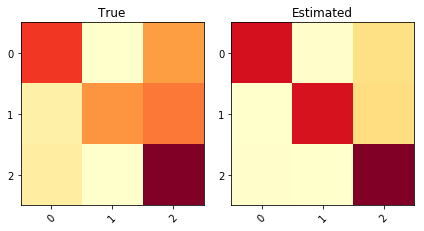

KL divergence: 0.2838	Pearson Correlation between diagonals: 0.9304


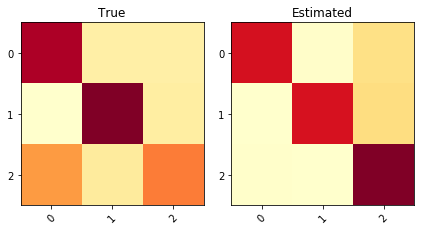

KL divergence: 0.6732	Pearson Correlation between diagonals: -0.9841


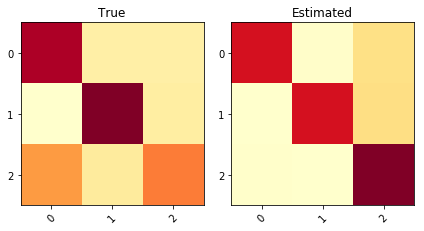

KL divergence: 0.6672	Pearson Correlation between diagonals: -0.9815


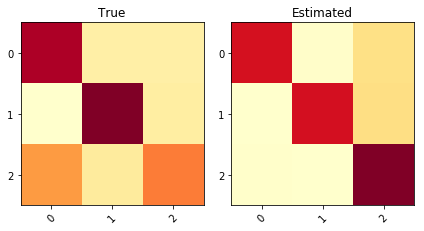

KL divergence: 0.6644	Pearson Correlation between diagonals: -0.9802


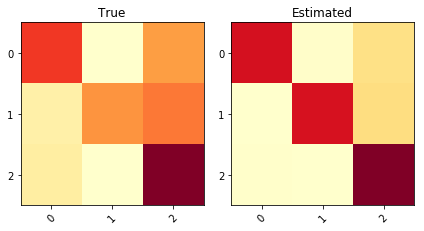

KL divergence: 0.2848	Pearson Correlation between diagonals: 0.9282


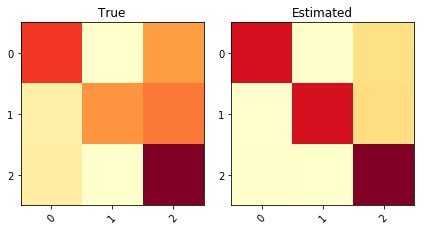

KL divergence: 0.2840	Pearson Correlation between diagonals: 0.9296


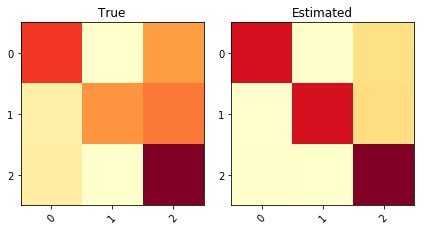

KL divergence: 0.2840	Pearson Correlation between diagonals: 0.9289


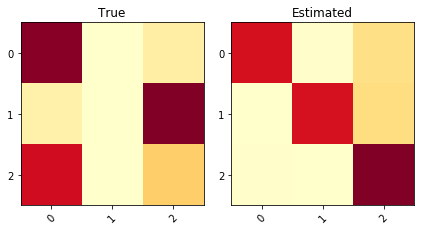

KL divergence: 1.6128	Pearson Correlation between diagonals: -0.2187


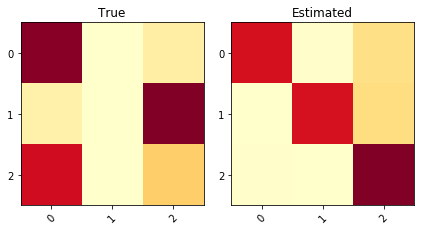

KL divergence: 1.6123	Pearson Correlation between diagonals: -0.2162


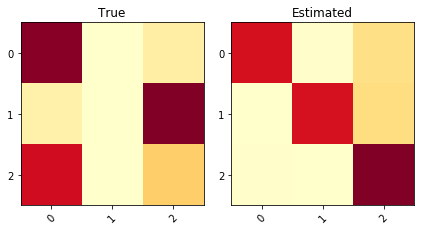

KL divergence: 1.6127	Pearson Correlation between diagonals: -0.2189


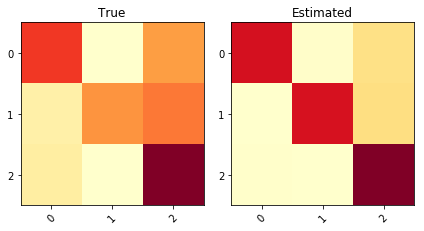

KL divergence: 0.2853	Pearson Correlation between diagonals: 0.9271


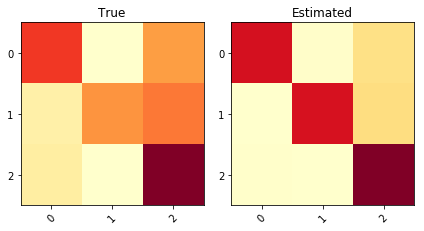

KL divergence: 0.2846	Pearson Correlation between diagonals: 0.9289


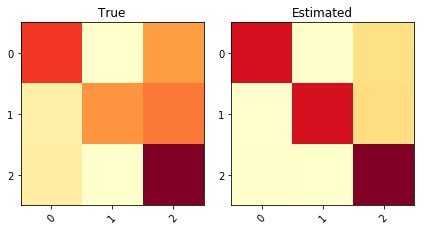

KL divergence: 0.2840	Pearson Correlation between diagonals: 0.9297


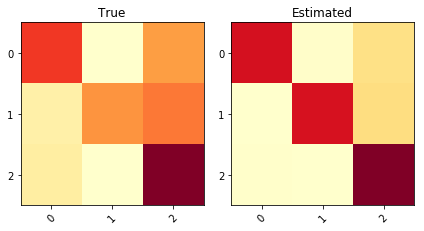

KL divergence: 0.2850	Pearson Correlation between diagonals: 0.9281


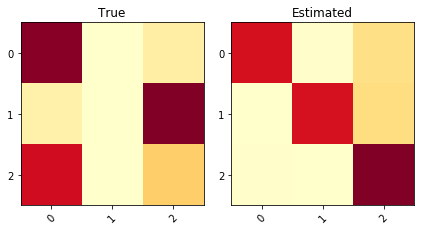

KL divergence: 1.6136	Pearson Correlation between diagonals: -0.2210
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.901099      0.901099   0.634778  0.0958811            0.227621        0.196777
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.601578                  0.8074
====  =======================  ======================
Test


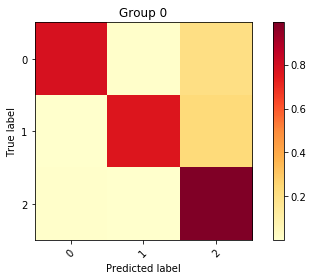

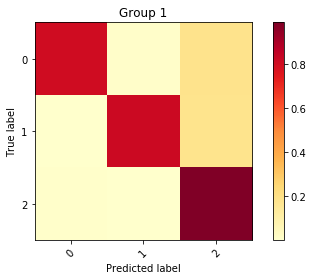

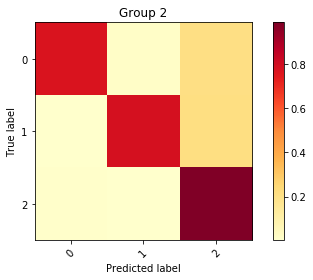

Inertia: 0.0006941696677434569
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.509769    5097   0.383405     0.847461   0.172483       0.91685    0.514128    0.664225      0.664225
   1         1  0.293071    2930   0.358103     0.871508   0.142037       0.931042   0.538174    0.714286      0.714286
   2         2  0.19716     1971   0.39276      0.850331   0.168667       0.918604   0.516998    0.684982      0.684982
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =====

In [28]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


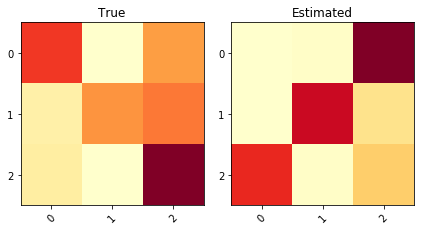

KL divergence: 1.7661	Pearson Correlation between diagonals: -0.5460


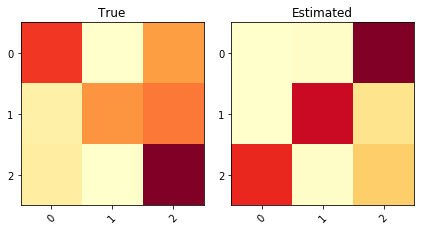

KL divergence: 1.7643	Pearson Correlation between diagonals: -0.5443


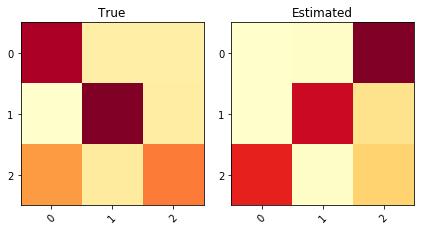

KL divergence: 2.0180	Pearson Correlation between diagonals: 0.3831


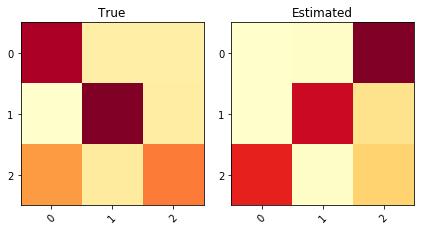

KL divergence: 2.0076	Pearson Correlation between diagonals: 0.3859


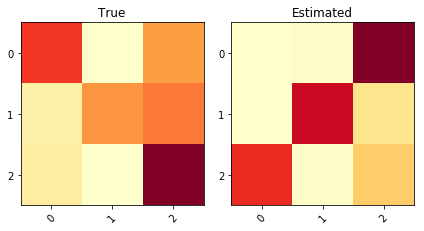

KL divergence: 1.7616	Pearson Correlation between diagonals: -0.5425


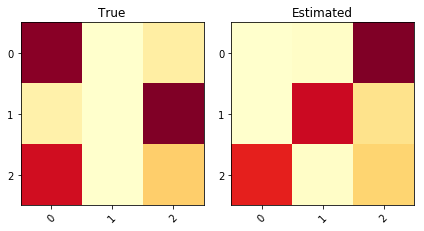

KL divergence: 2.7140	Pearson Correlation between diagonals: -0.9029


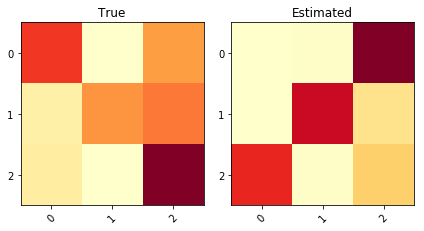

KL divergence: 1.7675	Pearson Correlation between diagonals: -0.5492


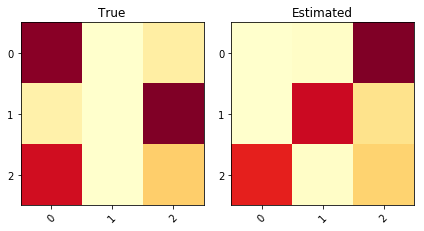

KL divergence: 2.7136	Pearson Correlation between diagonals: -0.9038


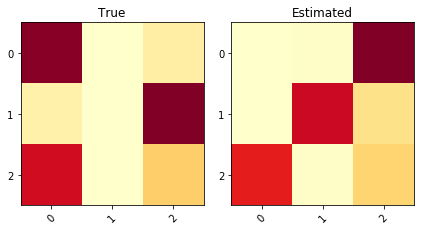

KL divergence: 2.7124	Pearson Correlation between diagonals: -0.9016


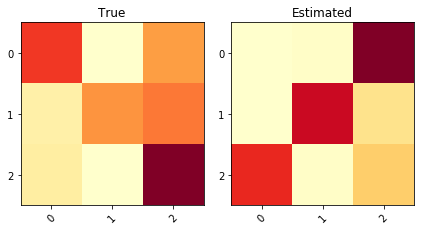

KL divergence: 1.7652	Pearson Correlation between diagonals: -0.5463


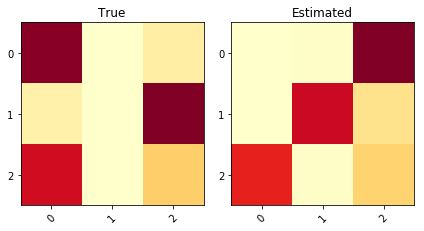

KL divergence: 2.7155	Pearson Correlation between diagonals: -0.9054


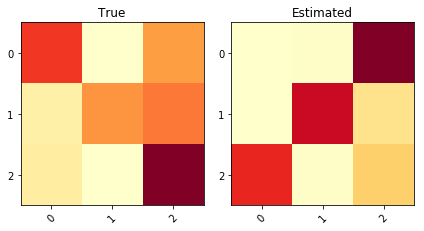

KL divergence: 1.7660	Pearson Correlation between diagonals: -0.5481


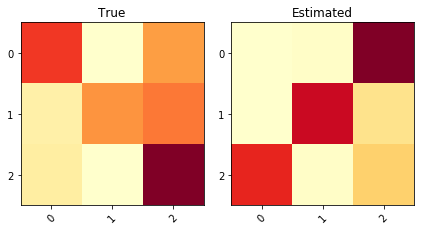

KL divergence: 1.7699	Pearson Correlation between diagonals: -0.5533


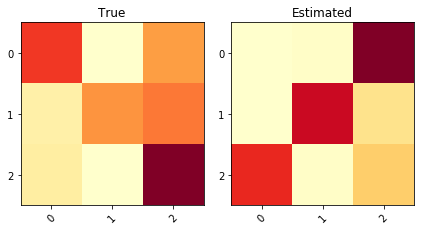

KL divergence: 1.7627	Pearson Correlation between diagonals: -0.5449


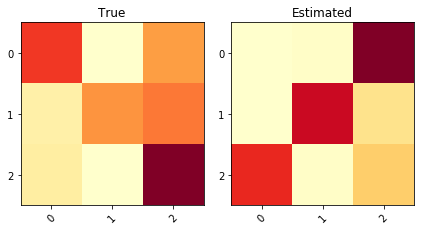

KL divergence: 1.7651	Pearson Correlation between diagonals: -0.5449
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.37851       0.37851    2.01078   0.219762            -0.38238        0.203455
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.599939                0.803456
====  =======================  ======================
Test


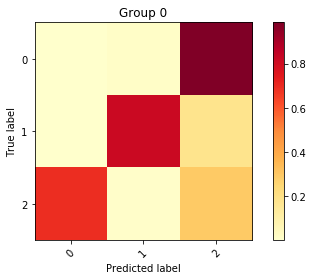

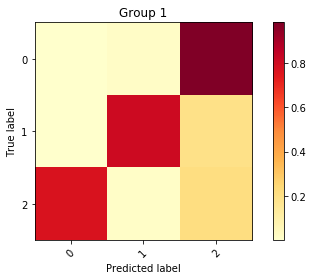

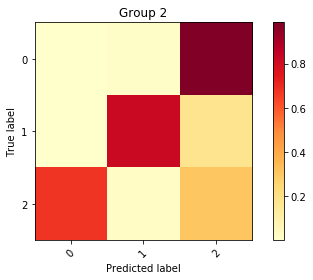

Inertia: 0.001275528554591195
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)     Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
   0         0  0.502056    5020   0.402793     0.372082    3.05296       0.469439  0.0387491     0.67033       0.67033
   1         1  0.309751    3097   0.393764     0.340686    3.00726       0.436325  0.00735291    0.65812       0.65812
   2         2  0.188194    1881   0.417051     0.376822    2.72234       0.474936  0.0434882     0.671551      0.671551
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =

In [29]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 6) configuration: Manny annot v1 bad MV ($T$ = 2000, $T_{max}$ = 20 )

In [45]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.6109076109076109


In [ ]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


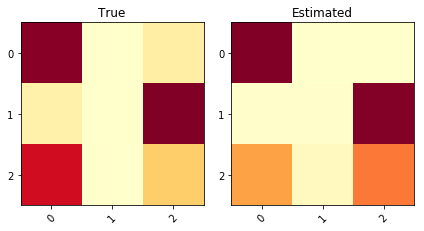

KL divergence: 0.1462	Pearson Correlation between diagonals: 0.9604


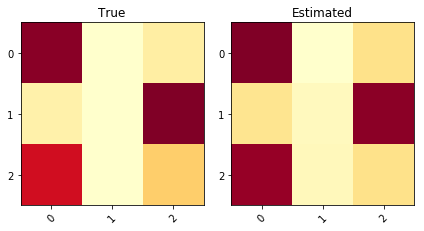

KL divergence: 0.1178	Pearson Correlation between diagonals: 0.9904


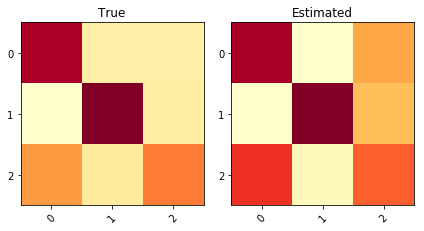

KL divergence: 0.1056	Pearson Correlation between diagonals: 1.0000


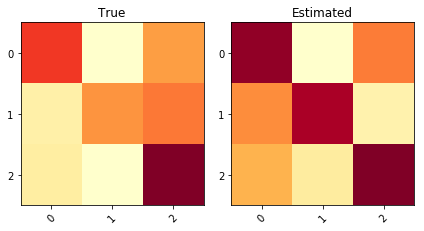

KL divergence: 0.2678	Pearson Correlation between diagonals: 0.9787


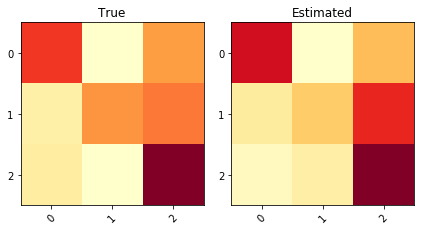

KL divergence: 0.1204	Pearson Correlation between diagonals: 0.9274


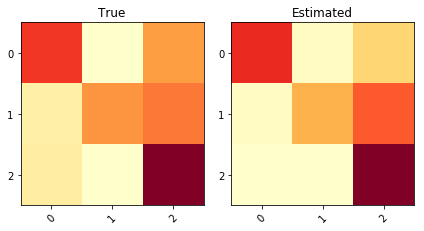

KL divergence: 0.1062	Pearson Correlation between diagonals: 0.9840


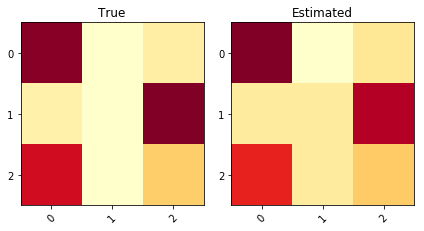

KL divergence: 0.1787	Pearson Correlation between diagonals: 0.9937


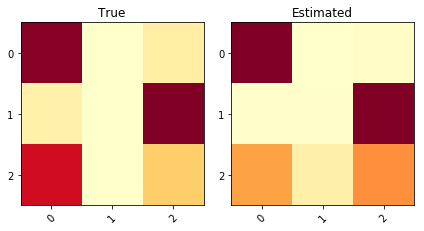

KL divergence: 0.1700	Pearson Correlation between diagonals: 0.9740


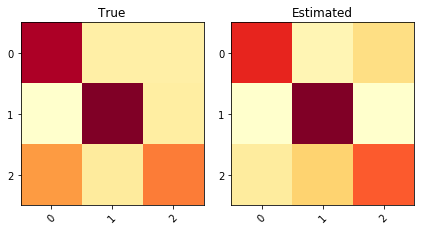

KL divergence: 0.1089	Pearson Correlation between diagonals: 0.8531


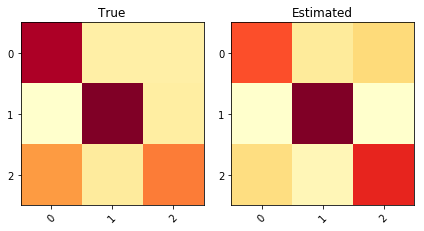

KL divergence: 0.0981	Pearson Correlation between diagonals: 0.4354


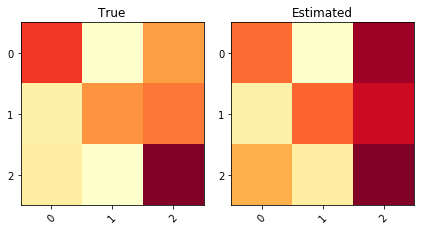

KL divergence: 0.1477	Pearson Correlation between diagonals: 0.9100


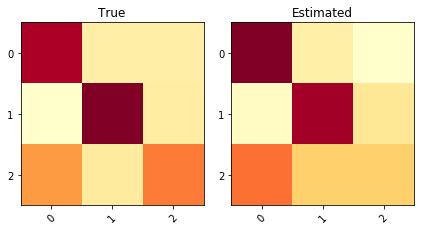

KL divergence: 0.0876	Pearson Correlation between diagonals: 0.9600


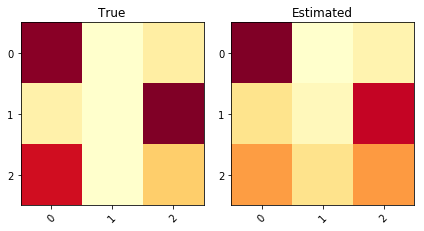

KL divergence: 0.1971	Pearson Correlation between diagonals: 0.9882


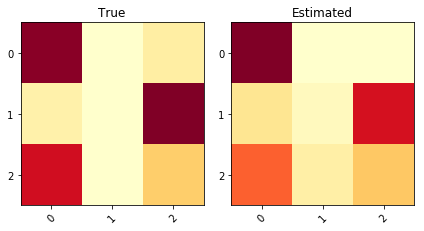

KL divergence: 0.1480	Pearson Correlation between diagonals: 0.9999


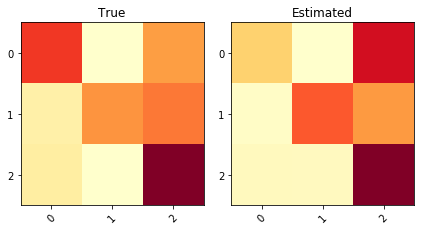

KL divergence: 0.1825	Pearson Correlation between diagonals: 0.6475
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.844933      0.844933   0.142337  0.0423729            0.865889        0.191244
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.664699                0.779589
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.849817 

In [46]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture_Global.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (1) multiples runs***
Train


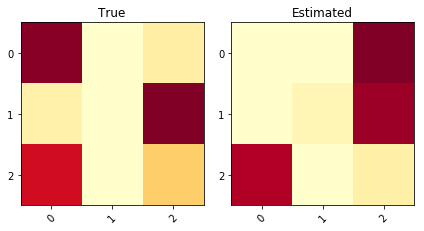

KL divergence: 1.6154	Pearson Correlation between diagonals: -0.7842


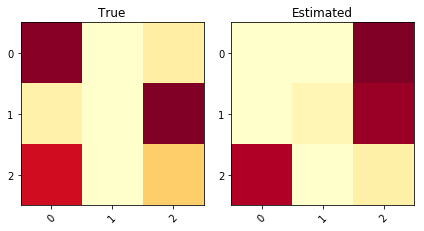

KL divergence: 1.6139	Pearson Correlation between diagonals: -0.7606


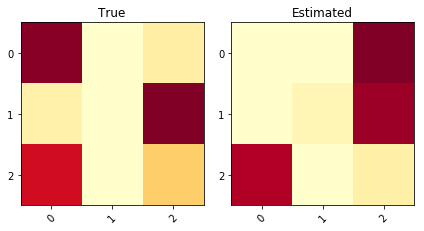

KL divergence: 1.6144	Pearson Correlation between diagonals: -0.7690


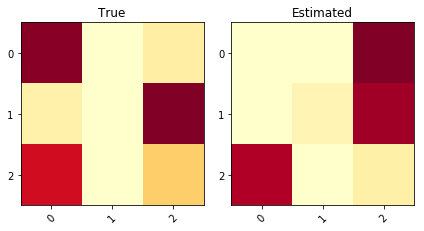

KL divergence: 1.6183	Pearson Correlation between diagonals: -0.8242


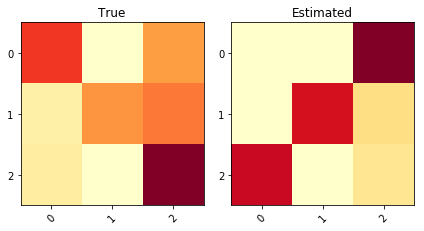

KL divergence: 1.5787	Pearson Correlation between diagonals: -0.6632


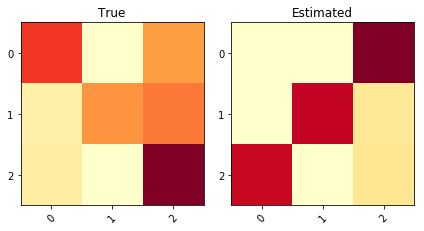

KL divergence: 1.6217	Pearson Correlation between diagonals: -0.6712


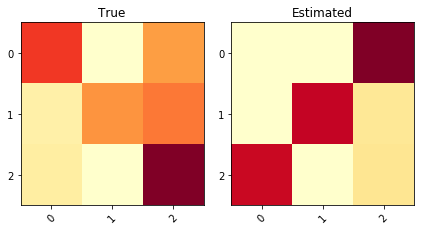

KL divergence: 1.6170	Pearson Correlation between diagonals: -0.6711


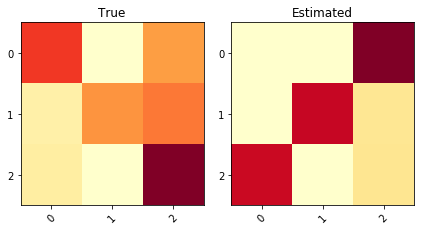

KL divergence: 1.6128	Pearson Correlation between diagonals: -0.6679


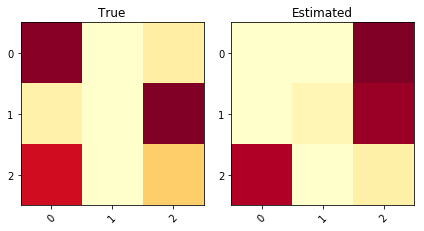

KL divergence: 1.6141	Pearson Correlation between diagonals: -0.7641


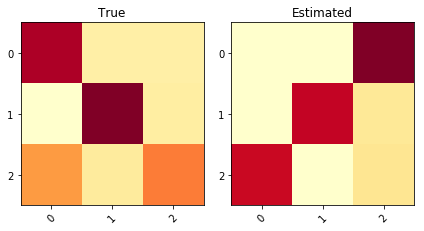

KL divergence: 1.7664	Pearson Correlation between diagonals: 0.5091


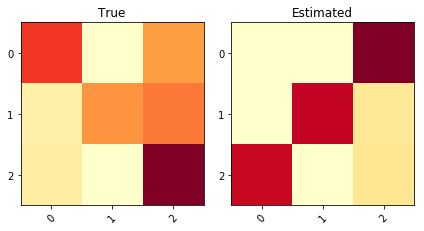

KL divergence: 1.6221	Pearson Correlation between diagonals: -0.6708


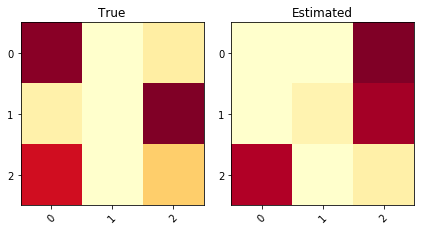

KL divergence: 1.6222	Pearson Correlation between diagonals: -0.8711


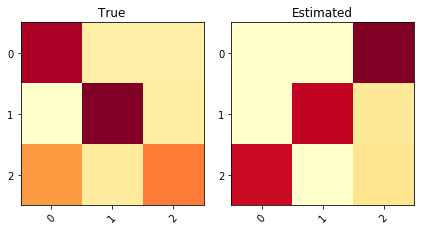

KL divergence: 1.7769	Pearson Correlation between diagonals: 0.5066


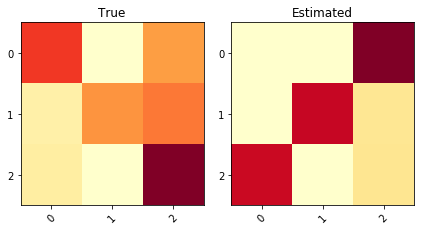

KL divergence: 1.6139	Pearson Correlation between diagonals: -0.6680


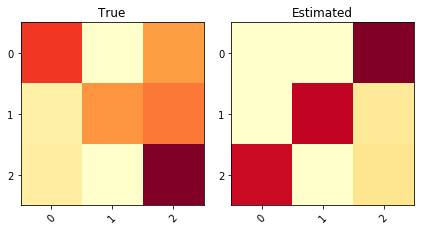

KL divergence: 1.6323	Pearson Correlation between diagonals: -0.6684
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.590151      0.590151     1.6541   0.208095             -0.4274        0.207612
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.650031                0.712605
====  =======================  ======================
Test


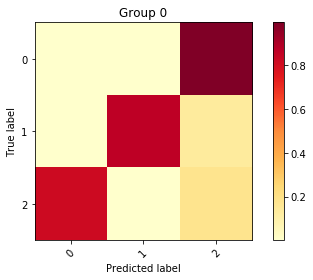

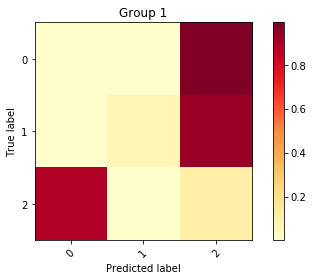

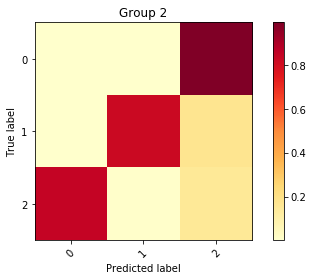

Inertia: 0.08025133436118874
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  ===========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)      Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  ===========  ==========  ============
   0         0  0.418226     836   0.310541    0.347827     2.63233       0.433638   0.0144936     0.778999      0.778999
   1         1  0.29645      592   0.21926     0.0575475    3.43965       0.148335  -0.275786      0.582418      0.582418
   2         2  0.285324     570   0.323744    0.326803     2.58821       0.415255  -0.00653005    0.691087      0.691087
====  ========  ========  ======  =========  ===========  =========  =============  ===========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  =====

In [47]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


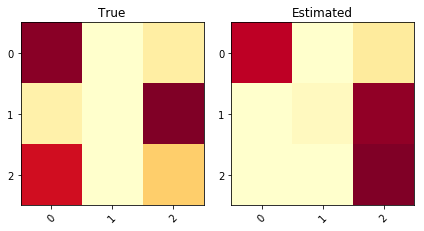

KL divergence: 1.3676	Pearson Correlation between diagonals: 0.6320


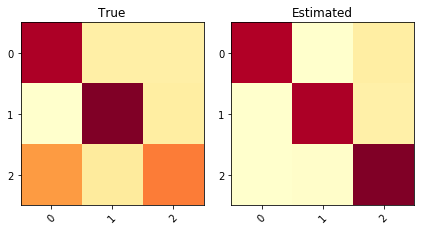

KL divergence: 0.8154	Pearson Correlation between diagonals: -0.9639


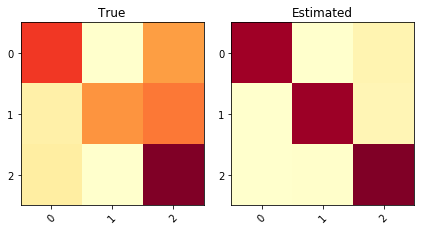

KL divergence: 0.5790	Pearson Correlation between diagonals: 0.8689


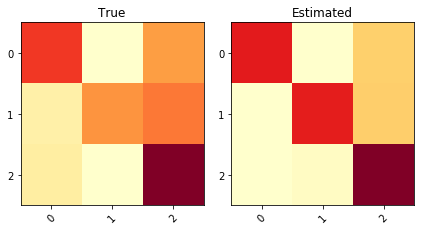

KL divergence: 0.2375	Pearson Correlation between diagonals: 0.9320


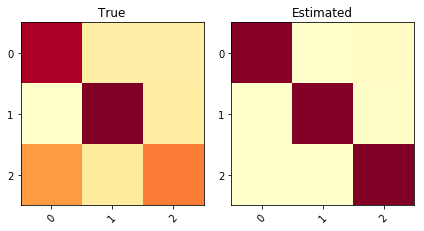

KL divergence: 0.9742	Pearson Correlation between diagonals: -0.8043


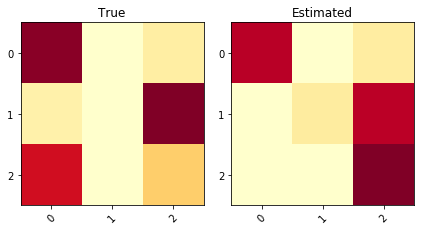

KL divergence: 1.4065	Pearson Correlation between diagonals: 0.6303


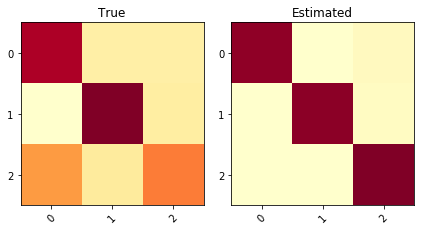

KL divergence: 0.9224	Pearson Correlation between diagonals: -0.8978


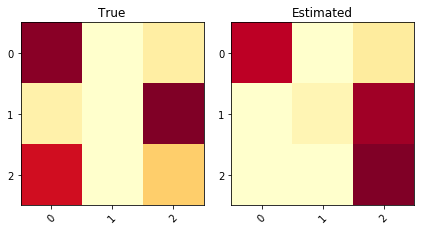

KL divergence: 1.3811	Pearson Correlation between diagonals: 0.6315


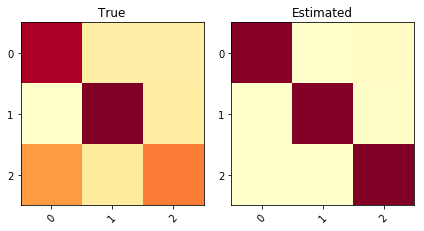

KL divergence: 0.9761	Pearson Correlation between diagonals: -0.7994


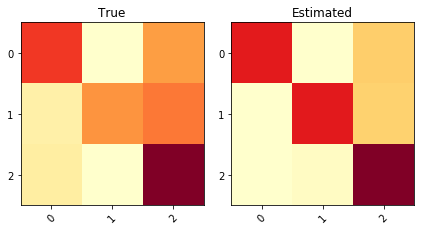

KL divergence: 0.2415	Pearson Correlation between diagonals: 0.9129


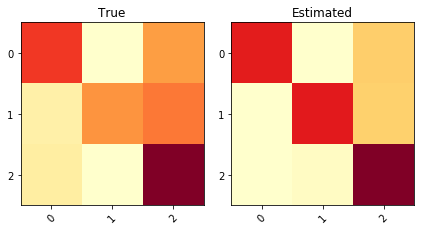

KL divergence: 0.2408	Pearson Correlation between diagonals: 0.9129


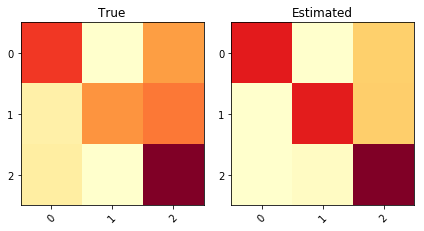

KL divergence: 0.2385	Pearson Correlation between diagonals: 0.9300


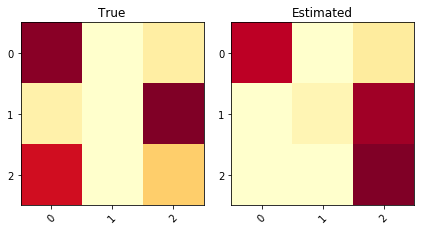

KL divergence: 1.3808	Pearson Correlation between diagonals: 0.6314


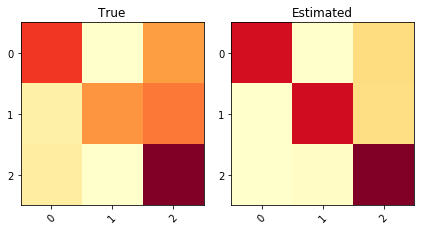

KL divergence: 0.2937	Pearson Correlation between diagonals: 0.9089


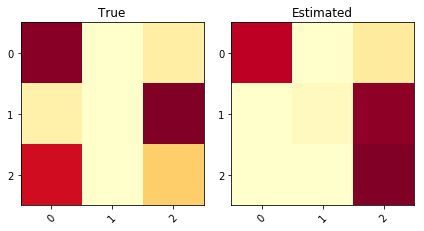

KL divergence: 1.3671	Pearson Correlation between diagonals: 0.6323
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.707367      0.707367   0.884005  0.0927332            0.357758        0.189364
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.672436                0.691652
====  =======================  ======================
Test


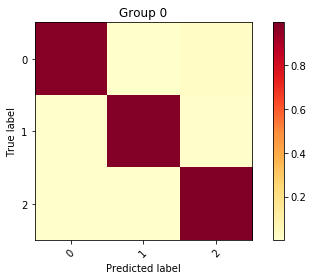

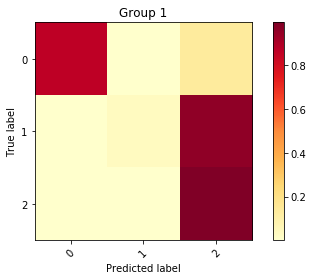

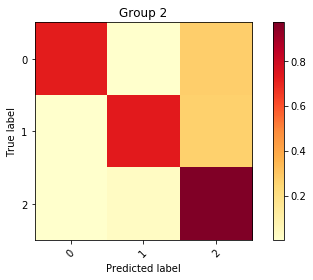

Inertia: 0.12115698804457982
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.400611     801  0.0703142     0.986921  0.0131917       0.993421   0.653588    0.737485      0.737485
   1         1  0.3475       695  0.200584      0.6322    1.16958         0.679036   0.298866    0.614164      0.614164
   2         2  0.251888     503  0.444244      0.808608  0.221968        0.893873   0.475275    0.652015      0.652015
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [48]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 7) configuration: Manny annot v1 + soft ($T$ = 2000, $T_{max}$ = 20 )

In [ ]:
#soft mv one
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
#prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture_Global.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

## Variation $M$ = #Groups
---

In [17]:
from code.evaluation import Evaluation_metrics
import pickle

logL_Mchange = []
accTR_Mchange = []
accTE_Mchange = []
best_group_acc_Mchange = []
probas_Mchange = []
divergence1_Mchange = [] #KL
divergence2_Mchange = [] #JS
probGt_Mchange = []
inertia_Mchange = [] 

for M_seted in range(1,15+1):
    #for _ in range(20):
    #    gMixture3 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
    #    gMixture3.define_model("mlp",8,1,BatchN=False,drop=0.2)
    #    gMixture3.lambda_random = True #with lambda random --necessary
    #    logL_hists,i_r = gMixture3.multiples_run(1,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
    #                                   ,cluster=True) #or without multiples runs???
        
    gMixture3 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
    gMixture3.define_model("mlp",8,1,BatchN=False,drop=0.2)
    gMixture3.lambda_random = True #with lambda random --necessary
    logL_hists,i_r = gMixture3.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                       ,cluster=True) #or without multiples runs???
    print("Model with %d trained"%(M_seted))
    logL_Mchange.append(logL_hists[i_r])
    probas_Mchange.append(gMixture3.get_alpha())

    #measure metrics..
    evaluate = Evaluation_metrics(gMixture3,'our1',plot=False) 
    aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
    predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
    Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
    results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

    accTR_Mchange.append(results1[0]["Accuracy"][0])
    divergence1_Mchange.append(results1[0]["Mean KL"][0])
    divergence2_Mchange.append(results1[0]["Mean JS"][0])
    probGt_Mchange.append(prob_Gt)

    c_M = gMixture3.get_confusionM()
    y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
    Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
    results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

    best_group_acc_Mchange.append(np.max(results2[0]["Accuracy"]))
    accTE_Mchange.append(results2[1]["Accuracy"][0])
    inertia_Mchange.append(evaluate.inertia)

    del gMixture3
    gc.collect()
# cada 10 obtener promedio
"""
T_models = 15
R = 20
logL_Mchange = [np.mean( [value[-1] for value in logL_Mchange[i*R:(i+1)*R] ] ) for i in range(T_models)]
accTR_Mchange = [np.mean(accTR_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
accTE_Mchange = [np.mean(accTE_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
best_group_acc_Mchange = [np.mean(best_group_acc_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
probas_Mchange = [np.mean(probas_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
divergence1_Mchange = [np.mean(divergence1_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
divergence2_Mchange = [np.mean(divergence2_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
probGt_Mchange = [np.mean(probGt_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
inertia_Mchange = [np.mean(inertia_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
"""

Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.003318 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9699525]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.86 sec)	logL: -25150.986	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24464.538	Tol1: 0.02729	Tol2: 0.20048	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24227.108	Tol1: 0.00971	Tol2: 0.07717	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23991.520	Tol1: 0.00972	Tol2: 0.07384	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23746.316	Tol1: 0.01022	Tol2: 0.08128	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23499.289	Tol1: 0.01040	Tol2: 0.09023	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -232

M step: done,  E step: done //  (in 0.09 sec)	logL: -23361.687	Tol1: 0.01482	Tol2: 0.04554	Tol3: 0.00000	
Iter 12/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23031.456	Tol1: 0.01414	Tol2: 0.04799	Tol3: 0.00000	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22725.741	Tol1: 0.01327	Tol2: 0.04799	Tol3: 0.00000	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22451.656	Tol1: 0.01206	Tol2: 0.04745	Tol3: 0.00000	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22199.434	Tol1: 0.01123	Tol2: 0.04644	Tol3: 0.00000	
Iter 16/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21976.589	Tol1: 0.01004	Tol2: 0.04476	Tol3: 0.00000	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21786.534	Tol1: 0.00865	Tol2: 0.04181	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21617.038	Tol1: 0.00778	Tol2: 0.03790	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21474.029	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -20673.919	Tol1: 0.00641	Tol2: 0.08438	Tol3: 0.00000	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -20560.995	Tol1: 0.00546	Tol2: 0.07291	Tol3: 0.00000	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -20472.997	Tol1: 0.00428	Tol2: 0.06613	Tol3: 0.00000	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20397.728	Tol1: 0.00368	Tol2: 0.06214	Tol3: 0.00000	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -20333.574	Tol1: 0.00315	Tol2: 0.05736	Tol3: 0.00000	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -20281.657	Tol1: 0.00255	Tol2: 0.05069	Tol3: 0.00000	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -20227.784	Tol1: 0.00266	Tol2: 0.04549	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -20191.071	Tol1: 0.00182	Tol2: 0.04264	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -20155.988	T

M step: done,  E step: done //  (in 0.10 sec)	logL: -21276.448	Tol1: 0.00507	Tol2: 0.10772	Tol3: 0.00000	
Iter 15/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21191.979	Tol1: 0.00397	Tol2: 0.07993	Tol3: 0.00000	
Iter 16/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21120.551	Tol1: 0.00337	Tol2: 0.05455	Tol3: 0.00000	
Iter 17/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21060.950	Tol1: 0.00282	Tol2: 0.03596	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21014.550	Tol1: 0.00220	Tol2: 0.03178	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20968.416	Tol1: 0.00220	Tol2: 0.03099	Tol3: 0.00000	
Iter 20/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20920.600	Tol1: 0.00228	Tol2: 0.03267	Tol3: 0.00000	
Iter 21/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20877.539	Tol1: 0.00206	Tol2: 0.03671	Tol3: 0.00000	
Iter 22/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20835.021	T

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002204 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.79809827 0.8405128 ]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 2.27 sec)	logL: -24989.799	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23742.024	Tol1: 0.04993	Tol2: 0.48917	Tol3: 0.01733	
Iter 3/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23371.695	Tol1: 0.01560	Tol2: 0.20316	Tol3: 0.03641	
Iter 4/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23073.711	Tol1: 0.01275	Tol2: 0.15156	Tol3: 0.02059	
Iter 5/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22818.122	Tol1: 0.01108	Tol2: 0.13861	Tol3: 0.01652	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22594.251	Tol1: 0.00981	Tol2: 0.13096	Tol3: 0.01579	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec

M step: done,  E step: done //  (in 0.10 sec)	logL: -20066.482	Tol1: 0.00113	Tol2: 0.04672	Tol3: 0.00334	
Iter 25/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20043.245	Tol1: 0.00116	Tol2: 0.04409	Tol3: 0.00299	
Iter 26/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20021.072	Tol1: 0.00111	Tol2: 0.04153	Tol3: 0.00318	
Iter 27/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19999.348	Tol1: 0.00109	Tol2: 0.03882	Tol3: 0.00368	
Iter 28/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19978.275	Tol1: 0.00105	Tol2: 0.03531	Tol3: 0.00528	
Iter 29/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19958.581	Tol1: 0.00099	Tol2: 0.03259	Tol3: 0.00582	
Iter 30/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19943.763	Tol1: 0.00074	Tol2: 0.03029	Tol3: 0.00366	
Iter 31/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19928.789	Tol1: 0.00075	Tol2: 0.02806	Tol3: 0.00370	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... 

M step: done,  E step: done //  (in 0.11 sec)	logL: -19948.123	Tol1: 0.00109	Tol2: 0.04712	Tol3: 0.00672	
Iter 21/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19934.039	Tol1: 0.00071	Tol2: 0.04524	Tol3: 0.00558	
Iter 22/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19918.047	Tol1: 0.00080	Tol2: 0.04222	Tol3: 0.00311	
Iter 23/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19914.084	Tol1: 0.00020	Tol2: 0.04045	Tol3: 0.00434	
Iter 24/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19907.222	Tol1: 0.00034	Tol2: 0.03979	Tol3: 0.00364	
Iter 25/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19899.374	Tol1: 0.00039	Tol2: 0.03955	Tol3: 0.00346	
Iter 26/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19893.498	Tol1: 0.00030	Tol2: 0.03803	Tol3: 0.00137	
Iter 27/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19888.957	Tol1: 0.00023	Tol2: 0.03579	Tol3: 0.00155	
Iter 28/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19881.298	T

M step: done,  E step: done //  (in 0.10 sec)	logL: -20057.841	Tol1: 0.00119	Tol2: 0.02939	Tol3: 0.00329	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.82147783 0.591659  ]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 3.19 sec)	logL: -25402.593	
Iter 2/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24618.341	Tol1: 0.03087	Tol2: 0.38009	Tol3: 0.06982	
Iter 3/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -24303.138	Tol1: 0.01280	Tol2: 0.15347	Tol3: 0.02292	
Iter 4/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -24030.211	Tol1: 0.01123	Tol2: 0.11419	Tol3: 0.02300	
Iter 5/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23774.244	Tol1: 0.01065	Tol2: 0.10541	Tol3: 0.01993	
Iter 6/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23529.843	Tol1: 0.01028	Tol2: 0.10481	Tol3: 0.01554	
Iter 7/50
M step: done,  E step: don

M step: done,  E step: done //  (in 0.10 sec)	logL: -20077.438	Tol1: 0.00173	Tol2: 0.05086	Tol3: 0.00332	
Iter 27/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20042.862	Tol1: 0.00172	Tol2: 0.04929	Tol3: 0.00280	
Iter 28/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20019.759	Tol1: 0.00115	Tol2: 0.04583	Tol3: 0.00620	
Iter 29/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19993.962	Tol1: 0.00129	Tol2: 0.04447	Tol3: 0.00341	
Iter 30/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19969.871	Tol1: 0.00120	Tol2: 0.04240	Tol3: 0.00321	
Iter 31/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19947.914	Tol1: 0.00110	Tol2: 0.03813	Tol3: 0.00540	
Iter 32/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19928.590	Tol1: 0.00097	Tol2: 0.03666	Tol3: 0.00581	
Iter 33/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19914.730	Tol1: 0.00070	Tol2: 0.03380	Tol3: 0.00516	
Iter 34/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19899.092	T

M step: done,  E step: done //  (in 0.11 sec)	logL: -21674.687	Tol1: 0.01140	Tol2: 0.07600	Tol3: 0.01913	
Iter 14/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21463.980	Tol1: 0.00972	Tol2: 0.06919	Tol3: 0.01548	
Iter 15/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21285.523	Tol1: 0.00831	Tol2: 0.06226	Tol3: 0.01128	
Iter 16/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21136.739	Tol1: 0.00699	Tol2: 0.05693	Tol3: 0.00770	
Iter 17/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21011.027	Tol1: 0.00595	Tol2: 0.05289	Tol3: 0.00472	
Iter 18/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20905.617	Tol1: 0.00502	Tol2: 0.05135	Tol3: 0.00096	
Iter 19/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20807.830	Tol1: 0.00468	Tol2: 0.04733	Tol3: 0.00062	
Iter 20/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20713.397	Tol1: 0.00454	Tol2: 0.04763	Tol3: 0.00325	
Iter 21/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20641.777	T

M step: done,  E step: done //  (in 0.11 sec)	logL: -21266.577	Tol1: 0.00594	Tol2: 0.05041	Tol3: 0.01488	
Iter 22/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21153.862	Tol1: 0.00530	Tol2: 0.05096	Tol3: 0.01543	
Iter 23/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21051.368	Tol1: 0.00485	Tol2: 0.05041	Tol3: 0.01626	
Iter 24/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20953.748	Tol1: 0.00464	Tol2: 0.04911	Tol3: 0.01667	
Iter 25/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20858.366	Tol1: 0.00455	Tol2: 0.04653	Tol3: 0.01724	
Iter 26/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20769.078	Tol1: 0.00428	Tol2: 0.04479	Tol3: 0.01768	
Iter 27/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20697.902	Tol1: 0.00343	Tol2: 0.04285	Tol3: 0.01806	
Iter 28/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20625.546	Tol1: 0.00350	Tol2: 0.04088	Tol3: 0.01740	
Iter 29/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20554.304	T

M step: done,  E step: done //  (in 0.11 sec)	logL: -20704.244	Tol1: 0.00265	Tol2: 0.04910	Tol3: 0.00516	
Iter 35/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20644.381	Tol1: 0.00289	Tol2: 0.04901	Tol3: 0.00566	
Iter 36/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20589.382	Tol1: 0.00266	Tol2: 0.04998	Tol3: 0.00555	
Iter 37/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20534.436	Tol1: 0.00267	Tol2: 0.04960	Tol3: 0.00605	
Iter 38/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20475.402	Tol1: 0.00287	Tol2: 0.04932	Tol3: 0.00570	
Iter 39/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20422.941	Tol1: 0.00256	Tol2: 0.04978	Tol3: 0.00513	
Iter 40/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20372.702	Tol1: 0.00246	Tol2: 0.04848	Tol3: 0.00500	
Iter 41/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20324.798	Tol1: 0.00235	Tol2: 0.04676	Tol3: 0.00489	
Iter 42/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20281.631	T

M step: done,  E step: done //  (in 0.11 sec)	logL: -22720.350	Tol1: 0.00514	Tol2: 0.06661	Tol3: 0.00679	
Iter 15/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22610.674	Tol1: 0.00483	Tol2: 0.06002	Tol3: 0.00551	
Iter 16/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22511.413	Tol1: 0.00439	Tol2: 0.05348	Tol3: 0.00420	
Iter 17/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22415.378	Tol1: 0.00427	Tol2: 0.04687	Tol3: 0.00330	
Iter 18/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22326.057	Tol1: 0.00398	Tol2: 0.04154	Tol3: 0.00199	
Iter 19/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22238.731	Tol1: 0.00391	Tol2: 0.03760	Tol3: 0.00127	
Iter 20/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22154.215	Tol1: 0.00380	Tol2: 0.03745	Tol3: 0.00149	
Iter 21/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22077.199	Tol1: 0.00348	Tol2: 0.03810	Tol3: 0.00298	
Iter 22/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22004.644	T

M step: done,  E step: done //  (in 0.12 sec)	logL: -20155.575	Tol1: 0.00124	Tol2: 0.03541	Tol3: 0.00556	
Iter 42/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20129.874	Tol1: 0.00128	Tol2: 0.03423	Tol3: 0.00526	
Iter 43/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20109.581	Tol1: 0.00101	Tol2: 0.03282	Tol3: 0.00458	
Iter 44/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20087.460	Tol1: 0.00110	Tol2: 0.03061	Tol3: 0.00554	
Iter 45/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20064.415	Tol1: 0.00115	Tol2: 0.02922	Tol3: 0.00530	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9150999  0.16565433 0.3885147 ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 5.24 sec)	logL: -25718.991	
Iter 2/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24568.084	Tol1: 0.04475	Tol2: 0.43649	Tol3: 0.16936	
Iter 3/50
M step: don

M step: done,  E step: done //  (in 0.16 sec)	logL: -24755.119	Tol1: 0.01723	Tol2: 0.17473	Tol3: 0.03458	
Iter 4/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24455.972	Tol1: 0.01208	Tol2: 0.09859	Tol3: 0.01210	
Iter 5/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24159.140	Tol1: 0.01214	Tol2: 0.08042	Tol3: 0.00954	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23837.675	Tol1: 0.01331	Tol2: 0.07442	Tol3: 0.01040	
Iter 7/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23504.759	Tol1: 0.01397	Tol2: 0.07803	Tol3: 0.01212	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23160.185	Tol1: 0.01466	Tol2: 0.08352	Tol3: 0.01412	
Iter 9/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22803.888	Tol1: 0.01538	Tol2: 0.08800	Tol3: 0.01576	
Iter 10/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22440.882	Tol1: 0.01592	Tol2: 0.09253	Tol3: 0.01725	
Iter 11/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22096.326	Tol1: 0

M step: done,  E step: done //  (in 6.24 sec)	logL: -26915.399	
Iter 2/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -24481.654	Tol1: 0.09042	Tol2: 0.60301	Tol3: 0.14466	
Iter 3/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24060.149	Tol1: 0.01722	Tol2: 0.22959	Tol3: 0.04489	
Iter 4/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23849.880	Tol1: 0.00874	Tol2: 0.13718	Tol3: 0.01487	
Iter 5/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23647.066	Tol1: 0.00850	Tol2: 0.10493	Tol3: 0.00780	
Iter 6/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23436.064	Tol1: 0.00892	Tol2: 0.09275	Tol3: 0.00761	
Iter 7/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23215.425	Tol1: 0.00941	Tol2: 0.08810	Tol3: 0.00878	
Iter 8/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22987.552	Tol1: 0.00982	Tol2: 0.08507	Tol3: 0.01010	
Iter 9/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22765.010	Tol1: 0.00968	Tol2: 0.08194	Tol3: 0.01135	
Iter 10/

M step: done,  E step: done //  (in 0.12 sec)	logL: -20790.903	Tol1: 0.00509	Tol2: 0.06732	Tol3: 0.00762	
Iter 25/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20700.721	Tol1: 0.00434	Tol2: 0.06274	Tol3: 0.00735	
Iter 26/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20624.478	Tol1: 0.00368	Tol2: 0.05980	Tol3: 0.00674	
Iter 27/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20551.110	Tol1: 0.00356	Tol2: 0.05992	Tol3: 0.00585	
Iter 28/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20487.282	Tol1: 0.00311	Tol2: 0.05967	Tol3: 0.00537	
Iter 29/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20428.943	Tol1: 0.00285	Tol2: 0.06014	Tol3: 0.00494	
Iter 30/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20376.964	Tol1: 0.00254	Tol2: 0.06001	Tol3: 0.00488	
Iter 31/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20328.596	Tol1: 0.00237	Tol2: 0.06073	Tol3: 0.00425	
Iter 32/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20281.576	T

Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4796767  0.72316366 0.91113025 0.9246662 ]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 7.20 sec)	logL: -27742.001	
Iter 2/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -26068.673	Tol1: 0.06032	Tol2: 0.45448	Tol3: 0.08673	
Iter 3/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -25394.872	Tol1: 0.02585	Tol2: 0.23687	Tol3: 0.03694	
Iter 4/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24881.211	Tol1: 0.02023	Tol2: 0.18377	Tol3: 0.02876	
Iter 5/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24427.925	Tol1: 0.01822	Tol2: 0.15833	Tol3: 0.02333	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24009.121	Tol1: 0.01714	Tol2: 0.13992	Tol3: 0.01851	
Iter 7/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23620.202	Tol1: 0.01620	Tol2: 0.12848	Tol3: 0.01526	
Iter 8/50
M step: done,

M step: done,  E step: done //  (in 0.13 sec)	logL: -20271.860	Tol1: 0.00215	Tol2: 0.03761	Tol3: 0.01152	
Iter 23/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20233.309	Tol1: 0.00190	Tol2: 0.03875	Tol3: 0.01097	
Iter 24/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20202.423	Tol1: 0.00153	Tol2: 0.04083	Tol3: 0.01051	
Iter 25/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20173.633	Tol1: 0.00143	Tol2: 0.04135	Tol3: 0.00972	
Iter 26/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20149.728	Tol1: 0.00118	Tol2: 0.04076	Tol3: 0.00873	
Iter 27/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20125.583	Tol1: 0.00120	Tol2: 0.03987	Tol3: 0.00815	
Iter 28/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20107.393	Tol1: 0.00090	Tol2: 0.03842	Tol3: 0.00761	
Iter 29/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20090.344	Tol1: 0.00085	Tol2: 0.03678	Tol3: 0.00764	
Iter 30/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20074.396	T

M step: done,  E step: done //  (in 0.13 sec)	logL: -20564.911	Tol1: 0.00654	Tol2: 0.04450	Tol3: 0.01898	
Iter 16/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20449.820	Tol1: 0.00560	Tol2: 0.04068	Tol3: 0.01850	
Iter 17/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20345.739	Tol1: 0.00509	Tol2: 0.03758	Tol3: 0.01732	
Iter 18/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20263.065	Tol1: 0.00406	Tol2: 0.03432	Tol3: 0.01674	
Iter 19/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20196.723	Tol1: 0.00327	Tol2: 0.03316	Tol3: 0.01495	
Iter 20/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20142.924	Tol1: 0.00266	Tol2: 0.03285	Tol3: 0.01304	
Iter 21/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20098.796	Tol1: 0.00219	Tol2: 0.03119	Tol3: 0.01238	
Iter 22/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20062.815	Tol1: 0.00179	Tol2: 0.03051	Tol3: 0.01124	
Iter 23/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20034.394	T

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7475331  0.4104742  0.2635202  0.21546373 0.12777323]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/50
M step: done,  E step: done //  (in 8.41 sec)	logL: -25605.243	
Iter 2/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23749.316	Tol1: 0.07248	Tol2: 0.63192	Tol3: 0.22424	
Iter 3/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23290.584	Tol1: 0.01932	Tol2: 0.21345	Tol3: 0.06678	
Iter 4/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22987.607	Tol1: 0.01301	Tol2: 0.14535	Tol3: 0.03322	
Iter 5/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22729.629	Tol1: 0.01122	Tol2: 0.11837	Tol3: 0.02288	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22497.836	Tol1: 0.01020	Tol2: 0.10215	Tol3: 0.01865	
Iter 7/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22293.648	Tol1: 0.00908	Tol2: 0.09099	Tol3: 0.01614	
Iter 8/50
M step: done,  E step: do

M step: done,  E step: done //  (in 0.13 sec)	logL: -21081.608	Tol1: 0.00513	Tol2: 0.04163	Tol3: 0.00972	
Iter 15/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20989.027	Tol1: 0.00439	Tol2: 0.04017	Tol3: 0.00928	
Iter 16/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20910.680	Tol1: 0.00373	Tol2: 0.03900	Tol3: 0.00886	
Iter 17/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20851.368	Tol1: 0.00284	Tol2: 0.03921	Tol3: 0.00848	
Iter 18/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20791.371	Tol1: 0.00288	Tol2: 0.03953	Tol3: 0.00793	
Iter 19/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20737.585	Tol1: 0.00259	Tol2: 0.04148	Tol3: 0.00786	
Iter 20/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20694.364	Tol1: 0.00208	Tol2: 0.04385	Tol3: 0.00772	
Iter 21/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20654.979	Tol1: 0.00190	Tol2: 0.04500	Tol3: 0.00713	
Iter 22/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20617.869	T

M step: done,  E step: done //  (in 8.07 sec)	logL: -25562.928	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23893.949	Tol1: 0.06529	Tol2: 0.69952	Tol3: 0.17722	
Iter 3/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23437.277	Tol1: 0.01911	Tol2: 0.23948	Tol3: 0.03713	
Iter 4/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23081.328	Tol1: 0.01519	Tol2: 0.16299	Tol3: 0.01104	
Iter 5/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22758.455	Tol1: 0.01399	Tol2: 0.13691	Tol3: 0.00829	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22471.997	Tol1: 0.01259	Tol2: 0.12347	Tol3: 0.00909	
Iter 7/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22210.320	Tol1: 0.01164	Tol2: 0.11270	Tol3: 0.00991	
Iter 8/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21980.290	Tol1: 0.01036	Tol2: 0.10104	Tol3: 0.01037	
Iter 9/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21775.938	Tol1: 0.00930	Tol2: 0.08850	Tol3: 0.01129	
Iter 10/

M step: done,  E step: done //  (in 0.13 sec)	logL: -20311.186	Tol1: 0.00115	Tol2: 0.04293	Tol3: 0.00288	
Iter 38/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20286.999	Tol1: 0.00119	Tol2: 0.03995	Tol3: 0.00256	
Iter 39/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20262.495	Tol1: 0.00121	Tol2: 0.03782	Tol3: 0.00244	
Iter 40/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20237.138	Tol1: 0.00125	Tol2: 0.03637	Tol3: 0.00234	
Iter 41/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20214.735	Tol1: 0.00111	Tol2: 0.03544	Tol3: 0.00214	
Iter 42/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20193.560	Tol1: 0.00105	Tol2: 0.03370	Tol3: 0.00163	
Iter 43/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20169.396	Tol1: 0.00120	Tol2: 0.03233	Tol3: 0.00179	
Iter 44/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20147.213	Tol1: 0.00110	Tol2: 0.03254	Tol3: 0.00161	
Iter 45/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20131.303	T

M step: done,  E step: done //  (in 0.14 sec)	logL: -20272.716	Tol1: 0.00219	Tol2: 0.05432	Tol3: 0.00472	
Iter 25/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20234.723	Tol1: 0.00187	Tol2: 0.04996	Tol3: 0.00502	
Iter 26/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20201.081	Tol1: 0.00166	Tol2: 0.04748	Tol3: 0.00488	
Iter 27/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20176.177	Tol1: 0.00123	Tol2: 0.04377	Tol3: 0.00405	
Iter 28/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20145.808	Tol1: 0.00151	Tol2: 0.03944	Tol3: 0.00431	
Iter 29/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20114.451	Tol1: 0.00156	Tol2: 0.03752	Tol3: 0.00389	
Iter 30/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20091.969	Tol1: 0.00112	Tol2: 0.03557	Tol3: 0.00287	
Iter 31/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20069.987	Tol1: 0.00109	Tol2: 0.03281	Tol3: 0.00345	
Iter 32/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20050.291	T

M step: done,  E step: done //  (in 0.18 sec)	logL: -22876.565	Tol1: 0.01788	Tol2: 0.30730	Tol3: 0.06478	
Iter 4/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22533.947	Tol1: 0.01498	Tol2: 0.22243	Tol3: 0.05353	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22233.725	Tol1: 0.01332	Tol2: 0.18149	Tol3: 0.04878	
Iter 6/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21968.659	Tol1: 0.01192	Tol2: 0.15327	Tol3: 0.04358	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21734.195	Tol1: 0.01067	Tol2: 0.13025	Tol3: 0.03770	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21515.565	Tol1: 0.01006	Tol2: 0.11013	Tol3: 0.03211	
Iter 9/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21328.021	Tol1: 0.00872	Tol2: 0.09278	Tol3: 0.02770	
Iter 10/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21163.944	Tol1: 0.00769	Tol2: 0.07723	Tol3: 0.02417	
Iter 11/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21017.755	Tol1: 0

M step: done,  E step: done //  (in 0.15 sec)	logL: -20027.645	Tol1: 0.00289	Tol2: 0.03855	Tol3: 0.00616	
Iter 45/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19981.807	Tol1: 0.00229	Tol2: 0.03731	Tol3: 0.00641	
Iter 46/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19940.523	Tol1: 0.00207	Tol2: 0.03345	Tol3: 0.00551	
Iter 47/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19903.751	Tol1: 0.00184	Tol2: 0.03072	Tol3: 0.00502	
Iter 48/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19874.960	Tol1: 0.00145	Tol2: 0.02907	Tol3: 0.00485	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.17481956 0.28439355 0.5415415  0.10724027 0.402487   0.3508665 ]
Alphas:  (6,)
MV init:  (2457, 3)
Betas:  (6, 3, 3)
Q estimate:  (2457, 3, 6, 3)
Iter 1/50
M step: done,  E step: done //  (in 9.18 sec)	logL: -26810.118	
Iter 2/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -25542.699	Tol1: 0.04727	Tol2: 0.74847	Tol

M step: done,  E step: done //  (in 0.15 sec)	logL: -22832.923	Tol1: 0.00845	Tol2: 0.10147	Tol3: 0.02260	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22634.653	Tol1: 0.00868	Tol2: 0.08990	Tol3: 0.02026	
Iter 9/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22426.250	Tol1: 0.00921	Tol2: 0.07982	Tol3: 0.01770	
Iter 10/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22209.848	Tol1: 0.00965	Tol2: 0.07102	Tol3: 0.01559	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21994.064	Tol1: 0.00972	Tol2: 0.06356	Tol3: 0.01380	
Iter 12/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21786.328	Tol1: 0.00945	Tol2: 0.05613	Tol3: 0.01231	
Iter 13/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21586.853	Tol1: 0.00916	Tol2: 0.04938	Tol3: 0.01129	
Iter 14/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21405.213	Tol1: 0.00841	Tol2: 0.04362	Tol3: 0.01112	
Iter 15/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21243.363	Tol

M step: done,  E step: done //  (in 0.18 sec)	logL: -20281.177	Tol1: 0.00317	Tol2: 0.03739	Tol3: 0.00918	
Iter 29/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20225.877	Tol1: 0.00273	Tol2: 0.03600	Tol3: 0.00860	
Iter 30/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20180.014	Tol1: 0.00227	Tol2: 0.03512	Tol3: 0.00741	
Iter 31/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20142.681	Tol1: 0.00185	Tol2: 0.03426	Tol3: 0.00707	
Iter 32/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20105.730	Tol1: 0.00183	Tol2: 0.03188	Tol3: 0.00674	
Iter 33/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20073.227	Tol1: 0.00162	Tol2: 0.03008	Tol3: 0.00705	
Iter 34/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20043.881	Tol1: 0.00146	Tol2: 0.02910	Tol3: 0.00609	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6140971  0.6080712  0.9252743  0.6865758  0.611228   0.19674723]
Alphas:  (6,)
MV init:  (

M step: done,  E step: done //  (in 0.14 sec)	logL: -20937.131	Tol1: 0.00478	Tol2: 0.02672	Tol3: 0.01118	
Finished training!
Model with 6 trained
Needed params (units,deep,drop,BatchN?)
mv close is done
Clustering Done!
Get init alphas in 0.002638 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.39122358 0.7029616  0.01610995 0.9755505  0.45189384 0.55266386
 0.02839696]
Alphas:  (7,)
MV init:  (2457, 3)
Betas:  (7, 3, 3)
Q estimate:  (2457, 3, 7, 3)
Iter 1/50
M step: done,  E step: done //  (in 11.19 sec)	logL: -27663.659	
Iter 2/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -25451.511	Tol1: 0.07997	Tol2: 0.90023	Tol3: 0.21435	
Iter 3/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24906.784	Tol1: 0.02140	Tol2: 0.30472	Tol3: 0.06441	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24600.075	Tol1: 0.01231	Tol2: 0.18657	Tol3: 0.03313	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24337.103	Tol1: 0.01

M step: done,  E step: done //  (in 0.18 sec)	logL: -24341.366	Tol1: 0.01130	Tol2: 0.08991	Tol3: 0.01694	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24059.146	Tol1: 0.01159	Tol2: 0.09062	Tol3: 0.02248	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23767.585	Tol1: 0.01212	Tol2: 0.09706	Tol3: 0.02709	
Iter 9/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23461.155	Tol1: 0.01289	Tol2: 0.10358	Tol3: 0.03037	
Iter 10/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23148.342	Tol1: 0.01333	Tol2: 0.11017	Tol3: 0.03306	
Iter 11/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22838.247	Tol1: 0.01340	Tol2: 0.11406	Tol3: 0.03415	
Iter 12/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22546.167	Tol1: 0.01279	Tol2: 0.11461	Tol3: 0.03338	
Iter 13/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22274.106	Tol1: 0.01207	Tol2: 0.11099	Tol3: 0.03092	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22024.448	Tol1

M step: done,  E step: done //  (in 0.15 sec)	logL: -22752.746	Tol1: 0.00910	Tol2: 0.07142	Tol3: 0.01919	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22536.101	Tol1: 0.00952	Tol2: 0.06644	Tol3: 0.01797	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22332.226	Tol1: 0.00905	Tol2: 0.06328	Tol3: 0.01721	
Iter 15/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22137.170	Tol1: 0.00873	Tol2: 0.05948	Tol3: 0.01622	
Iter 16/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21954.627	Tol1: 0.00825	Tol2: 0.05605	Tol3: 0.01547	
Iter 17/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21778.506	Tol1: 0.00802	Tol2: 0.05397	Tol3: 0.01482	
Iter 18/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21622.181	Tol1: 0.00718	Tol2: 0.05244	Tol3: 0.01416	
Iter 19/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21475.490	Tol1: 0.00678	Tol2: 0.05149	Tol3: 0.01362	
Iter 20/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21334.045	T

M step: done,  E step: done //  (in 13.80 sec)	logL: -24897.337	
Iter 2/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23240.080	Tol1: 0.06656	Tol2: 0.85670	Tol3: 0.23929	
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22797.972	Tol1: 0.01902	Tol2: 0.31232	Tol3: 0.08895	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22472.505	Tol1: 0.01428	Tol2: 0.19552	Tol3: 0.05649	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22171.978	Tol1: 0.01337	Tol2: 0.15036	Tol3: 0.04686	
Iter 6/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21900.248	Tol1: 0.01226	Tol2: 0.12335	Tol3: 0.04247	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21652.407	Tol1: 0.01132	Tol2: 0.10366	Tol3: 0.03859	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21430.491	Tol1: 0.01025	Tol2: 0.08854	Tol3: 0.03508	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21236.915	Tol1: 0.00903	Tol2: 0.07617	Tol3: 0.03153	
Iter 10

M step: done,  E step: done //  (in 0.14 sec)	logL: -21697.387	Tol1: 0.00802	Tol2: 0.05736	Tol3: 0.01815	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21529.060	Tol1: 0.00776	Tol2: 0.05203	Tol3: 0.01761	
Iter 15/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21381.230	Tol1: 0.00687	Tol2: 0.04771	Tol3: 0.01763	
Iter 16/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21241.096	Tol1: 0.00655	Tol2: 0.04470	Tol3: 0.01759	
Iter 17/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21122.084	Tol1: 0.00560	Tol2: 0.04064	Tol3: 0.01745	
Iter 18/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21008.878	Tol1: 0.00536	Tol2: 0.03799	Tol3: 0.01758	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20917.138	Tol1: 0.00437	Tol2: 0.03548	Tol3: 0.01774	
Iter 20/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20834.400	Tol1: 0.00396	Tol2: 0.03332	Tol3: 0.01760	
Iter 21/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20761.975	T

M step: done,  E step: done //  (in 0.15 sec)	logL: -20310.547	Tol1: 0.00170	Tol2: 0.03259	Tol3: 0.01119	
Iter 36/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20276.751	Tol1: 0.00166	Tol2: 0.03169	Tol3: 0.01140	
Iter 37/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20247.934	Tol1: 0.00142	Tol2: 0.03046	Tol3: 0.01055	
Iter 38/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20217.219	Tol1: 0.00152	Tol2: 0.02851	Tol3: 0.01069	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.0971022  0.62645257 0.00886503 0.922108   0.46777377 0.77240616
 0.92886746]
Alphas:  (7,)
MV init:  (2457, 3)
Betas:  (7, 3, 3)
Q estimate:  (2457, 3, 7, 3)
Iter 1/50
M step: done,  E step: done //  (in 12.14 sec)	logL: -26738.027	
Iter 2/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -25979.448	Tol1: 0.02837	Tol2: 0.63026	Tol3: 0.10999	
Iter 3/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -25653.222	Tol1: 0.01256	Tol2:

M step: done,  E step: done //  (in 0.26 sec)	logL: -20100.410	Tol1: 0.00213	Tol2: 0.04594	Tol3: 0.01965	
Iter 20/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20067.444	Tol1: 0.00164	Tol2: 0.04508	Tol3: 0.01839	
Iter 21/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20038.811	Tol1: 0.00143	Tol2: 0.04413	Tol3: 0.01743	
Iter 22/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20013.755	Tol1: 0.00125	Tol2: 0.04243	Tol3: 0.01651	
Iter 23/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19997.541	Tol1: 0.00081	Tol2: 0.04146	Tol3: 0.01552	
Iter 24/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19981.017	Tol1: 0.00083	Tol2: 0.03992	Tol3: 0.01488	
Iter 25/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19969.227	Tol1: 0.00059	Tol2: 0.03864	Tol3: 0.01371	
Iter 26/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19956.704	Tol1: 0.00063	Tol2: 0.03636	Tol3: 0.01364	
Iter 27/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19942.970	T

M step: done,  E step: done //  (in 0.18 sec)	logL: -24751.658	Tol1: 0.02415	Tol2: 0.32069	Tol3: 0.05817	
Iter 4/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -24284.737	Tol1: 0.01886	Tol2: 0.21297	Tol3: 0.03496	
Iter 5/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23896.415	Tol1: 0.01599	Tol2: 0.16329	Tol3: 0.02308	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23559.016	Tol1: 0.01412	Tol2: 0.13394	Tol3: 0.02092	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23242.288	Tol1: 0.01344	Tol2: 0.11477	Tol3: 0.02028	
Iter 8/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22947.578	Tol1: 0.01268	Tol2: 0.10207	Tol3: 0.01878	
Iter 9/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22674.969	Tol1: 0.01188	Tol2: 0.09254	Tol3: 0.01673	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22414.631	Tol1: 0.01148	Tol2: 0.08486	Tol3: 0.01459	
Iter 11/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22171.939	Tol1: 0

M step: done,  E step: done //  (in 0.17 sec)	logL: -21850.541	Tol1: 0.01294	Tol2: 0.12120	Tol3: 0.03057	
Iter 7/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21596.414	Tol1: 0.01163	Tol2: 0.10102	Tol3: 0.02717	
Iter 8/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21373.643	Tol1: 0.01032	Tol2: 0.08376	Tol3: 0.02469	
Iter 9/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21186.756	Tol1: 0.00874	Tol2: 0.07012	Tol3: 0.02305	
Iter 10/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21030.328	Tol1: 0.00738	Tol2: 0.06155	Tol3: 0.02174	
Iter 11/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20895.893	Tol1: 0.00639	Tol2: 0.05675	Tol3: 0.02074	
Iter 12/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20789.398	Tol1: 0.00510	Tol2: 0.05332	Tol3: 0.01989	
Iter 13/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20694.421	Tol1: 0.00457	Tol2: 0.05004	Tol3: 0.01895	
Iter 14/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20621.658	Tol1

M step: done,  E step: done //  (in 0.19 sec)	logL: -20228.698	Tol1: 0.00150	Tol2: 0.03380	Tol3: 0.00632	
Iter 38/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20197.637	Tol1: 0.00154	Tol2: 0.03222	Tol3: 0.00619	
Iter 39/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20165.263	Tol1: 0.00160	Tol2: 0.03109	Tol3: 0.00581	
Iter 40/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20133.942	Tol1: 0.00155	Tol2: 0.03064	Tol3: 0.00595	
Iter 41/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20106.405	Tol1: 0.00137	Tol2: 0.03015	Tol3: 0.00570	
Iter 42/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20079.121	Tol1: 0.00136	Tol2: 0.02707	Tol3: 0.00537	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.83339286 0.53259516 0.8020525  0.9484919  0.58534586 0.65375096
 0.33015355 0.4131688 ]
Alphas:  (8,)
MV init:  (2457, 3)
Betas:  (8, 3, 3)
Q estimate:  (2457, 3, 8, 3)
Iter 1/50
M step: done,  E step: done 

M step: done,  E step: done //  (in 0.21 sec)	logL: -22703.927	Tol1: 0.01324	Tol2: 0.16319	Tol3: 0.04227	
Iter 5/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22400.460	Tol1: 0.01337	Tol2: 0.13126	Tol3: 0.03828	
Iter 6/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -22102.196	Tol1: 0.01332	Tol2: 0.11456	Tol3: 0.03667	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21809.177	Tol1: 0.01326	Tol2: 0.10248	Tol3: 0.03609	
Iter 8/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21542.725	Tol1: 0.01222	Tol2: 0.09284	Tol3: 0.03522	
Iter 9/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21304.244	Tol1: 0.01107	Tol2: 0.08395	Tol3: 0.03349	
Iter 10/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21089.728	Tol1: 0.01007	Tol2: 0.07590	Tol3: 0.03141	
Iter 11/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20909.536	Tol1: 0.00854	Tol2: 0.06811	Tol3: 0.02895	
Iter 12/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20757.107	Tol1: 

M step: done,  E step: done //  (in 0.29 sec)	logL: -21891.305	Tol1: 0.00402	Tol2: 0.05322	Tol3: 0.00843	
Iter 18/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -21811.403	Tol1: 0.00365	Tol2: 0.04770	Tol3: 0.00812	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21745.150	Tol1: 0.00304	Tol2: 0.04459	Tol3: 0.00796	
Iter 20/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21690.191	Tol1: 0.00253	Tol2: 0.04187	Tol3: 0.00787	
Iter 21/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21638.335	Tol1: 0.00239	Tol2: 0.03796	Tol3: 0.00774	
Iter 22/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21593.156	Tol1: 0.00209	Tol2: 0.03587	Tol3: 0.00782	
Iter 23/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21549.900	Tol1: 0.00200	Tol2: 0.03456	Tol3: 0.00786	
Iter 24/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21511.352	Tol1: 0.00179	Tol2: 0.03242	Tol3: 0.00784	
Iter 25/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21473.495	T

M step: done,  E step: done //  (in 15.17 sec)	logL: -25612.749	
Iter 2/50
M step: done,  E step: done //  (in 0.46 sec)	logL: -25096.165	Tol1: 0.02017	Tol2: 0.47636	Tol3: 0.06321	
Iter 3/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24816.362	Tol1: 0.01115	Tol2: 0.19714	Tol3: 0.01259	
Iter 4/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -24558.227	Tol1: 0.01040	Tol2: 0.13936	Tol3: 0.00816	
Iter 5/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24308.371	Tol1: 0.01017	Tol2: 0.11535	Tol3: 0.01188	
Iter 6/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -24058.412	Tol1: 0.01028	Tol2: 0.10213	Tol3: 0.01554	
Iter 7/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23812.994	Tol1: 0.01020	Tol2: 0.09502	Tol3: 0.01824	
Iter 8/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23571.114	Tol1: 0.01016	Tol2: 0.09139	Tol3: 0.01999	
Iter 9/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23343.956	Tol1: 0.00964	Tol2: 0.08793	Tol3: 0.02055	
Iter 10

M step: done,  E step: done //  (in 0.19 sec)	logL: -19945.575	Tol1: 0.00100	Tol2: 0.04159	Tol3: 0.01326	
Iter 23/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19925.552	Tol1: 0.00100	Tol2: 0.03981	Tol3: 0.01227	
Iter 24/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19916.324	Tol1: 0.00046	Tol2: 0.03898	Tol3: 0.01136	
Iter 25/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19903.171	Tol1: 0.00066	Tol2: 0.03653	Tol3: 0.01091	
Iter 26/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -19891.081	Tol1: 0.00061	Tol2: 0.03479	Tol3: 0.01045	
Iter 27/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19883.511	Tol1: 0.00038	Tol2: 0.03311	Tol3: 0.00974	
Iter 28/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -19874.509	Tol1: 0.00045	Tol2: 0.03162	Tol3: 0.00921	
Iter 29/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19863.554	Tol1: 0.00055	Tol2: 0.03144	Tol3: 0.00848	
Iter 30/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19856.833	T

Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.37989578 0.00228739 0.10968412 0.14292172 0.8095217  0.58014345
 0.71339315 0.0892925  0.30285898]
Alphas:  (9,)
MV init:  (2457, 3)
Betas:  (9, 3, 3)
Q estimate:  (2457, 3, 9, 3)
Iter 1/50
M step: done,  E step: done //  (in 17.62 sec)	logL: -27032.476	
Iter 2/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -26100.821	Tol1: 0.03446	Tol2: 0.69081	Tol3: 0.12280	
Iter 3/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -25664.680	Tol1: 0.01671	Tol2: 0.29103	Tol3: 0.06831	
Iter 4/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -25389.898	Tol1: 0.01071	Tol2: 0.18461	Tol3: 0.04005	
Iter 5/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -25183.488	Tol1: 0.00813	Tol2: 0.13542	Tol3: 0.02476	
Iter 6/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -25006.059	Tol1: 0.00705	Tol2: 0.10721	Tol3: 0.01658	
Iter 7/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -24837.940	Tol1: 0.0

M step: done,  E step: done //  (in 0.27 sec)	logL: -21133.133	Tol1: 0.00460	Tol2: 0.03015	Tol3: 0.01394	
Iter 22/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -21047.980	Tol1: 0.00403	Tol2: 0.02859	Tol3: 0.01415	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.570203   0.28901008 0.9615149  0.36604965 0.03741371 0.01483499
 0.9211141  0.9513271  0.11191121 0.9710429 ]
Alphas:  (10,)
MV init:  (2457, 3)
Betas:  (10, 3, 3)
Q estimate:  (2457, 3, 10, 3)
Iter 1/50
M step: done,  E step: done //  (in 19.41 sec)	logL: -26823.547	
Iter 2/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -25427.244	Tol1: 0.05206	Tol2: 0.78305	Tol3: 0.16782	
Iter 3/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24942.119	Tol1: 0.01908	Tol2: 0.26650	Tol3: 0.06838	
Iter 4/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -24707.283	Tol1: 0.00942	Tol2: 0.15024	Tol3: 0.02838	
Iter 5/50
M step: done,  E step: done //  (in 0.18 sec)	lo

M step: done,  E step: done //  (in 0.22 sec)	logL: -20026.165	Tol1: 0.00152	Tol2: 0.04135	Tol3: 0.01173	
Iter 26/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -19996.366	Tol1: 0.00149	Tol2: 0.03934	Tol3: 0.01107	
Iter 27/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19974.109	Tol1: 0.00111	Tol2: 0.03745	Tol3: 0.01017	
Iter 28/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19957.721	Tol1: 0.00082	Tol2: 0.03544	Tol3: 0.00965	
Iter 29/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -19937.387	Tol1: 0.00102	Tol2: 0.03246	Tol3: 0.00990	
Iter 30/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -19921.686	Tol1: 0.00079	Tol2: 0.03042	Tol3: 0.00908	
Iter 31/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19910.033	Tol1: 0.00058	Tol2: 0.02882	Tol3: 0.00896	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.575105   0.44799095 0.57177997 0.66670316 0.42090178 0.21122098
 0.12065285 0.08029049 0.9

M step: done,  E step: done //  (in 17.12 sec)	logL: -23850.742	
Iter 2/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -23064.542	Tol1: 0.03296	Tol2: 0.68009	Tol3: 0.10470	
Iter 3/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -22666.754	Tol1: 0.01725	Tol2: 0.28516	Tol3: 0.05379	
Iter 4/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22312.708	Tol1: 0.01562	Tol2: 0.20076	Tol3: 0.04497	
Iter 5/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22020.887	Tol1: 0.01308	Tol2: 0.16001	Tol3: 0.03906	
Iter 6/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21787.210	Tol1: 0.01061	Tol2: 0.13060	Tol3: 0.03248	
Iter 7/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21595.525	Tol1: 0.00880	Tol2: 0.10639	Tol3: 0.02623	
Iter 8/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21439.848	Tol1: 0.00721	Tol2: 0.08613	Tol3: 0.02102	
Iter 9/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21315.392	Tol1: 0.00580	Tol2: 0.06944	Tol3: 0.01697	
Iter 10

M step: done,  E step: done //  (in 0.18 sec)	logL: -20909.206	Tol1: 0.00521	Tol2: 0.04718	Tol3: 0.02760	
Iter 19/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20816.565	Tol1: 0.00443	Tol2: 0.04356	Tol3: 0.02577	
Iter 20/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20732.728	Tol1: 0.00403	Tol2: 0.03966	Tol3: 0.02434	
Iter 21/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20666.134	Tol1: 0.00321	Tol2: 0.03773	Tol3: 0.02273	
Iter 22/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20607.993	Tol1: 0.00281	Tol2: 0.03660	Tol3: 0.02112	
Iter 23/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20556.781	Tol1: 0.00249	Tol2: 0.03321	Tol3: 0.02022	
Iter 24/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20509.379	Tol1: 0.00231	Tol2: 0.03139	Tol3: 0.01927	
Iter 25/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20473.427	Tol1: 0.00175	Tol2: 0.03042	Tol3: 0.01817	
Iter 26/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20445.030	T

M step: done,  E step: done //  (in 0.19 sec)	logL: -23479.416	Tol1: 0.01025	Tol2: 0.08223	Tol3: 0.01474	
Iter 15/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23226.754	Tol1: 0.01076	Tol2: 0.08473	Tol3: 0.01500	
Iter 16/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22968.659	Tol1: 0.01111	Tol2: 0.08546	Tol3: 0.01440	
Iter 17/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22707.522	Tol1: 0.01137	Tol2: 0.08410	Tol3: 0.01299	
Iter 18/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22456.692	Tol1: 0.01105	Tol2: 0.08161	Tol3: 0.01098	
Iter 19/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22218.422	Tol1: 0.01061	Tol2: 0.07740	Tol3: 0.00868	
Iter 20/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21995.978	Tol1: 0.01001	Tol2: 0.07207	Tol3: 0.00663	
Iter 21/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21797.711	Tol1: 0.00901	Tol2: 0.06619	Tol3: 0.00524	
Iter 22/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21620.382	T

M step: done,  E step: done //  (in 0.21 sec)	logL: -21941.855	Tol1: 0.00757	Tol2: 0.06357	Tol3: 0.01473	
Iter 13/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21799.791	Tol1: 0.00647	Tol2: 0.05738	Tol3: 0.01282	
Iter 14/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21676.926	Tol1: 0.00564	Tol2: 0.05193	Tol3: 0.01137	
Iter 15/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21568.339	Tol1: 0.00501	Tol2: 0.04787	Tol3: 0.01090	
Iter 16/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21479.609	Tol1: 0.00411	Tol2: 0.04464	Tol3: 0.01076	
Iter 17/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21395.879	Tol1: 0.00390	Tol2: 0.04116	Tol3: 0.01079	
Iter 18/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21325.241	Tol1: 0.00330	Tol2: 0.03689	Tol3: 0.01109	
Iter 19/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21258.249	Tol1: 0.00314	Tol2: 0.03417	Tol3: 0.01093	
Iter 20/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21202.316	T

M step: done,  E step: done //  (in 0.21 sec)	logL: -20893.888	Tol1: 0.00622	Tol2: 0.04357	Tol3: 0.00892	
Iter 24/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20776.287	Tol1: 0.00563	Tol2: 0.04231	Tol3: 0.00891	
Iter 25/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20666.651	Tol1: 0.00528	Tol2: 0.04052	Tol3: 0.00899	
Iter 26/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20563.304	Tol1: 0.00500	Tol2: 0.04054	Tol3: 0.00856	
Iter 27/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20469.516	Tol1: 0.00456	Tol2: 0.04058	Tol3: 0.00863	
Iter 28/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20380.474	Tol1: 0.00435	Tol2: 0.04077	Tol3: 0.00837	
Iter 29/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20301.920	Tol1: 0.00385	Tol2: 0.03988	Tol3: 0.00827	
Iter 30/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20233.572	Tol1: 0.00337	Tol2: 0.03924	Tol3: 0.00792	
Iter 31/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20171.520	T

M step: done,  E step: done //  (in 0.23 sec)	logL: -23945.541	Tol1: 0.00995	Tol2: 0.09274	Tol3: 0.02633	
Iter 7/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23699.150	Tol1: 0.01029	Tol2: 0.08564	Tol3: 0.02855	
Iter 8/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23443.843	Tol1: 0.01077	Tol2: 0.08504	Tol3: 0.03048	
Iter 9/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23181.541	Tol1: 0.01119	Tol2: 0.08517	Tol3: 0.03135	
Iter 10/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22907.973	Tol1: 0.01180	Tol2: 0.08509	Tol3: 0.03196	
Iter 11/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22628.301	Tol1: 0.01221	Tol2: 0.08426	Tol3: 0.03205	
Iter 12/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -22340.868	Tol1: 0.01270	Tol2: 0.08195	Tol3: 0.03181	
Iter 13/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22061.813	Tol1: 0.01249	Tol2: 0.07945	Tol3: 0.03175	
Iter 14/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21787.478	Tol1

M step: done,  E step: done //  (in 0.21 sec)	logL: -21492.379	Tol1: 0.00568	Tol2: 0.03603	Tol3: 0.02066	
Iter 18/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21381.889	Tol1: 0.00514	Tol2: 0.03334	Tol3: 0.02014	
Iter 19/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21279.525	Tol1: 0.00479	Tol2: 0.03078	Tol3: 0.01985	
Iter 20/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21186.914	Tol1: 0.00435	Tol2: 0.02873	Tol3: 0.01968	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.08422054 0.15966316 0.30441543 0.04850267 0.6828346  0.75272596
 0.71491903 0.64449173 0.8909868  0.23940971 0.041285  ]
Alphas:  (11,)
MV init:  (2457, 3)
Betas:  (11, 3, 3)
Q estimate:  (2457, 3, 11, 3)
Iter 1/50
M step: done,  E step: done //  (in 21.40 sec)	logL: -24838.356	
Iter 2/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -24264.039	Tol1: 0.02312	Tol2: 0.61849	Tol3: 0.11887	
Iter 3/50
M step: done,  E step: done //  (in

M step: done,  E step: done //  (in 0.24 sec)	logL: -24633.302	Tol1: 0.01031	Tol2: 0.10863	Tol3: 0.02120	
Iter 6/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -24373.805	Tol1: 0.01053	Tol2: 0.08451	Tol3: 0.01909	
Iter 7/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -24098.989	Tol1: 0.01128	Tol2: 0.07250	Tol3: 0.02164	
Iter 8/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23810.653	Tol1: 0.01196	Tol2: 0.07307	Tol3: 0.02455	
Iter 9/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23497.415	Tol1: 0.01316	Tol2: 0.07712	Tol3: 0.02686	
Iter 10/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23164.914	Tol1: 0.01415	Tol2: 0.08094	Tol3: 0.02824	
Iter 11/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22825.739	Tol1: 0.01464	Tol2: 0.08279	Tol3: 0.02855	
Iter 12/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -22475.678	Tol1: 0.01534	Tol2: 0.08285	Tol3: 0.02833	
Iter 13/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -22122.496	Tol1:

M step: done,  E step: done //  (in 0.20 sec)	logL: -22830.133	Tol1: 0.01152	Tol2: 0.08535	Tol3: 0.02842	
Iter 11/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22590.088	Tol1: 0.01051	Tol2: 0.08040	Tol3: 0.02740	
Iter 12/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22381.373	Tol1: 0.00924	Tol2: 0.07340	Tol3: 0.02599	
Iter 13/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22207.783	Tol1: 0.00776	Tol2: 0.06524	Tol3: 0.02423	
Iter 14/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22059.586	Tol1: 0.00667	Tol2: 0.05670	Tol3: 0.02269	
Iter 15/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21930.729	Tol1: 0.00584	Tol2: 0.04908	Tol3: 0.02118	
Iter 16/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21822.765	Tol1: 0.00492	Tol2: 0.04352	Tol3: 0.01951	
Iter 17/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21731.429	Tol1: 0.00419	Tol2: 0.04089	Tol3: 0.01803	
Iter 18/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -21652.112	T

M step: done,  E step: done //  (in 0.21 sec)	logL: -20567.829	Tol1: 0.00504	Tol2: 0.03424	Tol3: 0.02175	
Iter 25/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20484.041	Tol1: 0.00407	Tol2: 0.03325	Tol3: 0.02114	
Iter 26/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20407.937	Tol1: 0.00372	Tol2: 0.03192	Tol3: 0.02081	
Iter 27/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20347.685	Tol1: 0.00295	Tol2: 0.03074	Tol3: 0.02045	
Iter 28/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20289.335	Tol1: 0.00287	Tol2: 0.02976	Tol3: 0.02000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.13840437 0.8159278  0.90482605 0.13251494 0.41093248 0.06126185
 0.59039056 0.25994495 0.52197134 0.5306469  0.53308225 0.3522965 ]
Alphas:  (12,)
MV init:  (2457, 3)
Betas:  (12, 3, 3)
Q estimate:  (2457, 3, 12, 3)
Iter 1/50
M step: done,  E step: done //  (in 21.82 sec)	logL: -26114.512	
Iter 2/50
M step: done,  E step: 

M step: done,  E step: done //  (in 25.08 sec)	logL: -25837.290	
Iter 2/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -25057.211	Tol1: 0.03019	Tol2: 0.72831	Tol3: 0.10783	
Iter 3/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -24643.093	Tol1: 0.01653	Tol2: 0.29004	Tol3: 0.04258	
Iter 4/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -24322.930	Tol1: 0.01299	Tol2: 0.18388	Tol3: 0.02391	
Iter 5/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24035.157	Tol1: 0.01183	Tol2: 0.13934	Tol3: 0.01957	
Iter 6/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -23753.429	Tol1: 0.01172	Tol2: 0.11463	Tol3: 0.01889	
Iter 7/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23459.583	Tol1: 0.01237	Tol2: 0.09887	Tol3: 0.01775	
Iter 8/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23152.251	Tol1: 0.01310	Tol2: 0.08688	Tol3: 0.01631	
Iter 9/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22831.603	Tol1: 0.01385	Tol2: 0.07724	Tol3: 0.01507	
Iter 10

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8091432  0.44664854 0.36333975 0.11657325 0.72762156 0.02839788
 0.3684426  0.53664315 0.1628169  0.5132585  0.997636   0.28788522
 0.43433028]
Alphas:  (13,)
MV init:  (2457, 3)
Betas:  (13, 3, 3)
Q estimate:  (2457, 3, 13, 3)
Iter 1/50
M step: done,  E step: done //  (in 24.24 sec)	logL: -26234.386	
Iter 2/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -24861.124	Tol1: 0.05235	Tol2: 0.80305	Tol3: 0.19437	
Iter 3/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -24228.397	Tol1: 0.02545	Tol2: 0.31113	Tol3: 0.10307	
Iter 4/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23798.372	Tol1: 0.01775	Tol2: 0.18752	Tol3: 0.06070	
Iter 5/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -23437.138	Tol1: 0.01518	Tol2: 0.13886	Tol3: 0.03941	
Iter 6/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23084.299	Tol1: 0.01505	Tol2: 0.11453	Tol3: 0.03768	
Iter 7/50
M step: done,  E step: done //  (in 0.21 sec)	l

M step: done,  E step: done //  (in 0.29 sec)	logL: -20560.024	Tol1: 0.00296	Tol2: 0.03396	Tol3: 0.01542	
Iter 23/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20508.277	Tol1: 0.00252	Tol2: 0.03349	Tol3: 0.01455	
Iter 24/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20454.767	Tol1: 0.00261	Tol2: 0.03348	Tol3: 0.01374	
Iter 25/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20409.565	Tol1: 0.00221	Tol2: 0.03422	Tol3: 0.01294	
Iter 26/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -20363.330	Tol1: 0.00227	Tol2: 0.03310	Tol3: 0.01251	
Iter 27/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -20319.835	Tol1: 0.00214	Tol2: 0.03281	Tol3: 0.01193	
Iter 28/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20275.575	Tol1: 0.00218	Tol2: 0.03174	Tol3: 0.01173	
Iter 29/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -20232.510	Tol1: 0.00212	Tol2: 0.03084	Tol3: 0.01136	
Iter 30/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20195.166	T

M step: done,  E step: done //  (in 0.32 sec)	logL: -19996.159	Tol1: 0.00145	Tol2: 0.03181	Tol3: 0.00485	
Iter 36/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19971.215	Tol1: 0.00125	Tol2: 0.03117	Tol3: 0.00410	
Iter 37/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -19948.544	Tol1: 0.00114	Tol2: 0.02982	Tol3: 0.00403	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.02609157 0.92899454 0.5327228  0.22176257 0.56934315 0.27068034
 0.9879962  0.708032   0.99511534 0.8183227  0.85770637 0.82343197
 0.5627827 ]
Alphas:  (13,)
MV init:  (2457, 3)
Betas:  (13, 3, 3)
Q estimate:  (2457, 3, 13, 3)
Iter 1/50
M step: done,  E step: done //  (in 25.02 sec)	logL: -24854.390	
Iter 2/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -24425.907	Tol1: 0.01724	Tol2: 0.55754	Tol3: 0.02853	
Iter 3/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -24102.873	Tol1: 0.01323	Tol2: 0.27225	Tol3: 0.03168	
Iter 4/50
M step: done,

M step: done,  E step: done //  (in 0.25 sec)	logL: -23557.885	Tol1: 0.01029	Tol2: 0.09022	Tol3: 0.02814	
Iter 8/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -23310.113	Tol1: 0.01052	Tol2: 0.08571	Tol3: 0.02912	
Iter 9/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23053.169	Tol1: 0.01102	Tol2: 0.08392	Tol3: 0.02958	
Iter 10/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22788.418	Tol1: 0.01148	Tol2: 0.08289	Tol3: 0.02899	
Iter 11/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22529.488	Tol1: 0.01136	Tol2: 0.08182	Tol3: 0.02772	
Iter 12/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -22283.223	Tol1: 0.01093	Tol2: 0.07910	Tol3: 0.02598	
Iter 13/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -22052.831	Tol1: 0.01034	Tol2: 0.07499	Tol3: 0.02412	
Iter 14/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21837.210	Tol1: 0.00978	Tol2: 0.07075	Tol3: 0.02197	
Iter 15/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -21655.159	Tol

M step: done,  E step: done //  (in 0.32 sec)	logL: -20245.507	Tol1: 0.00186	Tol2: 0.03398	Tol3: 0.00726	
Iter 24/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -20211.922	Tol1: 0.00166	Tol2: 0.03294	Tol3: 0.00718	
Iter 25/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20178.557	Tol1: 0.00165	Tol2: 0.03172	Tol3: 0.00695	
Iter 26/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -20145.356	Tol1: 0.00165	Tol2: 0.02925	Tol3: 0.00721	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6589188  0.08422437 0.86290574 0.54788756 0.41774055 0.25883445
 0.17209198 0.7163498  0.10491421 0.4924054  0.1390435  0.29584488
 0.691119   0.36705273]
Alphas:  (14,)
MV init:  (2457, 3)
Betas:  (14, 3, 3)
Q estimate:  (2457, 3, 14, 3)
Iter 1/50
M step: done,  E step: done //  (in 26.98 sec)	logL: -26473.154	
Iter 2/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -25492.043	Tol1: 0.03706	Tol2: 0.70843	Tol3: 0.14639	
Iter 3/50
M

M step: done,  E step: done //  (in 0.23 sec)	logL: -20257.964	Tol1: 0.00151	Tol2: 0.03355	Tol3: 0.01158	
Iter 32/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20223.789	Tol1: 0.00169	Tol2: 0.03122	Tol3: 0.01153	
Iter 33/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20195.287	Tol1: 0.00141	Tol2: 0.03036	Tol3: 0.01122	
Iter 34/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20165.133	Tol1: 0.00149	Tol2: 0.02876	Tol3: 0.01094	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.48963764 0.38162494 0.19207594 0.43077588 0.68185914 0.45342875
 0.49967536 0.20267807 0.18897653 0.19630393 0.12023956 0.11276831
 0.9593165  0.08383457]
Alphas:  (14,)
MV init:  (2457, 3)
Betas:  (14, 3, 3)
Q estimate:  (2457, 3, 14, 3)
Iter 1/50
M step: done,  E step: done //  (in 28.56 sec)	logL: -24094.700	
Iter 2/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -23604.042	Tol1: 0.02036	Tol2: 0.59287	Tol3: 0.09095	
Iter 3/50
M

M step: done,  E step: done //  (in 0.28 sec)	logL: -23058.197	Tol1: 0.01303	Tol2: 0.24166	Tol3: 0.03284	
Iter 4/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -22798.114	Tol1: 0.01128	Tol2: 0.16289	Tol3: 0.02686	
Iter 5/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -22556.095	Tol1: 0.01062	Tol2: 0.12713	Tol3: 0.02434	
Iter 6/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -22328.752	Tol1: 0.01008	Tol2: 0.10576	Tol3: 0.02238	
Iter 7/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22114.058	Tol1: 0.00962	Tol2: 0.09020	Tol3: 0.02076	
Iter 8/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21917.644	Tol1: 0.00888	Tol2: 0.07824	Tol3: 0.01967	
Iter 9/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21731.082	Tol1: 0.00851	Tol2: 0.06809	Tol3: 0.01815	
Iter 10/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21564.111	Tol1: 0.00768	Tol2: 0.06042	Tol3: 0.01652	
Iter 11/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21416.925	Tol1: 0

M step: done,  E step: done //  (in 0.25 sec)	logL: -22857.033	Tol1: 0.00851	Tol2: 0.09184	Tol3: 0.01718	
Iter 15/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22666.339	Tol1: 0.00834	Tol2: 0.08693	Tol3: 0.01555	
Iter 16/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22492.447	Tol1: 0.00767	Tol2: 0.08081	Tol3: 0.01395	
Iter 17/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22318.854	Tol1: 0.00772	Tol2: 0.07261	Tol3: 0.01261	
Iter 18/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22154.044	Tol1: 0.00738	Tol2: 0.06477	Tol3: 0.01150	
Iter 19/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -22000.458	Tol1: 0.00693	Tol2: 0.05711	Tol3: 0.01043	
Iter 20/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -21858.849	Tol1: 0.00644	Tol2: 0.05036	Tol3: 0.00966	
Iter 21/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -21728.148	Tol1: 0.00598	Tol2: 0.04492	Tol3: 0.00906	
Iter 22/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21612.915	T

M step: done,  E step: done //  (in 0.23 sec)	logL: -20208.634	Tol1: 0.00357	Tol2: 0.04273	Tol3: 0.01792	
Iter 20/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20154.178	Tol1: 0.00269	Tol2: 0.04138	Tol3: 0.01664	
Iter 21/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20101.450	Tol1: 0.00262	Tol2: 0.03961	Tol3: 0.01493	
Iter 22/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20055.971	Tol1: 0.00226	Tol2: 0.03667	Tol3: 0.01464	
Iter 23/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20013.827	Tol1: 0.00210	Tol2: 0.03483	Tol3: 0.01370	
Iter 24/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19984.874	Tol1: 0.00145	Tol2: 0.03285	Tol3: 0.01355	
Iter 25/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19963.864	Tol1: 0.00105	Tol2: 0.03065	Tol3: 0.01308	
Iter 26/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19946.603	Tol1: 0.00086	Tol2: 0.02829	Tol3: 0.01271	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... 

M step: done,  E step: done //  (in 0.26 sec)	logL: -24981.252	Tol1: 0.00814	Tol2: 0.15622	Tol3: 0.00607	
Iter 5/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -24794.858	Tol1: 0.00746	Tol2: 0.11514	Tol3: 0.00562	
Iter 6/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -24614.361	Tol1: 0.00728	Tol2: 0.09254	Tol3: 0.00957	
Iter 7/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -24435.414	Tol1: 0.00727	Tol2: 0.08018	Tol3: 0.01374	
Iter 8/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -24255.015	Tol1: 0.00738	Tol2: 0.07262	Tol3: 0.01771	
Iter 9/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -24071.170	Tol1: 0.00758	Tol2: 0.06870	Tol3: 0.02093	
Iter 10/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23883.081	Tol1: 0.00781	Tol2: 0.06784	Tol3: 0.02330	
Iter 11/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23693.063	Tol1: 0.00796	Tol2: 0.06888	Tol3: 0.02518	
Iter 12/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -23507.381	Tol1: 

M step: done,  E step: done //  (in 0.23 sec)	logL: -22664.063	Tol1: 0.01078	Tol2: 0.09272	Tol3: 0.00805	
Iter 12/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22432.010	Tol1: 0.01024	Tol2: 0.08350	Tol3: 0.00823	
Iter 13/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22218.352	Tol1: 0.00952	Tol2: 0.07448	Tol3: 0.00783	
Iter 14/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22027.340	Tol1: 0.00860	Tol2: 0.06602	Tol3: 0.00703	
Iter 15/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21861.781	Tol1: 0.00752	Tol2: 0.05870	Tol3: 0.00663	
Iter 16/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21721.385	Tol1: 0.00642	Tol2: 0.05293	Tol3: 0.00655	
Iter 17/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21604.791	Tol1: 0.00537	Tol2: 0.05049	Tol3: 0.00629	
Iter 18/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21504.542	Tol1: 0.00464	Tol2: 0.04776	Tol3: 0.00594	
Iter 19/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21420.120	T

M step: done,  E step: done //  (in 0.25 sec)	logL: -20695.819	Tol1: 0.00436	Tol2: 0.03438	Tol3: 0.02353	
Iter 21/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20618.506	Tol1: 0.00374	Tol2: 0.03277	Tol3: 0.02329	
Iter 22/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20553.680	Tol1: 0.00314	Tol2: 0.03293	Tol3: 0.02305	
Iter 23/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20499.175	Tol1: 0.00265	Tol2: 0.03271	Tol3: 0.02252	
Iter 24/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20450.800	Tol1: 0.00236	Tol2: 0.03219	Tol3: 0.02195	
Iter 25/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20410.409	Tol1: 0.00198	Tol2: 0.03159	Tol3: 0.02137	
Iter 26/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20372.036	Tol1: 0.00188	Tol2: 0.03195	Tol3: 0.02077	
Iter 27/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20336.429	Tol1: 0.00175	Tol2: 0.03242	Tol3: 0.02015	
Iter 28/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20304.283	T

M step: done,  E step: done //  (in 0.23 sec)	logL: -22598.626	Tol1: 0.01519	Tol2: 0.10653	Tol3: 0.04434	
Iter 9/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22274.319	Tol1: 0.01435	Tol2: 0.09971	Tol3: 0.04173	
Iter 10/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21985.860	Tol1: 0.01295	Tol2: 0.09228	Tol3: 0.03768	
Iter 11/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21727.484	Tol1: 0.01175	Tol2: 0.08177	Tol3: 0.03299	
Iter 12/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21506.959	Tol1: 0.01015	Tol2: 0.07129	Tol3: 0.02912	
Iter 13/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21317.218	Tol1: 0.00882	Tol2: 0.05996	Tol3: 0.02608	
Iter 14/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21155.600	Tol1: 0.00758	Tol2: 0.04965	Tol3: 0.02400	
Iter 15/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -21018.422	Tol1: 0.00648	Tol2: 0.04113	Tol3: 0.02264	
Iter 16/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20905.369	To

'\nT_models = 15\nR = 20\nlogL_Mchange = [np.mean( [value[-1] for value in logL_Mchange[i*R:(i+1)*R] ] ) for i in range(T_models)]\naccTR_Mchange = [np.mean(accTR_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]\naccTE_Mchange = [np.mean(accTE_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]\nbest_group_acc_Mchange = [np.mean(best_group_acc_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]\nprobas_Mchange = [np.mean(probas_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]\ndivergence1_Mchange = [np.mean(divergence1_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS\ndivergence2_Mchange = [np.mean(divergence2_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS\nprobGt_Mchange = [np.mean(probGt_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]\ninertia_Mchange = [np.mean(inertia_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]\n'

In [30]:
gMixture3.get_confusionM()[0][0,0] - np.mean(gMixture3.get_confusionM()[0][1:,0])

0.7690195

In [32]:
gMixture3.get_confusionM()[0][1,1] - np.mean(gMixture3.get_confusionM()[0][[0,2],1])

-0.23092328

In [31]:
gMixture3.get_confusionM()[0][2,2] - np.mean(gMixture3.get_confusionM()[0][[0,1],2])

-0.101780534

In [18]:
#save it
aux = [logL_Mchange,accTR_Mchange,accTE_Mchange,best_group_acc_Mchange,probas_Mchange,divergence1_Mchange,divergence2_Mchange,probGt_Mchange,inertia_Mchange]

# Store data (serialize)
with open('exp_Mchange_mvclose.pickle', 'wb') as handle:
    pickle.dump(aux, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
# Load data (deserialize)
import pickle
with open('exp_Mchange.pickle', 'rb') as handle:
    aux = pickle.load(handle)
logL_Mchange,accTR_Mchange,accTE_Mchange,best_group_acc_Mchange,probas_Mchange,divergence_Mchange,probGt_Mchange,inertia_Mchange = aux

In [1]:
# Load data (deserialize)
import pickle
with open('exp_Mchange_mean.pickle', 'rb') as handle:
    aux = pickle.load(handle)
logL_Mchange,accTR_Mchange,accTE_Mchange,best_group_acc_Mchange,probas_Mchange,divergence1_Mchange,divergence2_Mchange,probGt_Mchange,inertia_Mchange = aux

In [19]:
import math
def plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
        divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange):
    def add_plot(aux):
        aux.xticks(M_values)
        aux.xlabel("M change")
        aux.legend()
        #aux.show()
    
    #first some plots
    M_values = range(1,1+len(logL_Mchange))
    
    aux = math.ceil(len(M_values)/3)
    f,axx = plt.subplots(3,aux,figsize=(15,7))
    for m in range(len(M_values)):
        axx[int(m/aux),m%aux].bar(range(len(probas_Mchange[m])),probas_Mchange[m])
        axx[int(m/aux),m%aux].set_title("#%d groups"%(m+1))
    f.tight_layout()
    plt.show()

    try:
        plt.figure(figsize=(15,5))
        for m in range(len(M_values)):
            plt.plot(range(len(logL_Mchange[m])),logL_Mchange[m],'o-',label="Log-like training #"+str(m+1))
        plt.legend()
        plt.show()
        plot_logL = [L[-1] for L in logL_Mchange]
        plt.figure(figsize=(15,5))
        plt.plot(M_values,plot_logL,label="Log-like final")
        add_plot(plt) #add ticks, x label and legend
        plt.show()
    except:
        plt.clf() #clf()
        #plot_logL = [L[-1] for L in logL_Mchange]
        plt.figure(figsize=(15,5))
        plt.plot(M_values,logL_Mchange,label="Log-like final")
        add_plot(plt) #add ticks, x label and legend
        plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(M_values,divergence1_Mchange,label="Divergence to real T matrixs")
    plt.plot(M_values,inertia_Mchange,label="Inertia of M matrixs")
    add_plot(plt) #add ticks, x label and legend
    plt.ylim(0)
    plt.show()
    
    plt.figure(figsize=(15,5))
    plt.plot(M_values,divergence2_Mchange,label="Divergence JS to real T matrixs")
    plt.plot(M_values,inertia_Mchange,label="Inertia of M matrixs")
    add_plot(plt) #add ticks, x label and legend
    plt.ylim(0)
    plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(M_values,inertia_Mchange,label="Inertia of M matrixs")
    add_plot(plt) #add ticks, x label and legend
    plt.ylim(0)
    plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(M_values,accTR_Mchange,label="Acc training")
    plt.plot(M_values,accTE_Mchange,label="Acc test")
    plt.plot(M_values,best_group_acc_Mchange,label="Acc test best group")
    add_plot(plt) #add ticks, x label and legend
    plt.ylim(0,1)
    plt.show()

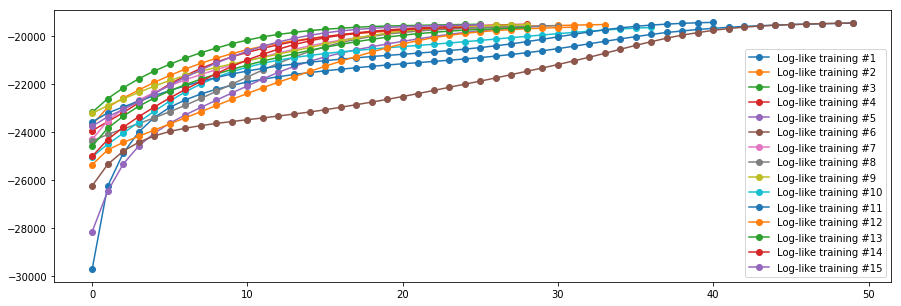

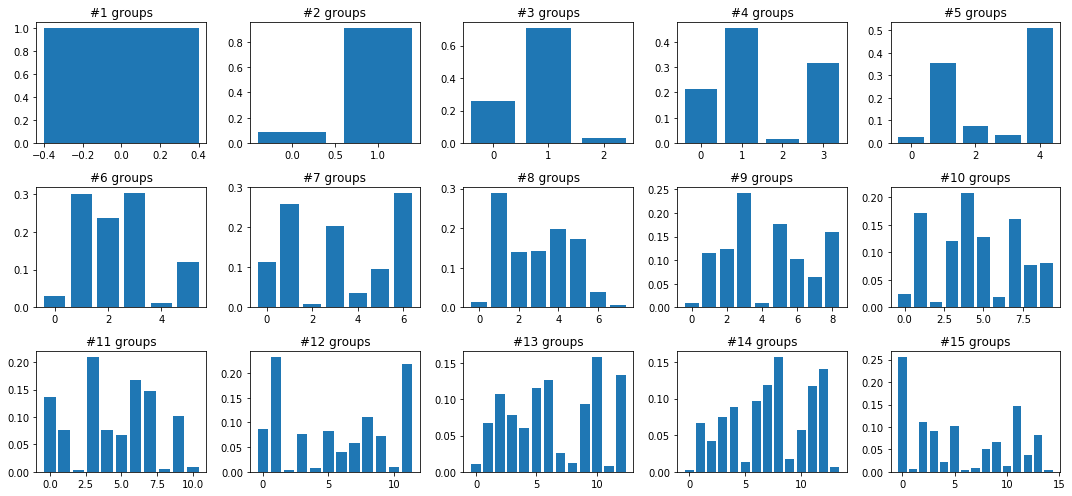

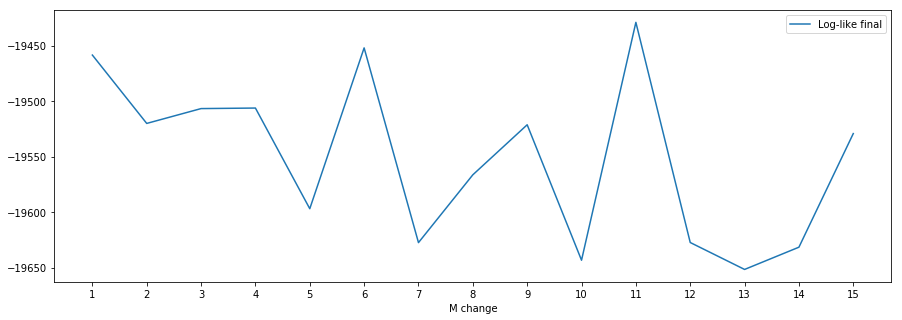

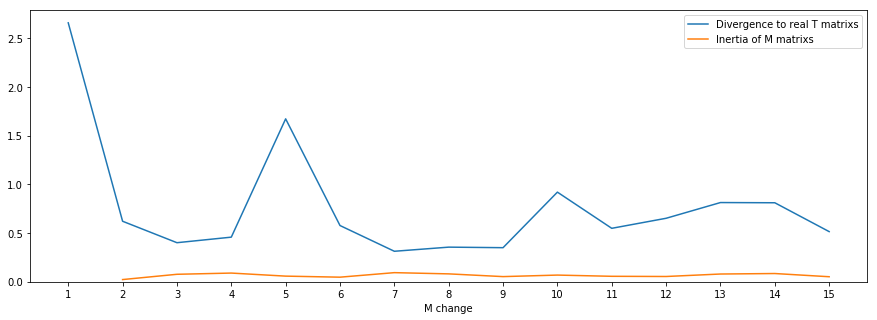

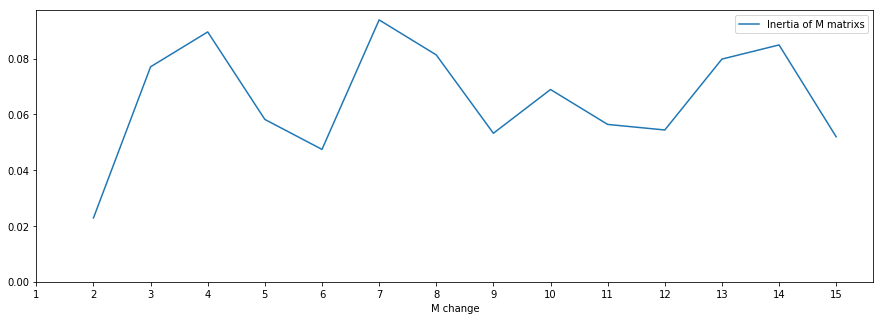

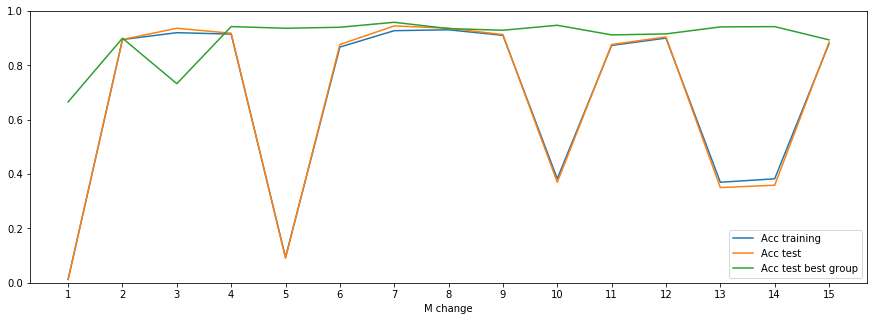

In [22]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence_Mchange,
         probGt_Mchange,
         inertia_Mchange)

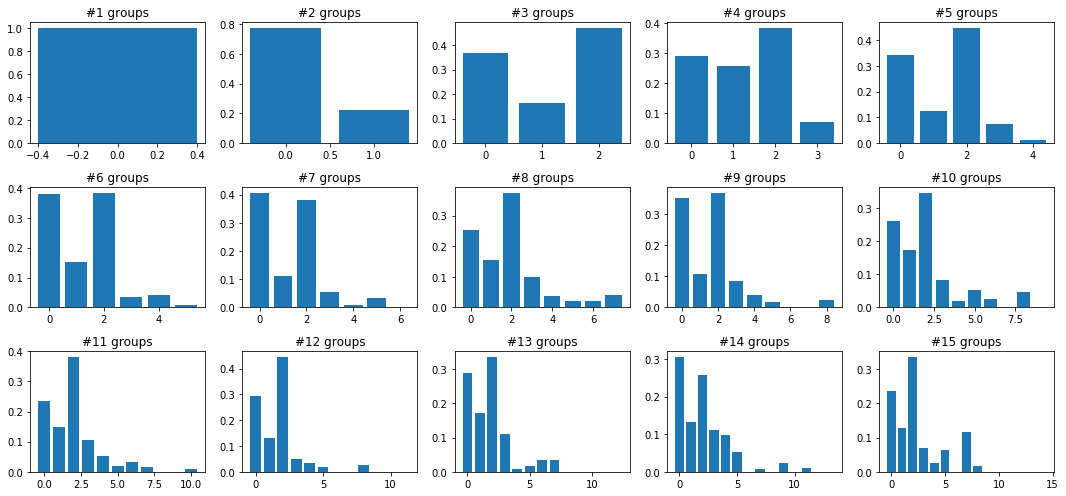

<Figure size 1080x360 with 0 Axes>

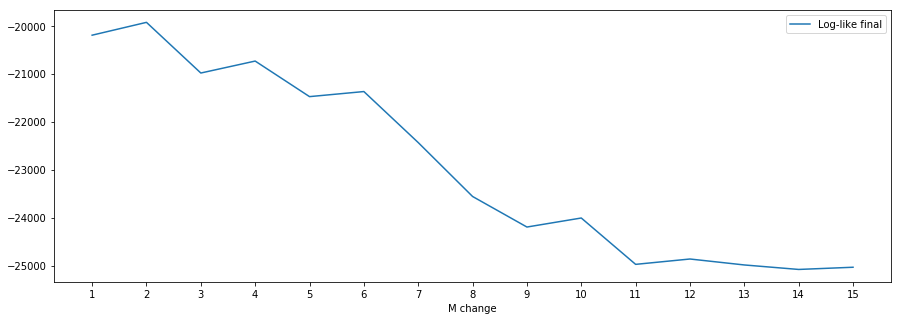

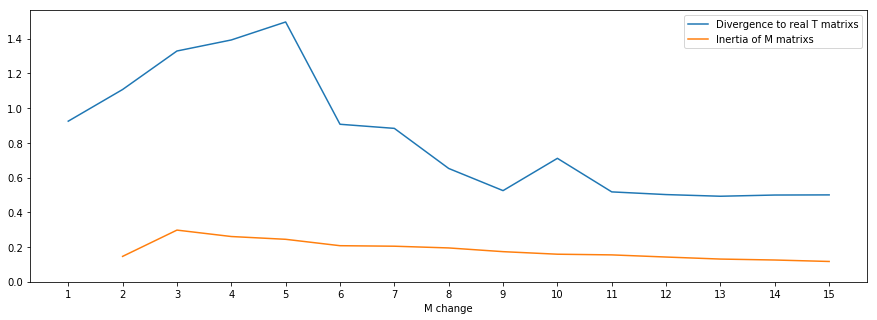

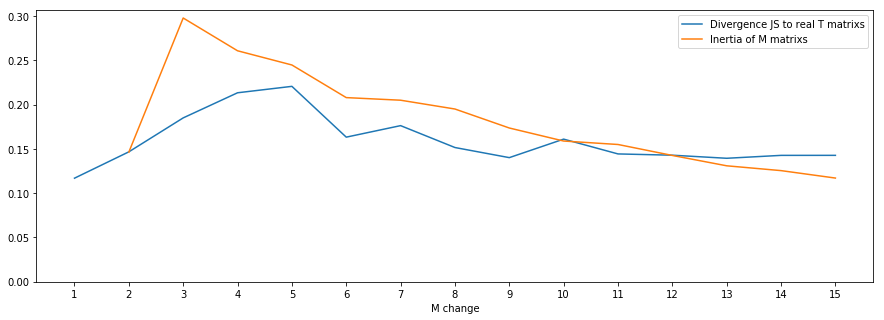

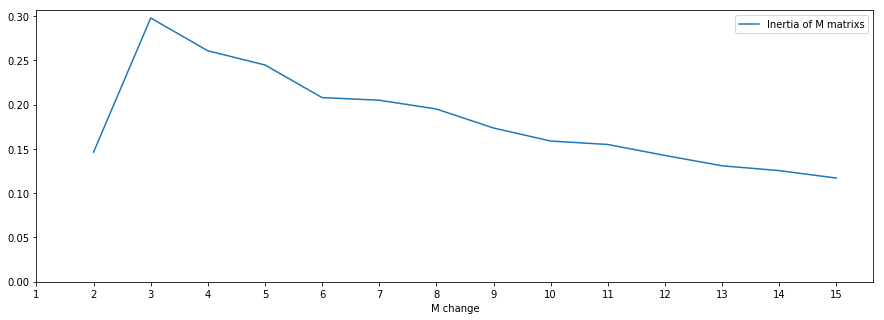

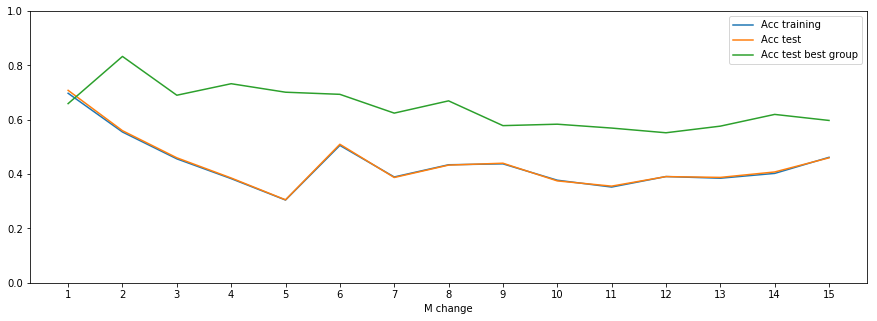

In [23]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange)

In [ ]:
#version mv_Close

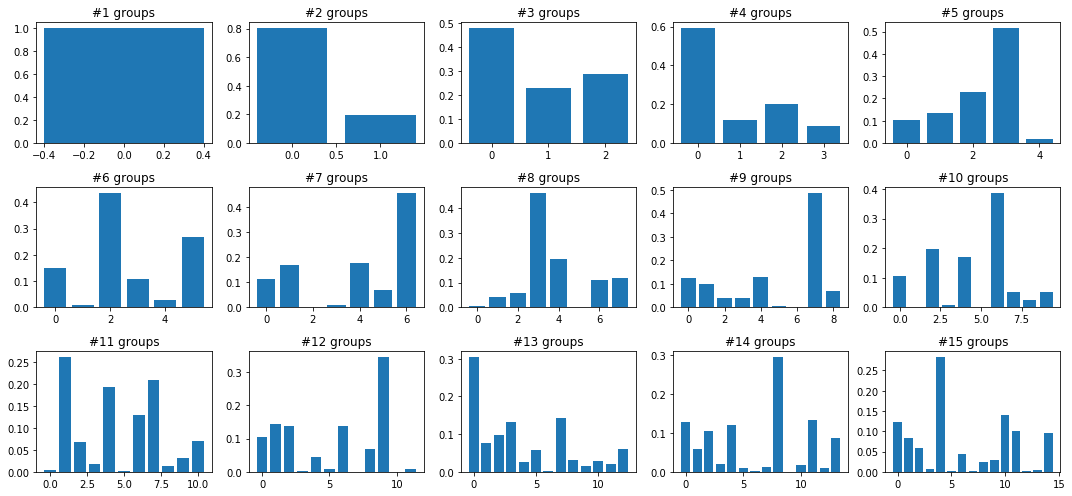

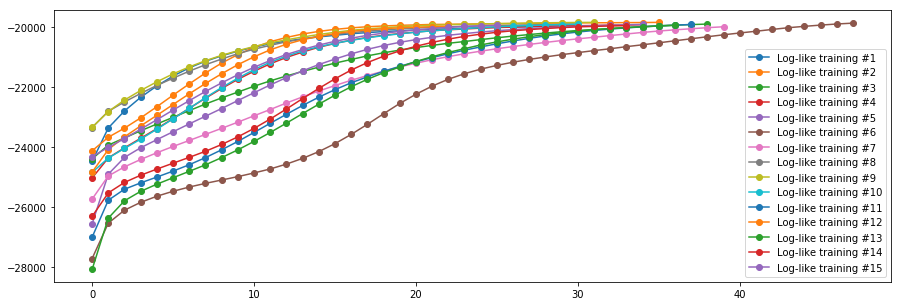

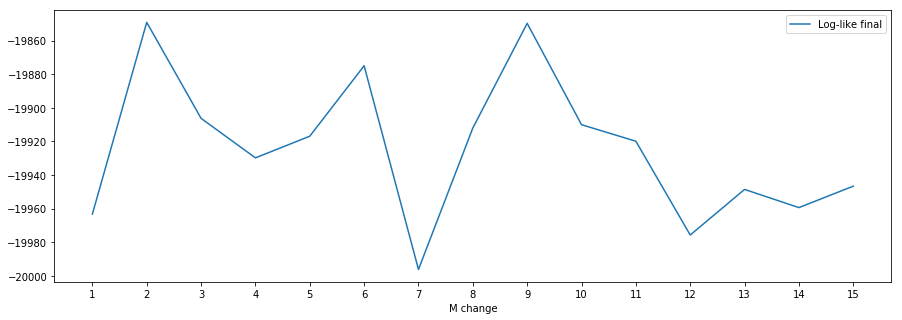

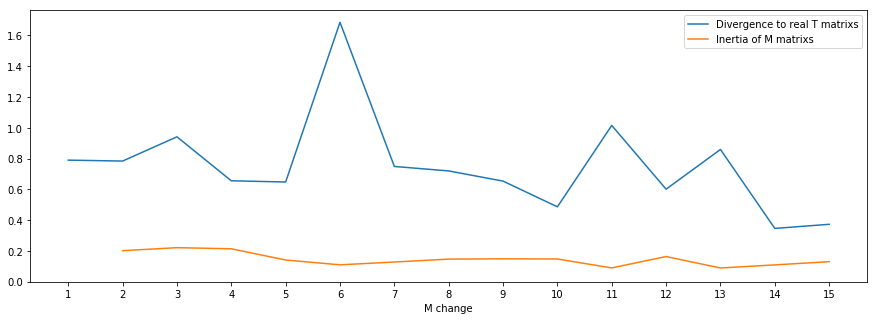

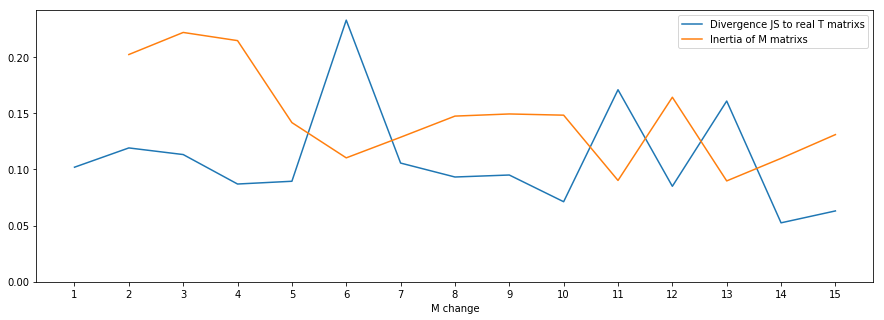

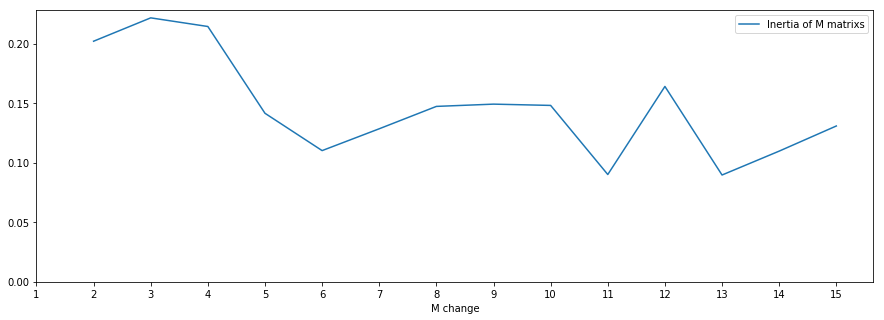

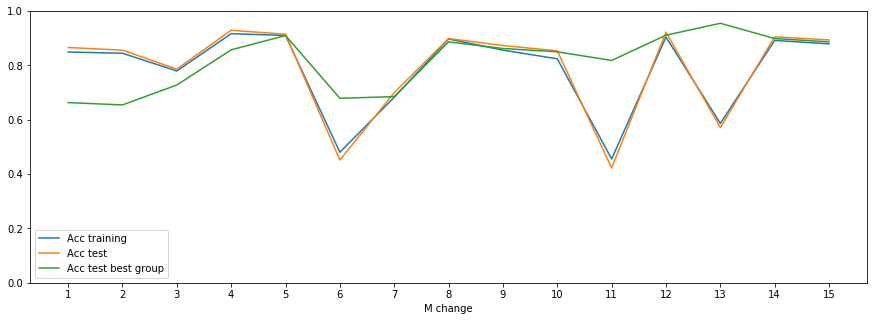

In [20]:
#best?
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange)

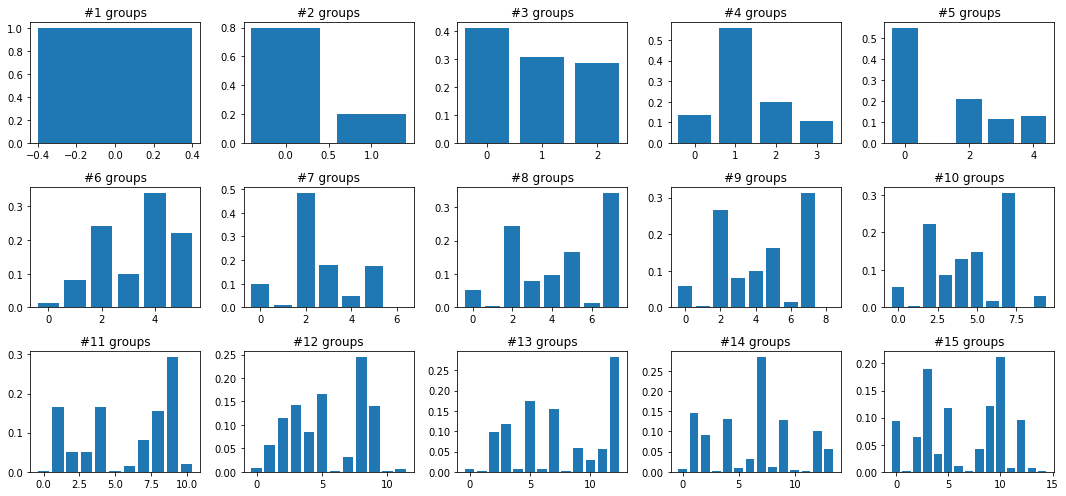

<Figure size 1080x360 with 0 Axes>

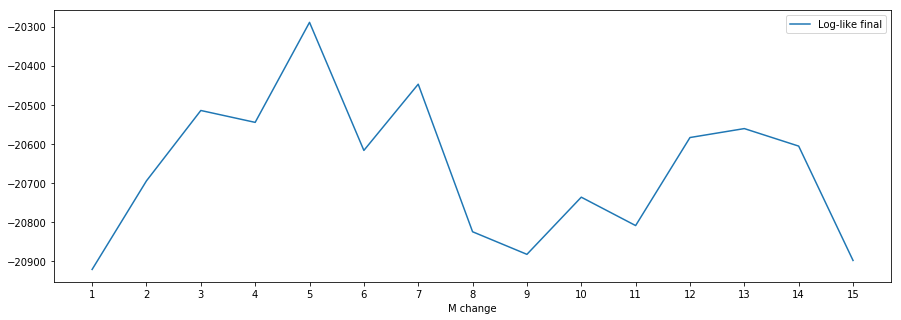

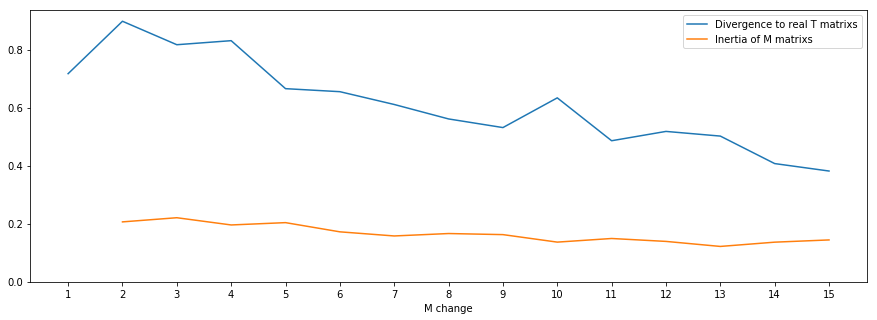

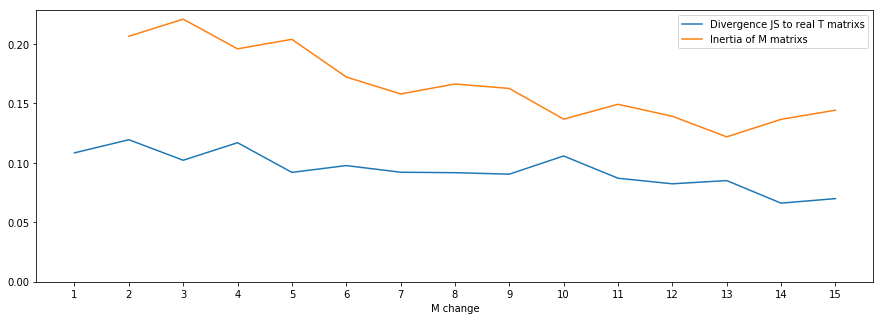

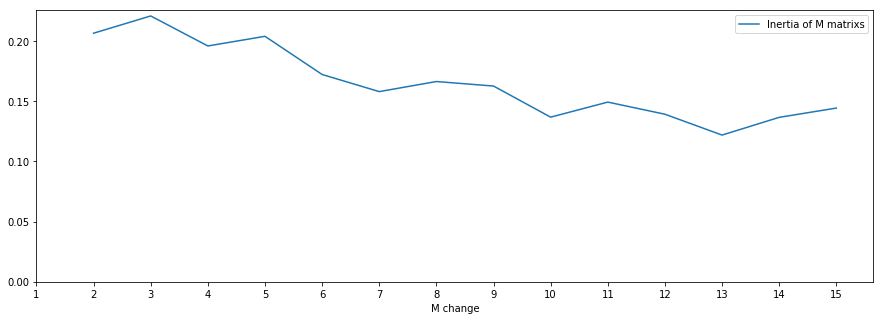

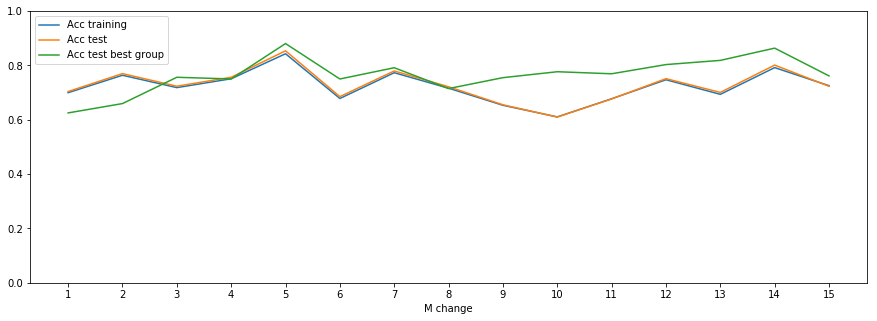

In [14]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange)

In [4]:
#T if i know T
M_values = range(1,1+len(logL_Mchange))
print(T)
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

100


#Groups  >=1 annotator  >=2 annotator  Used on annotators  \
0         1              1              1                   1   
1         2              2              2                   2   
2         3              3              3                   3   
3         4              4              4                   4   
4         5              5              4                   5   
5         6              5              5                   6   
6         7              5              5                   4   
7         8              8              8                   5   
8         9              7              6                   3   
9        10              8              7                   3   
10       11              8              6                   1   
11       12              7              6                   3   
12       13              7              6                   4   
13       14              7              7                   1   
14       15              8              7                   1   

    Used on annotators limit >=0.01  Used on annotators limit >=0.05  
0                                 1                                1  
1                                 2                                2  
2                                 3                                3  
3                                 4                                4  
4                                 5                                5  
5                                 6                                6  
6                                 7                                7  
7                                 8                                8  
8                                 9                                9  
9                                10                               10  
10                               11                                9  
11                               11                               10  
12                               13                               13  
13                               13                               11  
14                               15                               13